In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

import spacy
from ast import literal_eval

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora, models, matutils
import pyLDAvis

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

from gensim.test.utils import datapath
from gensim import  models

In [4]:
#loading model from disk

lda = models.ldamodel.LdaModel.load(datapath("./lda_25_max_df_0.7_100_passes"))



2022-01-26 02:44:14,926 : INFO : loading LdaModel object from /home/julianne_skinner/anaconda3/lib/python3.6/site-packages/gensim/test/test_data/./lda_25_max_df_0.7_100_passes
2022-01-26 02:44:14,929 : INFO : loading expElogbeta from /home/julianne_skinner/anaconda3/lib/python3.6/site-packages/gensim/test/test_data/./lda_25_max_df_0.7_100_passes.expElogbeta.npy with mmap=None
2022-01-26 02:44:14,937 : INFO : setting ignored attribute id2word to None
2022-01-26 02:44:14,940 : INFO : setting ignored attribute state to None
2022-01-26 02:44:14,941 : INFO : setting ignored attribute dispatcher to None
2022-01-26 02:44:14,942 : INFO : loaded /home/julianne_skinner/anaconda3/lib/python3.6/site-packages/gensim/test/test_data/./lda_25_max_df_0.7_100_passes
2022-01-26 02:44:14,943 : INFO : loading LdaState object from /home/julianne_skinner/anaconda3/lib/python3.6/site-packages/gensim/test/test_data/./lda_25_max_df_0.7_100_passes.state
2022-01-26 02:44:14,948 : INFO : loaded /home/julianne_skin

In [5]:
df = pd.read_csv('corpus.csv')
df.content = df.content.apply(lambda x: literal_eval(x))
df = df.drop_duplicates(subset=['date', 'title', 'url', 'segment_title'])
df.content = df.content.apply(lambda x: x[:-2])
df = df.drop(507, axis=0)
df = df.reset_index().drop('index', axis=1)

df.date = pd.to_datetime(df.date)


In [6]:
df['content_joined'] = df.content.apply(lambda x: ' '.join([x.title() if x.isupper() 
                                                            else x for x in ' '.join(x).split(' ')]))

In [7]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS.union(['like', 'just', 'really', 'think', 'know', 'soundbite',
                                           'terry', 'gross', 'yeah', 'laughter', 'actually', 'oh', 'dave', 'davies',
                                            'david', 'bianculli', 'maureen', 'corrigan', 'springsteen', 'patti', 'smith',
                                           'yes', 'sort', 'phillip', 'phoenix', 'whitehead', 'coate', 'ta', 'nehisi', 'bruce',
                                                       'briger', 'robert', 'john', 'justin', 'powers',
                                                       'ms', 'hmm', 'mm', 'unintelligible', 'mr', 'joe', 'stephen',
                                                       'jones', 'scott', 'freshair', 'stuff', 'mr.', 'mrs.', 'ms.',
                                                       'danny', 'miller', 'kevin',
                                                       'book', 'guy'])

In [10]:
# defines a custom vectorizer class
class NounVectorizer(CountVectorizer): 
    
    def build_analyzer(self):
              
        def analyser(x):
            
            doc = nlp(x)

            names = [ ent.text for ent in doc.ents if ent.label_ == 'PERSON' ]

            mytokens = [ token for token in doc if token.text.lower() not in stop_words 
                            and token.text not in string.punctuation 
                            and token.text not in names
                            and token.pos_ == 'NOUN'
                            and re.match('\\b[a-z][a-z]+\\b', token.text.lower()) ]

            mytokens = [ token.lemma_.lower().strip() for token in mytokens ] 
            
            # use CountVectorizer's _word_ngrams built in method
            # to remove stop words and extract n-grams
            return(self._word_ngrams(mytokens, stop_words))
        return(analyser)
    

noun_vec = NounVectorizer(min_df = 5, max_df = 0.7,
                              stop_words=stop_words)

In [12]:

doc_word = noun_vec.fit_transform(df.content_joined).transpose()

corpus = matutils.Sparse2Corpus(doc_word)

id2word = dict((v, k) for k, v in noun_vec.vocabulary_.items())

doc_dict = corpora.Dictionary([list(id2word.values())])


2022-01-25 00:57:47,130 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-01-25 00:57:47,175 : INFO : built Dictionary(13086 unique tokens: ['aaa', 'ab', 'abandon', 'abandonment', 'abasement']...) from 1 documents (total 13086 corpus positions)
2022-01-25 00:57:47,177 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(13086 unique tokens: ['aaa', 'ab', 'abandon', 'abandonment', 'abasement']...) from 1 documents (total 13086 corpus positions)", 'datetime': '2022-01-25T00:57:47.177401', 'gensim': '4.1.2', 'python': '3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) \n[GCC 7.2.0]', 'platform': 'Linux-5.4.0-1062-gcp-x86_64-with-debian-buster-sid', 'event': 'created'}


In [15]:
import pickle
  
# Open a file and use dump()
with open('doc_word.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(doc_word, file)
    
# Open a file and use dump()
with open('sparsecorpus.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(corpus, file)
    
# Open a file and use dump()
with open('id2word.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(id2word, file)

In [8]:
import pickle

with open('doc_word.pkl', 'rb') as file:
      
    # Call load method to deserialze
    doc_word = pickle.load(file)
      
with open('sparsecorpus.pkl', 'rb') as file:
      
    # Call load method to deserialze
    corpus = pickle.load(file)
      
with open('id2word.pkl', 'rb') as file:
      
    # Call load method to deserialze
    id2word = pickle.load(file)

doc_dict = corpora.Dictionary([list(id2word.values())])


2022-01-26 02:49:16,243 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-01-26 02:49:16,310 : INFO : built Dictionary(13086 unique tokens: ['aaa', 'ab', 'abandon', 'abandonment', 'abasement']...) from 1 documents (total 13086 corpus positions)


In [30]:
new_lda = models.LdaMulticore(corpus=corpus, num_topics=25, id2word=id2word, passes=100)

2022-01-25 01:30:24,206 : INFO : using symmetric alpha at 0.04
2022-01-25 01:30:24,208 : INFO : using symmetric eta at 0.04
2022-01-25 01:30:24,211 : INFO : using serial LDA version on this node
2022-01-25 01:30:24,256 : INFO : running online LDA training, 25 topics, 100 passes over the supplied corpus of 7008 documents, updating every 14000 documents, evaluating every ~7008 documents, iterating 50x with a convergence threshold of 0.001000
2022-01-25 01:30:24,258 : INFO : training LDA model using 7 processes
2022-01-25 01:30:24,684 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:30:27,920 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:30:34,238 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 01:30:40,932 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #7008/7008, outstan

2022-01-25 01:32:55,738 : INFO : topic #13 (0.040): 0.033*"child" + 0.026*"water" + 0.012*"parent" + 0.012*"ship" + 0.012*"book" + 0.008*"kid" + 0.008*"family" + 0.007*"mother" + 0.007*"story" + 0.006*"woman"
2022-01-25 01:32:55,739 : INFO : topic #20 (0.040): 0.022*"father" + 0.016*"mother" + 0.013*"kid" + 0.011*"family" + 0.009*"guy" + 0.008*"book" + 0.008*"parent" + 0.007*"dad" + 0.007*"character" + 0.007*"story"
2022-01-25 01:32:55,742 : INFO : topic #2 (0.040): 0.030*"book" + 0.012*"novel" + 0.010*"father" + 0.010*"world" + 0.009*"mother" + 0.008*"family" + 0.008*"man" + 0.008*"character" + 0.007*"story" + 0.007*"child"
2022-01-25 01:32:55,743 : INFO : topic #11 (0.040): 0.014*"president" + 0.011*"government" + 0.011*"war" + 0.011*"book" + 0.009*"country" + 0.007*"campaign" + 0.007*"money" + 0.007*"story" + 0.007*"group" + 0.006*"fact"
2022-01-25 01:32:55,745 : INFO : topic diff=1.003968, rho=0.342916
2022-01-25 01:33:02,094 : INFO : -7.328 per-word bound, 160.7 perplexity estimat

2022-01-25 01:37:31,498 : INFO : topic #20 (0.040): 0.035*"father" + 0.031*"mother" + 0.021*"kid" + 0.019*"family" + 0.017*"parent" + 0.012*"dad" + 0.012*"mom" + 0.011*"school" + 0.010*"child" + 0.010*"brother"
2022-01-25 01:37:31,500 : INFO : topic #11 (0.040): 0.018*"president" + 0.012*"government" + 0.012*"war" + 0.010*"country" + 0.010*"book" + 0.009*"campaign" + 0.007*"group" + 0.007*"administration" + 0.007*"story" + 0.007*"fact"
2022-01-25 01:37:31,502 : INFO : topic diff=0.544762, rho=0.239018
2022-01-25 01:37:37,808 : INFO : -7.224 per-word bound, 149.5 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 01:37:37,970 : INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:37:41,253 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:37:46,905 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #600

2022-01-25 01:40:00,955 : INFO : topic #18 (0.040): 0.027*"cave" + 0.016*"child" + 0.015*"green" + 0.014*"film" + 0.012*"accordion" + 0.011*"hospital" + 0.011*"book" + 0.008*"story" + 0.008*"hand" + 0.007*"rider"
2022-01-25 01:40:00,957 : INFO : topic #23 (0.040): 0.059*"song" + 0.022*"music" + 0.018*"album" + 0.018*"band" + 0.014*"record" + 0.012*"singing" + 0.008*"guitar" + 0.008*"rock" + 0.007*"man" + 0.007*"guy"
2022-01-25 01:40:00,959 : INFO : topic #21 (0.040): 0.039*"police" + 0.020*"car" + 0.015*"crime" + 0.014*"cop" + 0.013*"guy" + 0.013*"officer" + 0.013*"drug" + 0.011*"case" + 0.009*"community" + 0.009*"city"
2022-01-25 01:40:00,960 : INFO : topic #9 (0.040): 0.081*"woman" + 0.019*"child" + 0.014*"abortion" + 0.014*"right" + 0.014*"law" + 0.014*"man" + 0.013*"marriage" + 0.012*"case" + 0.011*"book" + 0.009*"issue"
2022-01-25 01:40:00,961 : INFO : topic #17 (0.040): 0.029*"book" + 0.023*"story" + 0.013*"novel" + 0.011*"writer" + 0.009*"family" + 0.009*"word" + 0.008*"poem" + 

2022-01-25 01:42:03,164 : INFO : topic diff=0.224620, rho=0.194243
2022-01-25 01:42:09,516 : INFO : -7.199 per-word bound, 146.9 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 01:42:09,681 : INFO : PROGRESS: pass 23, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:42:13,038 : INFO : PROGRESS: pass 23, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:42:19,083 : INFO : PROGRESS: pass 23, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 01:42:25,043 : INFO : PROGRESS: pass 23, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 2
2022-01-25 01:42:33,296 : INFO : topic #12 (0.040): 0.108*"dog" + 0.043*"cat" + 0.034*"horse" + 0.020*"animal" + 0.008*"book" + 0.007*"pet" + 0.006*"bit" + 0.005*"behavior" + 0.005*"house" + 0.005*"stunt"
2022-01-25 01:42:33,298 : INFO : topic #9 (0.040): 0.084*"woman" + 0.021*"c

2022-01-25 01:44:37,162 : INFO : topic #16 (0.040): 0.023*"brain" + 0.019*"patient" + 0.018*"drug" + 0.015*"doctor" + 0.012*"pain" + 0.012*"book" + 0.011*"cancer" + 0.009*"experience" + 0.008*"body" + 0.008*"problem"
2022-01-25 01:44:37,163 : INFO : topic #18 (0.040): 0.029*"cave" + 0.018*"child" + 0.017*"green" + 0.012*"accordion" + 0.012*"book" + 0.012*"hospital" + 0.012*"film" + 0.010*"rider" + 0.010*"antibiotic" + 0.010*"bacteria"
2022-01-25 01:44:37,167 : INFO : topic #13 (0.040): 0.048*"water" + 0.021*"child" + 0.017*"ship" + 0.017*"space" + 0.010*"book" + 0.009*"boat" + 0.008*"plane" + 0.007*"flight" + 0.007*"crew" + 0.007*"sea"
2022-01-25 01:44:37,168 : INFO : topic diff=0.149410, rho=0.178163
2022-01-25 01:44:44,839 : INFO : -7.191 per-word bound, 146.2 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 01:44:45,005 : INFO : PROGRESS: pass 28, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:44:

2022-01-25 01:49:27,678 : INFO : topic #22 (0.040): 0.043*"girl" + 0.031*"woman" + 0.023*"sex" + 0.014*"man" + 0.013*"boy" + 0.012*"friend" + 0.011*"school" + 0.011*"relationship" + 0.010*"person" + 0.010*"body"
2022-01-25 01:49:27,680 : INFO : topic diff=0.084876, rho=0.157127
2022-01-25 01:49:34,169 : INFO : -7.183 per-word bound, 145.3 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 01:49:34,335 : INFO : PROGRESS: pass 37, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:49:37,767 : INFO : PROGRESS: pass 37, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:49:43,922 : INFO : PROGRESS: pass 37, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 01:49:50,396 : INFO : PROGRESS: pass 37, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 2
2022-01-25 01:49:59,636 : INFO : topic #10 (0.040): 0.027*"comedy" +

2022-01-25 01:52:10,212 : INFO : topic #21 (0.040): 0.039*"police" + 0.020*"crime" + 0.018*"car" + 0.016*"drug" + 0.015*"guy" + 0.015*"case" + 0.013*"cop" + 0.012*"officer" + 0.011*"community" + 0.011*"street"
2022-01-25 01:52:10,213 : INFO : topic #17 (0.040): 0.037*"book" + 0.025*"story" + 0.023*"novel" + 0.015*"writer" + 0.011*"poem" + 0.010*"word" + 0.008*"world" + 0.007*"critic" + 0.007*"writing" + 0.007*"memoir"
2022-01-25 01:52:10,215 : INFO : topic #3 (0.040): 0.040*"character" + 0.028*"series" + 0.024*"scene" + 0.018*"actor" + 0.014*"season" + 0.013*"role" + 0.012*"episode" + 0.011*"movie" + 0.011*"man" + 0.009*"guy"
2022-01-25 01:52:10,216 : INFO : topic #12 (0.040): 0.117*"dog" + 0.047*"cat" + 0.037*"horse" + 0.023*"animal" + 0.008*"book" + 0.008*"pet" + 0.006*"behavior" + 0.006*"bit" + 0.006*"house" + 0.006*"stunt"
2022-01-25 01:52:10,218 : INFO : topic diff=0.066639, rho=0.148243
2022-01-25 01:52:16,863 : INFO : -7.179 per-word bound, 144.9 perplexity estimate based on a h

2022-01-25 01:54:19,691 : INFO : PROGRESS: pass 46, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:54:22,926 : INFO : PROGRESS: pass 46, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:54:28,882 : INFO : PROGRESS: pass 46, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 01:54:34,877 : INFO : PROGRESS: pass 46, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 2
2022-01-25 01:54:43,008 : INFO : topic #23 (0.040): 0.075*"song" + 0.027*"music" + 0.022*"band" + 0.021*"album" + 0.017*"record" + 0.016*"singing" + 0.013*"rock" + 0.012*"guitar" + 0.009*"singer" + 0.008*"guy"
2022-01-25 01:54:43,009 : INFO : topic #1 (0.040): 0.027*"company" + 0.016*"information" + 0.013*"computer" + 0.012*"internet" + 0.011*"book" + 0.010*"technology" + 0.010*"system" + 0.010*"world" + 0.009*"datum" + 0.009*"phone"
2022-01-25 01:54:43,010 : INFO : topic #7 (0.040): 0.0

2022-01-25 01:56:41,747 : INFO : topic #15 (0.040): 0.023*"book" + 0.020*"slave" + 0.018*"history" + 0.014*"man" + 0.014*"slavery" + 0.011*"art" + 0.010*"century" + 0.009*"story" + 0.008*"work" + 0.008*"novel"
2022-01-25 01:56:41,748 : INFO : topic #12 (0.040): 0.120*"dog" + 0.048*"cat" + 0.038*"horse" + 0.023*"animal" + 0.008*"book" + 0.008*"pet" + 0.006*"behavior" + 0.006*"bit" + 0.006*"house" + 0.006*"stunt"
2022-01-25 01:56:41,750 : INFO : topic diff=0.046919, rho=0.135452
2022-01-25 01:56:47,935 : INFO : -7.175 per-word bound, 144.5 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 01:56:48,097 : INFO : PROGRESS: pass 51, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 01:56:51,329 : INFO : PROGRESS: pass 51, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 01:56:56,894 : INFO : PROGRESS: pass 51, dispatched chunk #2 = documents up to #6000/7008, outstanding queue

2022-01-25 01:59:08,486 : INFO : topic #5 (0.040): 0.031*"food" + 0.010*"book" + 0.010*"oil" + 0.009*"virus" + 0.009*"water" + 0.008*"restaurant" + 0.008*"fish" + 0.007*"world" + 0.007*"climate" + 0.007*"meat"
2022-01-25 01:59:08,488 : INFO : topic #18 (0.040): 0.030*"cave" + 0.021*"child" + 0.019*"antibiotic" + 0.018*"green" + 0.014*"book" + 0.014*"bacteria" + 0.013*"rider" + 0.012*"accordion" + 0.012*"cowboy" + 0.012*"hospital"
2022-01-25 01:59:08,489 : INFO : topic #14 (0.040): 0.034*"animal" + 0.015*"bird" + 0.011*"sleep" + 0.010*"specie" + 0.010*"bear" + 0.010*"whale" + 0.009*"book" + 0.009*"ice" + 0.009*"human" + 0.008*"place"
2022-01-25 01:59:08,490 : INFO : topic #9 (0.040): 0.081*"woman" + 0.025*"child" + 0.023*"right" + 0.020*"law" + 0.017*"case" + 0.015*"abortion" + 0.015*"marriage" + 0.015*"court" + 0.014*"man" + 0.011*"decision"
2022-01-25 01:59:08,491 : INFO : topic #24 (0.040): 0.031*"health" + 0.026*"care" + 0.022*"country" + 0.020*"government" + 0.016*"insurance" + 0.0

2022-01-25 02:01:11,860 : INFO : topic diff=0.035372, rho=0.125487
2022-01-25 02:01:18,283 : INFO : -7.171 per-word bound, 144.1 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 02:01:18,446 : INFO : PROGRESS: pass 60, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 02:01:21,686 : INFO : PROGRESS: pass 60, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 02:01:27,646 : INFO : PROGRESS: pass 60, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 02:01:33,767 : INFO : PROGRESS: pass 60, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 2
2022-01-25 02:01:41,679 : INFO : topic #4 (0.040): 0.061*"school" + 0.031*"student" + 0.026*"college" + 0.013*"story" + 0.013*"teacher" + 0.013*"class" + 0.012*"education" + 0.011*"book" + 0.010*"community" + 0.008*"case"
2022-01-25 02:01:41,680 : INFO : topic #9 (0.040): 0.079*"

2022-01-25 02:03:43,057 : INFO : topic #3 (0.040): 0.042*"character" + 0.031*"series" + 0.025*"scene" + 0.019*"actor" + 0.015*"season" + 0.013*"role" + 0.013*"episode" + 0.011*"man" + 0.010*"movie" + 0.009*"guy"
2022-01-25 02:03:43,058 : INFO : topic #9 (0.040): 0.078*"woman" + 0.025*"child" + 0.024*"right" + 0.022*"law" + 0.019*"case" + 0.018*"court" + 0.015*"abortion" + 0.015*"marriage" + 0.013*"man" + 0.012*"decision"
2022-01-25 02:03:43,059 : INFO : topic #18 (0.040): 0.030*"cave" + 0.021*"child" + 0.020*"antibiotic" + 0.018*"green" + 0.015*"bacteria" + 0.014*"book" + 0.013*"rider" + 0.012*"accordion" + 0.012*"cowboy" + 0.012*"hospital"
2022-01-25 02:03:43,060 : INFO : topic diff=0.030823, rho=0.120821
2022-01-25 02:03:49,265 : INFO : -7.169 per-word bound, 143.9 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 02:03:49,429 : INFO : PROGRESS: pass 65, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 0

2022-01-25 02:08:16,020 : INFO : topic #14 (0.040): 0.035*"animal" + 0.015*"bird" + 0.011*"sleep" + 0.011*"specie" + 0.010*"bear" + 0.010*"whale" + 0.009*"book" + 0.009*"human" + 0.009*"ice" + 0.008*"place"
2022-01-25 02:08:16,021 : INFO : topic #12 (0.040): 0.123*"dog" + 0.049*"cat" + 0.039*"horse" + 0.024*"animal" + 0.008*"book" + 0.008*"pet" + 0.007*"behavior" + 0.006*"bit" + 0.006*"house" + 0.006*"stunt"
2022-01-25 02:08:16,023 : INFO : topic diff=0.024696, rho=0.113589
2022-01-25 02:08:22,196 : INFO : -7.167 per-word bound, 143.7 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 02:08:22,358 : INFO : PROGRESS: pass 74, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 02:08:25,567 : INFO : PROGRESS: pass 74, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 02:08:31,347 : INFO : PROGRESS: pass 74, dispatched chunk #2 = documents up to #6000/7008, outstanding queue si

2022-01-25 02:12:47,487 : INFO : topic #3 (0.040): 0.043*"character" + 0.033*"series" + 0.025*"scene" + 0.019*"actor" + 0.016*"season" + 0.014*"episode" + 0.014*"role" + 0.011*"man" + 0.010*"guy" + 0.009*"voice"
2022-01-25 02:12:47,488 : INFO : topic diff=0.020346, rho=0.107518
2022-01-25 02:12:53,641 : INFO : -7.165 per-word bound, 143.5 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 02:12:53,803 : INFO : PROGRESS: pass 83, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 02:12:57,052 : INFO : PROGRESS: pass 83, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 02:13:02,874 : INFO : PROGRESS: pass 83, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 02:13:09,024 : INFO : PROGRESS: pass 83, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 3
2022-01-25 02:13:17,326 : INFO : topic #14 (0.040): 0.035*"animal" +

2022-01-25 02:15:17,326 : INFO : topic #16 (0.040): 0.022*"brain" + 0.019*"drug" + 0.019*"patient" + 0.015*"doctor" + 0.015*"cancer" + 0.012*"book" + 0.012*"pain" + 0.011*"body" + 0.010*"disease" + 0.009*"problem"
2022-01-25 02:15:17,328 : INFO : topic #2 (0.040): 0.037*"book" + 0.022*"world" + 0.019*"church" + 0.012*"religion" + 0.011*"idea" + 0.010*"sense" + 0.010*"novel" + 0.009*"question" + 0.009*"man" + 0.008*"faith"
2022-01-25 02:15:17,330 : INFO : topic #11 (0.040): 0.022*"president" + 0.013*"government" + 0.011*"campaign" + 0.010*"country" + 0.009*"book" + 0.009*"administration" + 0.009*"story" + 0.008*"question" + 0.008*"fact" + 0.008*"group"
2022-01-25 02:15:17,331 : INFO : topic #24 (0.040): 0.031*"health" + 0.027*"country" + 0.026*"care" + 0.024*"government" + 0.016*"system" + 0.015*"city" + 0.015*"insurance" + 0.011*"place" + 0.011*"plan" + 0.011*"area"
2022-01-25 02:15:17,333 : INFO : topic diff=0.018451, rho=0.104539
2022-01-25 02:15:23,490 : INFO : -7.164 per-word bound

2022-01-25 02:17:21,879 : INFO : PROGRESS: pass 92, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 02:17:25,167 : INFO : PROGRESS: pass 92, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 02:17:30,783 : INFO : PROGRESS: pass 92, dispatched chunk #2 = documents up to #6000/7008, outstanding queue size 2
2022-01-25 02:17:37,092 : INFO : PROGRESS: pass 92, dispatched chunk #3 = documents up to #7008/7008, outstanding queue size 2
2022-01-25 02:17:46,127 : INFO : topic #16 (0.040): 0.022*"brain" + 0.019*"drug" + 0.019*"patient" + 0.015*"doctor" + 0.015*"cancer" + 0.012*"book" + 0.012*"pain" + 0.012*"body" + 0.010*"disease" + 0.009*"problem"
2022-01-25 02:17:46,129 : INFO : topic #22 (0.040): 0.047*"woman" + 0.040*"girl" + 0.023*"sex" + 0.018*"man" + 0.014*"friend" + 0.013*"relationship" + 0.012*"boy" + 0.011*"person" + 0.011*"body" + 0.010*"school"
2022-01-25 02:17:46,130 : INFO : topic #11 (0.040): 0.022*"preside

2022-01-25 02:19:47,501 : INFO : topic #1 (0.040): 0.029*"company" + 0.017*"information" + 0.014*"computer" + 0.013*"internet" + 0.012*"book" + 0.011*"technology" + 0.011*"world" + 0.011*"system" + 0.010*"phone" + 0.009*"datum"
2022-01-25 02:19:47,502 : INFO : topic #14 (0.040): 0.036*"animal" + 0.015*"bird" + 0.011*"specie" + 0.010*"sleep" + 0.010*"bear" + 0.010*"whale" + 0.009*"human" + 0.009*"book" + 0.009*"ice" + 0.008*"place"
2022-01-25 02:19:47,504 : INFO : topic diff=0.015769, rho=0.099749
2022-01-25 02:19:53,751 : INFO : -7.162 per-word bound, 143.3 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 02:19:53,916 : INFO : PROGRESS: pass 97, dispatched chunk #0 = documents up to #2000/7008, outstanding queue size 1
2022-01-25 02:19:57,168 : INFO : PROGRESS: pass 97, dispatched chunk #1 = documents up to #4000/7008, outstanding queue size 2
2022-01-25 02:20:02,860 : INFO : PROGRESS: pass 97, dispatched chunk #2 = documents up to #6000/700

In [20]:
import pyLDAvis.gensim as gs

pyLDAvis.enable_notebook()
vis = gs.prepare(lda, corpus, doc_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.120752 -0.110903       1        1  9.891244
20    -0.105424 -0.050441       2        1  8.019990
3     -0.148050 -0.053010       3        1  7.047734
8     -0.182750  0.011737       4        1  6.459694
23    -0.177496  0.007522       5        1  5.415663
0     -0.150245 -0.047014       6        1  5.271130
17    -0.116704 -0.056481       7        1  5.166718
7      0.199647 -0.069661       8        1  5.067929
16     0.063285  0.062135       9        1  4.672394
2     -0.020222 -0.081069      10        1  4.341451
10    -0.133440 -0.033932      11        1  4.260641
19     0.076406 -0.011507      12        1  3.532230
21     0.093675 -0.053313      13        1  3.483292
1      0.147631 -0.021665      14        1  3.416826
22    -0.094978 -0.085071      15        1  3.399994
5      0.095607  0.188759      16        1  3.265435
9      0.125967 -0.139381      17        1  2.844744
15     0.012847 -0.030362      18        1  2.636180
24     0.196265  0.005328      19        1  2.520518
4      0.083774 -0.095673      20        1  2.156164
13     0.036542  0.172174      21        1  1.986375
6     -0.057457  0.031234      22        1  1.984545
14     0.026724  0.211107      23        1  1.619433
12    -0.002011  0.159873      24        1  1.133604
18    -0.090345  0.089614      25        1  0.406071, topic_info=         Term          Freq         Total Category  logprob  loglift
10880    song  26361.000000  26361.000000  Default  30.0000  30.0000
4413     film  22370.000000  22370.000000  Default  29.0000  29.0000
7566    movie  20633.000000  20633.000000  Default  28.0000  28.0000
12935   woman  19301.000000  19301.000000  Default  27.0000  27.0000
10192  school  13039.000000  13039.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2735   course     82.414812  11061.217500  Topic25  -5.1229   0.6070
5385     head     75.640553   7339.873336  Topic25  -5.2086   0.9313
4413     film     85.730608  22370.227872  Topic25  -5.0834  -0.0579
7474    money     67.174717  11491.100540  Topic25  -5.3273   0.3644
1078      bit     66.874797  12496.423055  Topic25  -5.3318   0.2760

[1970 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
16         1  0.078895     abolition
16        18  0.828400     abolition
16        19  0.059171     abolition
17         1  0.017616  abolitionist
17        17  0.026425  abolitionist
...      ...       ...           ...
13081     23  0.783234           zoo
13081     24  0.022868           zoo
13081     25  0.011434           zoo
13082     24  0.915579     zookeeper
13085     16  0.987832      zucchini

[12672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 21, 4, 9, 24, 1, 18, 8, 17, 3, 11, 20, 22, 2, 23, 6, 10, 16, 25, 5, 14, 7, 15, 13, 19])

In [10]:
# topic coherence
import gensim 

cm = gensim.models.coherencemodel.CoherenceModel(
     model=lda, corpus=corpus, dictionary=doc_dict, coherence='u_mass')   

cm.get_coherence()

2022-01-26 02:50:16,790 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-01-26 02:50:16,939 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-01-26 02:50:17,111 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-01-26 02:50:17,284 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-01-26 02:50:17,466 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2022-01-26 02:50:17,653 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2022-01-26 02:50:17,848 : INFO : CorpusAccumulator accumulated stats from 7000 documents


-1.2367469015944352

In [11]:

doc_topics = lda.get_document_topics(corpus, minimum_probability=None, 
                                  minimum_phi_value=None, per_word_topics=False)

all_topics_csr = gensim.matutils.corpus2csc(doc_topics)
all_topics_numpy = all_topics_csr.T.toarray()

In [12]:
for topic_id in range(lda.num_topics):
    topk = lda.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: film movie scene director character actor story documentary man critic
1: company information computer internet book technology world system phone datum
2: book world church religion idea sense novel question faith man
3: character series scene actor season episode role man guy voice
4: school student college class teacher education community kid race book
5: food book virus oil restaurant fish water climate meat world
6: game guy player team ball baseball sport pitch pitcher book
7: money state company business bank tax law election government bill
8: song music singing album jazz band singer recording piano sound
9: woman right law court case child abortion decision marriage issue
10: comedy joke guy night audience interview guest stage week writer
11: president government campaign country book administration story question fact election
12: dog cat horse animal book pet behavior bit toy stunt
13: water space ship river plane air boat book sea mile
14: animal bird specie sleep bea

In [15]:
df['length'] = df.content_joined.str.split(' ').apply(len)

In [97]:
import datetime as dt

def top_similar_episode(episodeID, doc_topics, n=5):
    
    # content-based similarity
    distances = pairwise_distances(doc_topics[episodeID].reshape(1,-1), doc_topics, metric='cosine')[0]
       
        
    # prioritize more recent shows
    dates = df.loc[:, 'date']
    diff = (dates - dt.datetime.now()).dt.days
    time_range = diff.max() - diff.min()
    recency_weight = 1 - diff/time_range
    
    # prioritize shows more similar in length (word count)
    length = df.loc[episodeID, 'length']
    length_diff = np.abs(length - df.loc[:, 'length'])
    length_range = length_diff.max() - length_diff.min()
    showlength_weight = 1 - length_diff/(50*length_range)

    episode_index = np.argsort(distances*recency_weight*showlength_weight)
    
    # remove repeated broadcasts of the same episode
    title = df.loc[episodeID, 'segment_title']
    
    recs = df.loc[episode_index,['date', 'segment_title', 'length']]
    recs = recs[recs['segment_title']!=title]
    
    return title, length, recs[:n]


In [99]:
title, length, recs = top_similar_episode(6994, all_topics_numpy)
print(title, '\t', length, '\n')
print(recs.to_string(index=False))

< How a group of online sleuths are helping the FBI track down Jan. 6 rioters 	 7133 

      date                                                                       segment_title  length
2021-01-27  < Surveillance And Local Police: How Technology Is Evolving Faster Than Regulation    7325
2014-03-04               < By The Time Your Car Goes Driverless, You Won't Know The Difference     872
2019-02-27      < 'Consumer Reports' Director Offers An Inside Take On The Car Testing Process    3151
2018-12-10           < The Revolution Will Be Driverless: Autonomous Cars Usher In Big Changes    6287
2017-08-22             < FBI Profiler Says Linguistic Work Was Pivotal In Capture Of Unabomber    7654


In [98]:
title, length, recs = top_similar_episode(6999, all_topics_numpy)
print(title, '\t', length, '\n')
print(recs.to_string(index=False))

< Kieran Culkin is having fun with 'Succession' — and he hopes you are too 	 9187 

      date                                                                segment_title  length
2016-02-10     < Duplass Brothers On Filmmaking, Siblings And Parenting's 'Fugue State'    3654
2015-10-14  < Actor Randall Park Says 'Fresh Off The Boat' Is Comedy Without The Cliché    3448
2013-05-23                           < Julianne Moore, Relishing Complicated Characters    8139
2019-12-17   < 'Fresh Air' Remembers 'Do The Right Thing' And 'Ruby' Actor Danny Aiello    2295
2011-01-03                                        < Actor Pete Postlethwaite, 1946-2011    2432


In [38]:
docID = 6994

main_topics = np.argsort(all_topics_numpy[docID])[::-1][:5]

for topicID in main_topics:
    print([lda.id2word[x[0]] for x in lda.get_topic_terms(topicID)])

['police', 'crime', 'case', 'drug', 'guy', 'car', 'prison', 'cop', 'officer', 'law']
['company', 'information', 'computer', 'internet', 'book', 'technology', 'world', 'system', 'phone', 'datum']
['president', 'government', 'campaign', 'country', 'book', 'administration', 'story', 'question', 'fact', 'election']
['woman', 'girl', 'sex', 'man', 'friend', 'relationship', 'boy', 'person', 'body', 'school']
['father', 'mother', 'family', 'child', 'kid', 'parent', 'mom', 'school', 'house', 'dad']


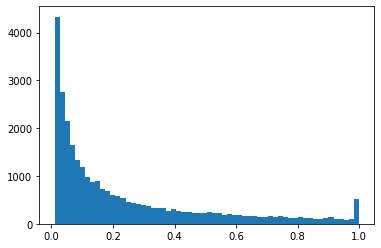

In [168]:
# distribution of topic likelihood across documents
plt.hist(all_topics_numpy.flatten()[all_topics_numpy.flatten()!=0], bins=60)
plt.show()

In [39]:
# based on the above distribution, I chose 0.1 as a cutoff to include a document in a topic category (for plotting)
topic_code = df[['year']].join(pd.DataFrame((all_topics_numpy > 0.1).astype(int)))
topic_code = topic_code[(topic_code['year'] > 2008) & (topic_code['year'] < 2022)]

In [121]:
biggest_topics = topic_code.groupby('year').sum().sum().sort_values(ascending=False).index.to_list()[:6]

In [122]:
biggest_topics

[17, 3, 8, 20, 0, 11]

In [123]:
for topicID in biggest_topics:
    print([lda.id2word[x[0]] for x in lda.get_topic_terms(topicID)])

['book', 'novel', 'story', 'writer', 'word', 'poem', 'critic', 'world', 'character', 'writing']
['character', 'series', 'scene', 'actor', 'season', 'episode', 'role', 'man', 'guy', 'voice']
['song', 'music', 'singing', 'album', 'jazz', 'band', 'singer', 'recording', 'piano', 'sound']
['father', 'mother', 'family', 'child', 'kid', 'parent', 'mom', 'school', 'house', 'dad']
['film', 'movie', 'scene', 'director', 'character', 'actor', 'story', 'documentary', 'man', 'critic']
['president', 'government', 'campaign', 'country', 'book', 'administration', 'story', 'question', 'fact', 'election']


In [126]:
plt.rcParams.update({'font.size':14})
filtered_topics = topic_code.loc[:, ['year'] + biggest_topics].groupby('year').sum()#.drop('year', axis=1)

fig, ax= plt.subplots(figsize=(10,5))
plt.plot(filtered_topics)
plt.legend(labels=['series', 'jazz', 'family', 'film', "U.S. gov", 'rock/country music', 'comedy', 'religion'], loc='lower left')
plt.xticks(rotation=0)
plt.ylabel('Topic Frequency (# Episodes)')
# plt.show()
plt.savefig('topics_over_time.png')


In [250]:
# compare coherence based on # of topics
coherence = []
for k in np.arange(10,52,2):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus, num_topics=k, 
               id2word = id2word, passes=40,
               iterations=20, chunksize = 10000, eval_every = None)

    cm = gensim.models.coherencemodel.CoherenceModel(
         model=ldamodel, corpus=corpus,
         dictionary=doc_dict, coherence='u_mass')   
                                                
    coherence.append((k,cm.get_coherence()))

2022-01-23 20:27:42,791 : INFO : using symmetric alpha at 0.1
2022-01-23 20:27:42,792 : INFO : using symmetric eta at 0.1
2022-01-23 20:27:42,794 : INFO : using serial LDA version on this node
2022-01-23 20:27:42,798 : INFO : running online (multi-pass) LDA training, 10 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 10


2022-01-23 20:27:43,569 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:27:47,753 : INFO : topic #5 (0.100): 0.007*"song" + 0.006*"book" + 0.005*"movie" + 0.005*"film" + 0.004*"love" + 0.004*"happen" + 0.004*"see" + 0.004*"need" + 0.004*"live" + 0.003*"war"
2022-01-23 20:27:47,755 : INFO : topic #7 (0.100): 0.008*"song" + 0.006*"love" + 0.006*"book" + 0.005*"happen" + 0.004*"live" + 0.004*"family" + 0.004*"film" + 0.004*"woman" + 0.004*"movie" + 0.004*"different"
2022-01-23 20:27:47,756 : INFO : topic #9 (0.100): 0.006*"book" + 0.005*"happen" + 0.005*"see" + 0.004*"film" + 0.004*"love" + 0.004*"school" + 0.004*"song" + 0.004*"point" + 0.004*"white" + 0.004*"different"
2022-01-23 20:27:47,758 : INFO : topic #6 (0.100): 0.008*"song" + 0.007*"book" + 0.007*"happen" + 0.004*"live" + 0.004*"break" + 0.004*"idea" + 0.004*"love" + 0.003*"film" + 0.003*"see" + 0.003*"woman"
2022-01-23 20:27:47,759 : INFO : topic #1 (0.100): 0.009*"book" + 0.007*"song" + 0.007*"love" + 0.006*"ha

2022-01-23 20:28:17,678 : INFO : topic diff=0.064865, rho=0.353553
2022-01-23 20:28:18,519 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:28:22,677 : INFO : topic #9 (0.100): 0.014*"president" + 0.007*"state" + 0.007*"white" + 0.006*"government" + 0.006*"court" + 0.005*"law" + 0.005*"book" + 0.005*"case" + 0.005*"election" + 0.005*"political"
2022-01-23 20:28:22,678 : INFO : topic #7 (0.100): 0.036*"song" + 0.013*"singing" + 0.013*"love" + 0.011*"record" + 0.010*"album" + 0.008*"sing" + 0.008*"band" + 0.006*"sound" + 0.005*"singer" + 0.005*"rock"
2022-01-23 20:28:22,679 : INFO : topic #1 (0.100): 0.008*"book" + 0.008*"company" + 0.006*"money" + 0.006*"system" + 0.006*"happen" + 0.006*"health" + 0.006*"care" + 0.006*"need" + 0.006*"drug" + 0.005*"pay"
2022-01-23 20:28:22,681 : INFO : topic #5 (0.100): 0.007*"cat" + 0.007*"book" + 0.005*"war" + 0.004*"case" + 0.004*"bird" + 0.004*"happen" + 0.004*"need" + 0.004*"american" + 0.004*"see" + 0.004*"country"
2022-01-23 20:28:

2022-01-23 20:28:53,253 : INFO : topic diff=0.036048, rho=0.258199
2022-01-23 20:28:54,097 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:28:58,097 : INFO : topic #0 (0.100): 0.016*"father" + 0.012*"mother" + 0.011*"school" + 0.009*"book" + 0.008*"kid" + 0.008*"family" + 0.007*"parent" + 0.006*"god" + 0.006*"black" + 0.006*"grow"
2022-01-23 20:28:58,099 : INFO : topic #2 (0.100): 0.023*"book" + 0.013*"child" + 0.012*"novel" + 0.010*"family" + 0.010*"woman" + 0.007*"read" + 0.006*"live" + 0.005*"experience" + 0.005*"church" + 0.005*"happen"
2022-01-23 20:28:58,100 : INFO : topic #5 (0.100): 0.007*"cat" + 0.006*"book" + 0.006*"space" + 0.006*"animal" + 0.005*"bird" + 0.004*"review" + 0.004*"human" + 0.004*"horse" + 0.003*"happen" + 0.003*"turn"
2022-01-23 20:28:58,101 : INFO : topic #3 (0.100): 0.026*"film" + 0.022*"movie" + 0.015*"character" + 0.011*"scene" + 0.010*"actor" + 0.008*"star" + 0.008*"series" + 0.007*"tv" + 0.006*"guy" + 0.006*"love"
2022-01-23 20:28:58,101

2022-01-23 20:29:27,812 : INFO : topic #7 (0.100): 0.046*"song" + 0.017*"singing" + 0.015*"love" + 0.014*"record" + 0.013*"album" + 0.011*"sing" + 0.011*"band" + 0.008*"sound" + 0.007*"singer" + 0.006*"singe"
2022-01-23 20:29:27,813 : INFO : topic diff=0.025640, rho=0.213201
2022-01-23 20:29:28,642 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:29:32,630 : INFO : topic #5 (0.100): 0.008*"animal" + 0.007*"cat" + 0.006*"space" + 0.006*"review" + 0.005*"human" + 0.005*"book" + 0.005*"producer" + 0.005*"bird" + 0.004*"horse" + 0.004*"interview"
2022-01-23 20:29:32,632 : INFO : topic #1 (0.100): 0.010*"company" + 0.008*"system" + 0.008*"money" + 0.007*"health" + 0.007*"need" + 0.007*"pay" + 0.007*"drug" + 0.006*"care" + 0.006*"book" + 0.006*"problem"
2022-01-23 20:29:32,634 : INFO : topic #3 (0.100): 0.029*"film" + 0.024*"movie" + 0.017*"character" + 0.012*"scene" + 0.011*"actor" + 0.009*"star" + 0.009*"tv" + 0.008*"series" + 0.007*"guy" + 0.006*"love"
2022-01-23 20:29:32,

2022-01-23 20:30:02,877 : INFO : topic #1 (0.100): 0.010*"company" + 0.008*"system" + 0.008*"money" + 0.007*"health" + 0.007*"need" + 0.007*"pay" + 0.006*"drug" + 0.006*"care" + 0.006*"problem" + 0.006*"book"
2022-01-23 20:30:02,879 : INFO : topic #3 (0.100): 0.031*"film" + 0.026*"movie" + 0.018*"character" + 0.013*"scene" + 0.012*"actor" + 0.010*"star" + 0.009*"tv" + 0.009*"series" + 0.007*"guy" + 0.006*"see"
2022-01-23 20:30:02,880 : INFO : topic diff=0.022473, rho=0.185695
2022-01-23 20:30:03,742 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:30:07,986 : INFO : topic #9 (0.100): 0.019*"president" + 0.009*"state" + 0.008*"court" + 0.007*"white" + 0.007*"political" + 0.007*"law" + 0.007*"campaign" + 0.007*"election" + 0.006*"case" + 0.006*"government"
2022-01-23 20:30:07,989 : INFO : topic #4 (0.100): 0.011*"woman" + 0.008*"dog" + 0.008*"love" + 0.007*"happen" + 0.006*"ok" + 0.006*"live" + 0.006*"girl" + 0.006*"night" + 0.006*"person" + 0.005*"ask"
2022-01-23 20:30:0

2022-01-23 20:30:37,896 : INFO : topic #9 (0.100): 0.019*"president" + 0.009*"state" + 0.009*"court" + 0.007*"political" + 0.007*"white" + 0.007*"law" + 0.007*"campaign" + 0.007*"election" + 0.006*"case" + 0.006*"government"
2022-01-23 20:30:37,897 : INFO : topic #4 (0.100): 0.011*"woman" + 0.008*"love" + 0.008*"dog" + 0.007*"happen" + 0.007*"ok" + 0.006*"night" + 0.006*"live" + 0.006*"girl" + 0.006*"person" + 0.006*"thank"
2022-01-23 20:30:37,898 : INFO : topic #2 (0.100): 0.029*"book" + 0.014*"novel" + 0.012*"woman" + 0.012*"child" + 0.010*"read" + 0.008*"family" + 0.006*"live" + 0.005*"writer" + 0.005*"god" + 0.005*"death"
2022-01-23 20:30:37,900 : INFO : topic diff=0.021560, rho=0.166667
2022-01-23 20:30:38,742 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 20:30:42,798 : INFO : topic #8 (0.100): 0.030*"war" + 0.010*"military" + 0.009*"country" + 0.009*"american" + 0.009*"government" + 0.008*"united" + 0.008*"states" + 0.007*"iraq" + 0.007*"happen" + 0.007*"attack"
2

Round: 12


2022-01-23 20:31:06,310 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:31:10,717 : INFO : topic #6 (0.083): 0.006*"book" + 0.005*"love" + 0.005*"happen" + 0.005*"song" + 0.004*"see" + 0.004*"woman" + 0.004*"movie" + 0.004*"break" + 0.004*"different" + 0.004*"need"
2022-01-23 20:31:10,719 : INFO : topic #4 (0.083): 0.010*"song" + 0.007*"love" + 0.006*"happen" + 0.005*"book" + 0.004*"film" + 0.004*"movie" + 0.004*"woman" + 0.004*"american" + 0.004*"point" + 0.004*"different"
2022-01-23 20:31:10,721 : INFO : topic #3 (0.083): 0.006*"book" + 0.005*"happen" + 0.005*"film" + 0.005*"woman" + 0.004*"see" + 0.004*"song" + 0.004*"place" + 0.004*"family" + 0.004*"love" + 0.004*"war"
2022-01-23 20:31:10,722 : INFO : topic #5 (0.083): 0.006*"book" + 0.005*"happen" + 0.005*"movie" + 0.005*"see" + 0.005*"woman" + 0.005*"song" + 0.004*"love" + 0.004*"film" + 0.004*"speak" + 0.004*"change"
2022-01-23 20:31:10,724 : INFO : topic #0 (0.083): 0.007*"book" + 0.006*"film" + 0.005*"song" + 0

2022-01-23 20:31:42,103 : INFO : topic diff=0.069456, rho=0.353553
2022-01-23 20:31:42,977 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:31:47,394 : INFO : topic #3 (0.083): 0.016*"war" + 0.008*"dog" + 0.007*"book" + 0.007*"happen" + 0.006*"military" + 0.005*"american" + 0.005*"kill" + 0.005*"see" + 0.004*"iraq" + 0.004*"place"
2022-01-23 20:31:47,396 : INFO : topic #1 (0.083): 0.014*"school" + 0.007*"father" + 0.007*"book" + 0.007*"happen" + 0.006*"family" + 0.006*"parent" + 0.005*"need" + 0.005*"drug" + 0.005*"point" + 0.005*"child"
2022-01-23 20:31:47,399 : INFO : topic #11 (0.083): 0.010*"tv" + 0.010*"character" + 0.008*"love" + 0.007*"series" + 0.007*"comedy" + 0.007*"night" + 0.006*"live" + 0.006*"scene" + 0.006*"funny" + 0.006*"guy"
2022-01-23 20:31:47,401 : INFO : topic #10 (0.083): 0.021*"book" + 0.012*"novel" + 0.006*"place" + 0.005*"read" + 0.005*"live" + 0.005*"happen" + 0.004*"writer" + 0.004*"water" + 0.004*"review" + 0.003*"need"
2022-01-23 20:31:47,403

2022-01-23 20:32:19,080 : INFO : topic diff=0.037238, rho=0.258199
2022-01-23 20:32:19,914 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:32:24,243 : INFO : topic #0 (0.083): 0.009*"interview" + 0.008*"news" + 0.008*"medium" + 0.007*"president" + 0.007*"producer" + 0.006*"executive" + 0.006*"white" + 0.005*"tv" + 0.005*"book" + 0.005*"review"
2022-01-23 20:32:24,244 : INFO : topic #4 (0.083): 0.045*"song" + 0.016*"singing" + 0.014*"love" + 0.014*"record" + 0.013*"album" + 0.010*"band" + 0.010*"sing" + 0.008*"sound" + 0.007*"singer" + 0.006*"singe"
2022-01-23 20:32:24,245 : INFO : topic #6 (0.083): 0.009*"company" + 0.007*"system" + 0.007*"money" + 0.006*"health" + 0.006*"need" + 0.006*"happen" + 0.006*"pay" + 0.006*"problem" + 0.005*"use" + 0.005*"care"
2022-01-23 20:32:24,246 : INFO : topic #7 (0.083): 0.014*"woman" + 0.014*"mother" + 0.013*"book" + 0.013*"child" + 0.010*"father" + 0.010*"family" + 0.009*"love" + 0.008*"parent" + 0.007*"live" + 0.007*"die"
2022-01-23

2022-01-23 20:32:55,366 : INFO : topic #3 (0.083): 0.025*"war" + 0.009*"military" + 0.009*"dog" + 0.007*"happen" + 0.007*"government" + 0.007*"iraq" + 0.007*"kill" + 0.007*"american" + 0.007*"country" + 0.006*"book"
2022-01-23 20:32:55,367 : INFO : topic diff=0.028277, rho=0.213201
2022-01-23 20:32:56,198 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:33:00,508 : INFO : topic #10 (0.083): 0.025*"book" + 0.015*"novel" + 0.007*"read" + 0.006*"food" + 0.006*"place" + 0.006*"water" + 0.006*"live" + 0.005*"writer" + 0.004*"eat" + 0.004*"review"
2022-01-23 20:33:00,509 : INFO : topic #1 (0.083): 0.020*"black" + 0.018*"school" + 0.013*"white" + 0.011*"police" + 0.010*"prison" + 0.008*"family" + 0.007*"father" + 0.007*"community" + 0.007*"happen" + 0.007*"city"
2022-01-23 20:33:00,510 : INFO : topic #11 (0.083): 0.014*"tv" + 0.013*"character" + 0.013*"series" + 0.011*"comedy" + 0.009*"night" + 0.008*"love" + 0.008*"funny" + 0.008*"season" + 0.007*"ok" + 0.007*"scene"
2022-01-

2022-01-23 20:33:32,076 : INFO : topic #9 (0.083): 0.055*"film" + 0.044*"movie" + 0.014*"character" + 0.014*"actor" + 0.013*"scene" + 0.009*"star" + 0.009*"director" + 0.008*"direct" + 0.007*"see" + 0.007*"love"
2022-01-23 20:33:32,077 : INFO : topic #7 (0.083): 0.016*"woman" + 0.015*"mother" + 0.014*"child" + 0.012*"book" + 0.011*"father" + 0.011*"family" + 0.009*"parent" + 0.009*"love" + 0.007*"die" + 0.007*"live"
2022-01-23 20:33:32,078 : INFO : topic diff=0.026349, rho=0.185695
2022-01-23 20:33:32,909 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:33:37,275 : INFO : topic #6 (0.083): 0.010*"company" + 0.008*"system" + 0.007*"money" + 0.007*"health" + 0.007*"need" + 0.006*"problem" + 0.006*"pay" + 0.006*"happen" + 0.006*"care" + 0.006*"use"
2022-01-23 20:33:37,277 : INFO : topic #1 (0.083): 0.024*"black" + 0.018*"school" + 0.015*"white" + 0.012*"police" + 0.010*"prison" + 0.008*"family" + 0.007*"community" + 0.007*"city" + 0.007*"father" + 0.007*"african"
2022-01-2

2022-01-23 20:34:08,408 : INFO : topic #0 (0.083): 0.012*"producer" + 0.011*"interview" + 0.010*"medium" + 0.010*"news" + 0.008*"executive" + 0.008*"review" + 0.007*"critic" + 0.006*"tv" + 0.005*"russian" + 0.005*"hope"
2022-01-23 20:34:08,409 : INFO : topic #10 (0.083): 0.026*"book" + 0.016*"novel" + 0.008*"food" + 0.007*"read" + 0.007*"water" + 0.006*"place" + 0.006*"live" + 0.006*"writer" + 0.005*"animal" + 0.005*"eat"
2022-01-23 20:34:08,410 : INFO : topic #6 (0.083): 0.010*"company" + 0.008*"system" + 0.007*"money" + 0.007*"health" + 0.007*"need" + 0.007*"problem" + 0.006*"pay" + 0.006*"happen" + 0.006*"care" + 0.006*"use"
2022-01-23 20:34:08,411 : INFO : topic diff=0.026378, rho=0.166667
2022-01-23 20:34:09,703 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 20:34:14,037 : INFO : topic #0 (0.083): 0.012*"producer" + 0.011*"interview" + 0.010*"medium" + 0.010*"news" + 0.008*"review" + 0.008*"executive" + 0.007*"critic" + 0.006*"tv" + 0.005*"hope" + 0.005*"russian"
20

Round: 14


2022-01-23 20:34:37,406 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:34:43,343 : INFO : topic #9 (0.071): 0.008*"song" + 0.006*"live" + 0.006*"love" + 0.006*"film" + 0.005*"book" + 0.004*"family" + 0.004*"movie" + 0.004*"see" + 0.004*"woman" + 0.004*"need"
2022-01-23 20:34:43,344 : INFO : topic #7 (0.071): 0.006*"book" + 0.005*"song" + 0.005*"happen" + 0.005*"film" + 0.004*"see" + 0.004*"different" + 0.004*"love" + 0.004*"president" + 0.004*"movie" + 0.004*"guest"
2022-01-23 20:34:43,345 : INFO : topic #4 (0.071): 0.008*"love" + 0.008*"song" + 0.005*"book" + 0.005*"happen" + 0.004*"film" + 0.004*"different" + 0.004*"singing" + 0.004*"place" + 0.004*"see" + 0.004*"live"
2022-01-23 20:34:43,346 : INFO : topic #12 (0.071): 0.009*"song" + 0.006*"book" + 0.006*"happen" + 0.004*"point" + 0.004*"woman" + 0.004*"need" + 0.004*"guest" + 0.004*"guy" + 0.003*"kid" + 0.003*"live"
2022-01-23 20:34:43,347 : INFO : topic #0 (0.071): 0.006*"book" + 0.006*"song" + 0.006*"film" + 0.00

2022-01-23 20:35:23,871 : INFO : topic diff=0.074992, rho=0.353553
2022-01-23 20:35:24,685 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:35:30,628 : INFO : topic #6 (0.071): 0.022*"book" + 0.015*"novel" + 0.008*"read" + 0.007*"woman" + 0.007*"family" + 0.007*"god" + 0.006*"live" + 0.005*"word" + 0.004*"church" + 0.004*"death"
2022-01-23 20:35:30,630 : INFO : topic #3 (0.071): 0.011*"guy" + 0.007*"film" + 0.007*"movie" + 0.007*"comedy" + 0.006*"scene" + 0.006*"character" + 0.006*"series" + 0.006*"actor" + 0.006*"night" + 0.006*"remember"
2022-01-23 20:35:30,631 : INFO : topic #8 (0.071): 0.010*"book" + 0.008*"school" + 0.008*"woman" + 0.007*"experience" + 0.007*"body" + 0.006*"drug" + 0.006*"happen" + 0.005*"child" + 0.005*"brain" + 0.005*"different"
2022-01-23 20:35:30,632 : INFO : topic #0 (0.071): 0.016*"food" + 0.007*"film" + 0.007*"movie" + 0.006*"eat" + 0.006*"company" + 0.006*"book" + 0.005*"happen" + 0.005*"china" + 0.004*"different" + 0.004*"see"
2022-01-23 20

2022-01-23 20:36:11,784 : INFO : topic diff=0.041159, rho=0.258199
2022-01-23 20:36:12,605 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:36:18,547 : INFO : topic #4 (0.071): 0.021*"song" + 0.020*"love" + 0.015*"singing" + 0.011*"sing" + 0.008*"musical" + 0.007*"voice" + 0.006*"singe" + 0.006*"sound" + 0.006*"broadway" + 0.006*"girl"
2022-01-23 20:36:18,548 : INFO : topic #1 (0.071): 0.051*"song" + 0.017*"album" + 0.017*"record" + 0.014*"singing" + 0.013*"band" + 0.011*"love" + 0.008*"sound" + 0.007*"sing" + 0.007*"singer" + 0.007*"jazz"
2022-01-23 20:36:18,549 : INFO : topic #8 (0.071): 0.011*"body" + 0.010*"book" + 0.010*"brain" + 0.008*"experience" + 0.008*"drug" + 0.007*"cancer" + 0.006*"different" + 0.006*"happen" + 0.005*"woman" + 0.005*"school"
2022-01-23 20:36:18,550 : INFO : topic #10 (0.071): 0.013*"book" + 0.010*"water" + 0.009*"happen" + 0.007*"change" + 0.006*"place" + 0.005*"space" + 0.005*"human" + 0.004*"see" + 0.004*"problem" + 0.004*"climate"
2022-01

2022-01-23 20:36:59,863 : INFO : topic #7 (0.071): 0.016*"dog" + 0.015*"police" + 0.013*"prison" + 0.009*"case" + 0.009*"gun" + 0.009*"crime" + 0.008*"happen" + 0.006*"guy" + 0.006*"officer" + 0.005*"see"
2022-01-23 20:36:59,863 : INFO : topic diff=0.032029, rho=0.213201
2022-01-23 20:37:00,685 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:37:06,650 : INFO : topic #0 (0.071): 0.017*"company" + 0.016*"food" + 0.012*"money" + 0.009*"pay" + 0.008*"business" + 0.008*"buy" + 0.008*"book" + 0.007*"eat" + 0.007*"market" + 0.007*"bank"
2022-01-23 20:37:06,652 : INFO : topic #1 (0.071): 0.053*"song" + 0.019*"album" + 0.018*"record" + 0.015*"band" + 0.015*"singing" + 0.011*"love" + 0.009*"sound" + 0.008*"singer" + 0.008*"jazz" + 0.007*"sing"
2022-01-23 20:37:06,652 : INFO : topic #12 (0.071): 0.018*"mother" + 0.015*"father" + 0.015*"child" + 0.015*"woman" + 0.013*"family" + 0.013*"parent" + 0.011*"school" + 0.011*"kid" + 0.010*"black" + 0.009*"book"
2022-01-23 20:37:06,653 : I

2022-01-23 20:37:47,296 : INFO : topic #10 (0.071): 0.017*"water" + 0.010*"book" + 0.009*"happen" + 0.007*"change" + 0.007*"place" + 0.006*"space" + 0.005*"city" + 0.005*"human" + 0.005*"land" + 0.005*"see"
2022-01-23 20:37:47,297 : INFO : topic #13 (0.071): 0.026*"war" + 0.010*"government" + 0.010*"country" + 0.010*"american" + 0.009*"military" + 0.008*"united" + 0.008*"states" + 0.007*"iraq" + 0.007*"happen" + 0.006*"attack"
2022-01-23 20:37:47,297 : INFO : topic diff=0.032148, rho=0.185695
2022-01-23 20:37:48,117 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:37:54,079 : INFO : topic #6 (0.071): 0.032*"book" + 0.018*"novel" + 0.012*"read" + 0.009*"god" + 0.007*"church" + 0.007*"word" + 0.006*"writer" + 0.006*"live" + 0.006*"woman" + 0.005*"death"
2022-01-23 20:37:54,081 : INFO : topic #4 (0.071): 0.027*"song" + 0.022*"love" + 0.017*"singing" + 0.015*"sing" + 0.010*"musical" + 0.009*"voice" + 0.008*"singe" + 0.007*"broadway" + 0.006*"stage" + 0.006*"thank"
2022-01-2

2022-01-23 20:38:35,262 : INFO : topic #13 (0.071): 0.027*"war" + 0.010*"country" + 0.010*"government" + 0.010*"american" + 0.009*"military" + 0.009*"united" + 0.009*"states" + 0.007*"iraq" + 0.007*"happen" + 0.007*"attack"
2022-01-23 20:38:35,263 : INFO : topic #6 (0.071): 0.033*"book" + 0.018*"novel" + 0.012*"read" + 0.009*"god" + 0.008*"church" + 0.007*"word" + 0.007*"writer" + 0.006*"live" + 0.005*"death" + 0.005*"woman"
2022-01-23 20:38:35,263 : INFO : topic diff=0.033968, rho=0.166667
2022-01-23 20:38:36,083 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 20:38:42,074 : INFO : topic #2 (0.071): 0.049*"film" + 0.040*"movie" + 0.019*"character" + 0.017*"scene" + 0.016*"actor" + 0.008*"see" + 0.008*"star" + 0.007*"direct" + 0.007*"director" + 0.007*"shoot"
2022-01-23 20:38:42,075 : INFO : topic #5 (0.071): 0.019*"president" + 0.011*"state" + 0.009*"court" + 0.008*"law" + 0.007*"political" + 0.007*"campaign" + 0.007*"election" + 0.007*"white" + 0.007*"case" + 0.006*"gov

Round: 16


2022-01-23 20:39:11,960 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:39:20,270 : INFO : topic #1 (0.062): 0.007*"book" + 0.006*"love" + 0.006*"song" + 0.005*"film" + 0.005*"happen" + 0.005*"war" + 0.005*"movie" + 0.004*"woman" + 0.004*"see" + 0.004*"need"
2022-01-23 20:39:20,272 : INFO : topic #6 (0.062): 0.006*"woman" + 0.005*"book" + 0.005*"love" + 0.005*"song" + 0.005*"family" + 0.004*"movie" + 0.004*"read" + 0.004*"different" + 0.004*"film" + 0.004*"see"
2022-01-23 20:39:20,274 : INFO : topic #3 (0.062): 0.008*"book" + 0.006*"song" + 0.006*"film" + 0.005*"live" + 0.005*"love" + 0.004*"movie" + 0.004*"happen" + 0.004*"see" + 0.004*"record" + 0.004*"ask"
2022-01-23 20:39:20,275 : INFO : topic #0 (0.062): 0.007*"song" + 0.007*"book" + 0.006*"love" + 0.006*"see" + 0.005*"woman" + 0.004*"need" + 0.004*"live" + 0.004*"happen" + 0.004*"film" + 0.004*"young"
2022-01-23 20:39:20,276 : INFO : topic #8 (0.062): 0.006*"film" + 0.006*"song" + 0.006*"book" + 0.005*"movie" + 0.

2022-01-23 20:40:18,283 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:40:26,572 : INFO : topic #11 (0.062): 0.011*"dog" + 0.010*"love" + 0.009*"night" + 0.007*"kid" + 0.007*"guy" + 0.007*"ok" + 0.007*"comedy" + 0.007*"school" + 0.007*"funny" + 0.006*"live"
2022-01-23 20:40:26,574 : INFO : topic #7 (0.062): 0.006*"paul" + 0.006*"love" + 0.006*"happen" + 0.005*"song" + 0.005*"leave" + 0.005*"speak" + 0.004*"see" + 0.004*"bad" + 0.004*"need" + 0.004*"movie"
2022-01-23 20:40:26,576 : INFO : topic #8 (0.062): 0.025*"film" + 0.020*"movie" + 0.013*"character" + 0.010*"actor" + 0.010*"scene" + 0.009*"series" + 0.008*"tv" + 0.008*"star" + 0.006*"guy" + 0.005*"see"
2022-01-23 20:40:26,577 : INFO : topic #10 (0.062): 0.009*"book" + 0.008*"food" + 0.007*"brain" + 0.007*"water" + 0.006*"happen" + 0.006*"animal" + 0.005*"different" + 0.005*"dr." + 0.005*"body" + 0.005*"patient"
2022-01-23 20:40:26,579 : INFO : topic #13 (0.062): 0.014*"film" + 0.008*"king" + 0.008*"movie" + 0.008*"

2022-01-23 20:41:22,064 : INFO : topic diff=0.041109, rho=0.258199
2022-01-23 20:41:22,958 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:41:31,276 : INFO : topic #5 (0.062): 0.021*"character" + 0.013*"movie" + 0.013*"film" + 0.010*"scene" + 0.009*"woman" + 0.006*"happen" + 0.006*"actor" + 0.006*"love" + 0.005*"young" + 0.005*"see"
2022-01-23 20:41:31,278 : INFO : topic #4 (0.062): 0.019*"president" + 0.011*"state" + 0.011*"court" + 0.008*"law" + 0.008*"election" + 0.007*"political" + 0.007*"campaign" + 0.007*"case" + 0.007*"vote" + 0.006*"party"
2022-01-23 20:41:31,280 : INFO : topic #11 (0.062): 0.011*"night" + 0.010*"comedy" + 0.010*"dog" + 0.010*"love" + 0.009*"guy" + 0.009*"funny" + 0.009*"ok" + 0.008*"kid" + 0.008*"joke" + 0.007*"live"
2022-01-23 20:41:31,281 : INFO : topic #9 (0.062): 0.020*"war" + 0.009*"government" + 0.008*"american" + 0.008*"military" + 0.007*"united" + 0.007*"country" + 0.007*"states" + 0.007*"president" + 0.007*"happen" + 0.006*"book"
2022

2022-01-23 20:42:27,225 : INFO : topic #13 (0.062): 0.033*"film" + 0.015*"king" + 0.014*"movie" + 0.010*"documentary" + 0.008*"see" + 0.006*"love" + 0.006*"water" + 0.006*"voice" + 0.005*"art" + 0.005*"happen"
2022-01-23 20:42:27,227 : INFO : topic diff=0.033986, rho=0.213201
2022-01-23 20:42:28,114 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:42:36,463 : INFO : topic #3 (0.062): 0.041*"song" + 0.021*"singing" + 0.016*"record" + 0.014*"band" + 0.014*"love" + 0.013*"album" + 0.012*"sing" + 0.010*"sound" + 0.008*"jazz" + 0.008*"singer"
2022-01-23 20:42:36,466 : INFO : topic #0 (0.062): 0.022*"book" + 0.018*"woman" + 0.016*"child" + 0.016*"mother" + 0.011*"father" + 0.011*"parent" + 0.010*"family" + 0.009*"read" + 0.008*"novel" + 0.008*"love"
2022-01-23 20:42:36,467 : INFO : topic #14 (0.062): 0.012*"money" + 0.011*"company" + 0.010*"pay" + 0.008*"system" + 0.008*"country" + 0.007*"book" + 0.007*"bank" + 0.006*"health" + 0.006*"business" + 0.006*"need"
2022-01-23 20:42

2022-01-23 20:43:31,966 : INFO : topic #2 (0.062): 0.016*"church" + 0.016*"god" + 0.014*"book" + 0.010*"family" + 0.009*"believe" + 0.009*"word" + 0.009*"religion" + 0.008*"jewish" + 0.008*"religious" + 0.007*"christian"
2022-01-23 20:43:31,967 : INFO : topic #11 (0.062): 0.012*"comedy" + 0.012*"night" + 0.011*"guy" + 0.011*"funny" + 0.009*"love" + 0.009*"ok" + 0.008*"joke" + 0.008*"kid" + 0.008*"tv" + 0.008*"live"
2022-01-23 20:43:31,969 : INFO : topic diff=0.034988, rho=0.185695
2022-01-23 20:43:32,859 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:43:41,242 : INFO : topic #0 (0.062): 0.022*"book" + 0.019*"woman" + 0.017*"child" + 0.016*"mother" + 0.012*"father" + 0.011*"parent" + 0.010*"family" + 0.010*"novel" + 0.010*"read" + 0.008*"love"
2022-01-23 20:43:41,244 : INFO : topic #2 (0.062): 0.016*"church" + 0.016*"god" + 0.015*"book" + 0.010*"family" + 0.009*"believe" + 0.009*"word" + 0.009*"religion" + 0.008*"jewish" + 0.008*"religious" + 0.007*"christian"
2022-01-

2022-01-23 20:44:37,544 : INFO : topic #10 (0.062): 0.010*"food" + 0.009*"book" + 0.009*"brain" + 0.007*"dr." + 0.007*"animal" + 0.007*"dog" + 0.007*"water" + 0.007*"patient" + 0.006*"drug" + 0.006*"different"
2022-01-23 20:44:37,545 : INFO : topic #2 (0.062): 0.016*"church" + 0.016*"god" + 0.015*"book" + 0.010*"family" + 0.010*"word" + 0.009*"believe" + 0.009*"religion" + 0.008*"religious" + 0.008*"jewish" + 0.007*"death"
2022-01-23 20:44:37,546 : INFO : topic diff=0.037399, rho=0.166667
2022-01-23 20:44:38,439 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 20:44:46,811 : INFO : topic #11 (0.062): 0.012*"comedy" + 0.012*"night" + 0.011*"guy" + 0.011*"funny" + 0.010*"ok" + 0.009*"love" + 0.009*"tv" + 0.009*"joke" + 0.009*"kid" + 0.008*"live"
2022-01-23 20:44:46,813 : INFO : topic #14 (0.062): 0.016*"money" + 0.013*"company" + 0.011*"pay" + 0.008*"system" + 0.008*"country" + 0.007*"business" + 0.007*"bank" + 0.007*"health" + 0.006*"government" + 0.006*"care"
2022-01-23 20

Round: 18


2022-01-23 20:45:27,164 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:45:36,239 : INFO : topic #2 (0.056): 0.008*"book" + 0.007*"film" + 0.006*"happen" + 0.005*"see" + 0.005*"love" + 0.005*"live" + 0.004*"movie" + 0.004*"father" + 0.004*"speak" + 0.004*"song"
2022-01-23 20:45:36,242 : INFO : topic #17 (0.056): 0.007*"song" + 0.006*"movie" + 0.005*"love" + 0.005*"film" + 0.005*"book" + 0.005*"happen" + 0.004*"character" + 0.004*"different" + 0.004*"change" + 0.004*"mother"
2022-01-23 20:45:36,243 : INFO : topic #14 (0.056): 0.006*"book" + 0.005*"love" + 0.005*"see" + 0.005*"song" + 0.005*"happen" + 0.004*"film" + 0.004*"break" + 0.004*"woman" + 0.004*"character" + 0.004*"interview"
2022-01-23 20:45:36,245 : INFO : topic #4 (0.056): 0.007*"book" + 0.006*"happen" + 0.005*"song" + 0.005*"love" + 0.005*"see" + 0.004*"school" + 0.004*"different" + 0.003*"film" + 0.003*"movie" + 0.003*"point"
2022-01-23 20:45:36,246 : INFO : topic #6 (0.056): 0.008*"song" + 0.005*"happen" + 

2022-01-23 20:46:36,178 : INFO : topic diff=0.079504, rho=0.353553
2022-01-23 20:46:37,069 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:46:46,159 : INFO : topic #6 (0.056): 0.011*"court" + 0.011*"state" + 0.008*"money" + 0.008*"president" + 0.007*"law" + 0.007*"case" + 0.006*"vote" + 0.006*"pay" + 0.005*"health" + 0.005*"election"
2022-01-23 20:46:46,162 : INFO : topic #3 (0.056): 0.011*"president" + 0.008*"government" + 0.006*"happen" + 0.006*"book" + 0.006*"country" + 0.005*"american" + 0.005*"united" + 0.004*"states" + 0.004*"war" + 0.004*"case"
2022-01-23 20:46:46,163 : INFO : topic #7 (0.056): 0.033*"film" + 0.028*"movie" + 0.015*"character" + 0.012*"scene" + 0.012*"actor" + 0.009*"star" + 0.007*"love" + 0.006*"guy" + 0.006*"see" + 0.005*"director"
2022-01-23 20:46:46,165 : INFO : topic #17 (0.056): 0.012*"tv" + 0.009*"comedy" + 0.009*"night" + 0.009*"character" + 0.008*"love" + 0.007*"series" + 0.007*"funny" + 0.006*"joke" + 0.006*"live" + 0.006*"watch"
2022-01

2022-01-23 20:47:45,225 : INFO : topic #7 (0.056): 0.043*"film" + 0.035*"movie" + 0.017*"character" + 0.014*"scene" + 0.014*"actor" + 0.010*"star" + 0.007*"see" + 0.007*"director" + 0.007*"love" + 0.006*"direct"
2022-01-23 20:47:45,226 : INFO : topic diff=0.045621, rho=0.258199
2022-01-23 20:47:46,115 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:47:55,101 : INFO : topic #6 (0.056): 0.012*"state" + 0.011*"court" + 0.010*"money" + 0.009*"president" + 0.008*"law" + 0.007*"case" + 0.007*"vote" + 0.007*"pay" + 0.006*"election" + 0.006*"company"
2022-01-23 20:47:55,104 : INFO : topic #15 (0.056): 0.013*"book" + 0.012*"brain" + 0.011*"experience" + 0.008*"child" + 0.007*"body" + 0.007*"sleep" + 0.007*"happen" + 0.007*"woman" + 0.007*"die" + 0.006*"parent"
2022-01-23 20:47:55,105 : INFO : topic #5 (0.056): 0.026*"black" + 0.024*"school" + 0.024*"white" + 0.011*"child" + 0.009*"african" + 0.008*"american" + 0.008*"book" + 0.008*"family" + 0.008*"community" + 0.007*"kid"
2022

2022-01-23 20:48:54,708 : INFO : topic #5 (0.056): 0.033*"black" + 0.028*"white" + 0.025*"school" + 0.011*"african" + 0.011*"american" + 0.009*"child" + 0.008*"community" + 0.008*"book" + 0.008*"student" + 0.007*"family"
2022-01-23 20:48:54,712 : INFO : topic #15 (0.056): 0.013*"book" + 0.013*"brain" + 0.013*"experience" + 0.008*"body" + 0.008*"sleep" + 0.008*"child" + 0.007*"happen" + 0.006*"help" + 0.006*"die" + 0.006*"need"
2022-01-23 20:48:54,716 : INFO : topic diff=0.039933, rho=0.213201
2022-01-23 20:48:55,589 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:49:04,527 : INFO : topic #1 (0.056): 0.016*"water" + 0.008*"book" + 0.008*"happen" + 0.007*"change" + 0.006*"place" + 0.006*"space" + 0.006*"human" + 0.005*"use" + 0.005*"system" + 0.005*"problem"
2022-01-23 20:49:04,529 : INFO : topic #11 (0.056): 0.019*"producer" + 0.012*"interview" + 0.011*"review" + 0.010*"executive" + 0.009*"critic" + 0.008*"director" + 0.008*"direct" + 0.008*"medium" + 0.008*"hope" + 0.0

2022-01-23 20:50:03,497 : INFO : topic #16 (0.056): 0.038*"book" + 0.027*"novel" + 0.014*"read" + 0.011*"writer" + 0.008*"word" + 0.007*"review" + 0.007*"character" + 0.006*"woman" + 0.006*"critic" + 0.006*"live"
2022-01-23 20:50:03,499 : INFO : topic #9 (0.056): 0.021*"guy" + 0.016*"game" + 0.011*"hit" + 0.010*"girl" + 0.009*"player" + 0.009*"team" + 0.008*"throw" + 0.008*"happen" + 0.008*"ball" + 0.007*"pitch"
2022-01-23 20:50:03,500 : INFO : topic #17 (0.056): 0.015*"comedy" + 0.014*"night" + 0.012*"funny" + 0.010*"joke" + 0.009*"ok" + 0.009*"guy" + 0.008*"love" + 0.008*"character" + 0.007*"live" + 0.007*"thank"
2022-01-23 20:50:03,501 : INFO : topic diff=0.044273, rho=0.185695
2022-01-23 20:50:04,389 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:50:14,363 : INFO : topic #8 (0.056): 0.026*"woman" + 0.015*"god" + 0.014*"church" + 0.011*"book" + 0.008*"religion" + 0.008*"gay" + 0.008*"believe" + 0.008*"drug" + 0.007*"sex" + 0.007*"religious"
2022-01-23 20:50:14,365 

2022-01-23 20:51:14,551 : INFO : topic #3 (0.056): 0.019*"president" + 0.008*"government" + 0.007*"information" + 0.006*"report" + 0.006*"news" + 0.006*"administration" + 0.006*"happen" + 0.005*"security" + 0.005*"question" + 0.005*"book"
2022-01-23 20:51:14,552 : INFO : topic #12 (0.056): 0.038*"war" + 0.012*"military" + 0.010*"country" + 0.010*"american" + 0.009*"iraq" + 0.008*"united" + 0.007*"states" + 0.007*"government" + 0.007*"afghanistan" + 0.007*"happen"
2022-01-23 20:51:14,554 : INFO : topic #6 (0.056): 0.013*"state" + 0.012*"money" + 0.012*"court" + 0.009*"president" + 0.008*"law" + 0.008*"pay" + 0.007*"vote" + 0.007*"party" + 0.007*"case" + 0.007*"election"
2022-01-23 20:51:14,555 : INFO : topic #11 (0.056): 0.021*"producer" + 0.013*"interview" + 0.012*"review" + 0.011*"executive" + 0.010*"critic" + 0.010*"director" + 0.009*"direct" + 0.009*"hope" + 0.008*"sam" + 0.008*"medium"
2022-01-23 20:51:14,557 : INFO : topic diff=0.048257, rho=0.166667
2022-01-23 20:51:15,439 : INFO

2022-01-23 20:52:06,221 : INFO : running online (multi-pass) LDA training, 20 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 20


2022-01-23 20:52:06,750 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:52:15,844 : INFO : topic #10 (0.050): 0.007*"song" + 0.005*"book" + 0.005*"happen" + 0.005*"love" + 0.005*"different" + 0.004*"film" + 0.004*"woman" + 0.004*"president" + 0.004*"change" + 0.004*"guy"
2022-01-23 20:52:15,846 : INFO : topic #15 (0.050): 0.007*"book" + 0.006*"see" + 0.005*"live" + 0.004*"guest" + 0.004*"movie" + 0.004*"song" + 0.004*"character" + 0.004*"different" + 0.004*"happen" + 0.004*"father"
2022-01-23 20:52:15,848 : INFO : topic #2 (0.050): 0.010*"song" + 0.006*"happen" + 0.006*"love" + 0.005*"book" + 0.004*"see" + 0.004*"woman" + 0.004*"family" + 0.004*"country" + 0.004*"film" + 0.003*"child"
2022-01-23 20:52:15,849 : INFO : topic #5 (0.050): 0.007*"song" + 0.006*"love" + 0.006*"movie" + 0.005*"book" + 0.004*"woman" + 0.004*"film" + 0.004*"see" + 0.004*"happen" + 0.004*"guy" + 0.004*"different"
2022-01-23 20:52:15,850 : INFO : topic #1 (0.050): 0.007*"film" + 0.007*"book" + 0.0

2022-01-23 20:53:16,778 : INFO : topic diff=0.079573, rho=0.353553
2022-01-23 20:53:17,661 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 20:53:26,856 : INFO : topic #5 (0.050): 0.022*"dog" + 0.008*"love" + 0.007*"kid" + 0.007*"movie" + 0.006*"guy" + 0.006*"film" + 0.005*"animal" + 0.005*"see" + 0.005*"home" + 0.005*"character"
2022-01-23 20:53:26,858 : INFO : topic #17 (0.050): 0.028*"movie" + 0.028*"film" + 0.009*"character" + 0.008*"star" + 0.008*"actor" + 0.007*"tv" + 0.006*"director" + 0.006*"critic" + 0.006*"scene" + 0.005*"love"
2022-01-23 20:53:26,859 : INFO : topic #0 (0.050): 0.022*"book" + 0.011*"brain" + 0.008*"child" + 0.008*"woman" + 0.007*"experience" + 0.006*"happen" + 0.005*"cancer" + 0.005*"sleep" + 0.005*"family" + 0.005*"mother"
2022-01-23 20:53:26,860 : INFO : topic #15 (0.050): 0.015*"father" + 0.013*"mother" + 0.012*"parent" + 0.009*"family" + 0.009*"live" + 0.008*"kid" + 0.007*"see" + 0.007*"mom" + 0.006*"child" + 0.006*"book"
2022-01-23 20:53:26,8

2022-01-23 20:54:27,370 : INFO : topic diff=0.046538, rho=0.258199
2022-01-23 20:54:28,249 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 20:54:37,654 : INFO : topic #5 (0.050): 0.034*"dog" + 0.016*"animal" + 0.014*"food" + 0.011*"cat" + 0.008*"eat" + 0.008*"love" + 0.006*"cook" + 0.006*"home" + 0.006*"paul" + 0.005*"restaurant"
2022-01-23 20:54:37,656 : INFO : topic #15 (0.050): 0.026*"father" + 0.023*"mother" + 0.018*"parent" + 0.017*"family" + 0.013*"kid" + 0.011*"child" + 0.010*"live" + 0.010*"mom" + 0.009*"dad" + 0.008*"grow"
2022-01-23 20:54:37,657 : INFO : topic #9 (0.050): 0.027*"novel" + 0.023*"book" + 0.012*"read" + 0.010*"writer" + 0.008*"father" + 0.007*"character" + 0.007*"love" + 0.006*"review" + 0.006*"family" + 0.005*"young"
2022-01-23 20:54:37,659 : INFO : topic #1 (0.050): 0.040*"film" + 0.014*"documentary" + 0.010*"see" + 0.009*"happen" + 0.007*"movie" + 0.006*"shoot" + 0.006*"camera" + 0.006*"different" + 0.005*"interesting" + 0.005*"guest"
2022-01-23

2022-01-23 20:55:38,885 : INFO : topic #2 (0.050): 0.021*"song" + 0.019*"band" + 0.017*"album" + 0.016*"record" + 0.014*"jazz" + 0.013*"sound" + 0.008*"singing" + 0.008*"musician" + 0.007*"piano" + 0.007*"rock"
2022-01-23 20:55:38,886 : INFO : topic diff=0.041511, rho=0.213201
2022-01-23 20:55:39,774 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 20:55:48,999 : INFO : topic #4 (0.050): 0.043*"black" + 0.037*"white" + 0.035*"school" + 0.015*"gay" + 0.011*"college" + 0.011*"african" + 0.010*"student" + 0.010*"american" + 0.009*"kid" + 0.008*"race"
2022-01-23 20:55:49,001 : INFO : topic #10 (0.050): 0.015*"night" + 0.015*"comedy" + 0.011*"joke" + 0.011*"guy" + 0.010*"funny" + 0.009*"tv" + 0.008*"ok" + 0.007*"live" + 0.007*"interview" + 0.007*"king"
2022-01-23 20:55:49,003 : INFO : topic #18 (0.050): 0.045*"war" + 0.011*"book" + 0.009*"soldier" + 0.007*"fight" + 0.006*"american" + 0.006*"die" + 0.006*"kill" + 0.006*"army" + 0.006*"happen" + 0.006*"vietnam"
2022-01-23 20:55:4

2022-01-23 20:56:50,329 : INFO : topic #5 (0.050): 0.036*"dog" + 0.028*"food" + 0.021*"animal" + 0.017*"eat" + 0.014*"cat" + 0.009*"cook" + 0.008*"restaurant" + 0.007*"love" + 0.006*"bit" + 0.006*"smell"
2022-01-23 20:56:50,330 : INFO : topic diff=0.047459, rho=0.185695
2022-01-23 20:56:51,210 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 20:57:00,421 : INFO : topic #12 (0.050): 0.013*"government" + 0.012*"president" + 0.009*"united" + 0.008*"states" + 0.008*"military" + 0.008*"country" + 0.007*"war" + 0.007*"american" + 0.007*"attack" + 0.006*"happen"
2022-01-23 20:57:00,423 : INFO : topic #7 (0.050): 0.015*"company" + 0.011*"money" + 0.009*"water" + 0.007*"book" + 0.007*"pay" + 0.007*"system" + 0.007*"bank" + 0.006*"business" + 0.006*"happen" + 0.006*"buy"
2022-01-23 20:57:00,425 : INFO : topic #16 (0.050): 0.030*"character" + 0.020*"scene" + 0.019*"series" + 0.018*"actor" + 0.012*"star" + 0.012*"movie" + 0.011*"season" + 0.011*"tv" + 0.009*"episode" + 0.008*"love"
20

2022-01-23 20:58:01,841 : INFO : topic #19 (0.050): 0.026*"health" + 0.024*"care" + 0.020*"dr." + 0.019*"doctor" + 0.018*"patient" + 0.016*"hospital" + 0.014*"medical" + 0.012*"drug" + 0.010*"need" + 0.008*"insurance"
2022-01-23 20:58:01,843 : INFO : topic #18 (0.050): 0.049*"war" + 0.011*"book" + 0.009*"soldier" + 0.008*"american" + 0.008*"fight" + 0.007*"happen" + 0.007*"army" + 0.007*"kill" + 0.006*"vietnam" + 0.006*"ii"
2022-01-23 20:58:01,844 : INFO : topic diff=0.054346, rho=0.166667
2022-01-23 20:58:02,732 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 20:58:11,940 : INFO : topic #18 (0.050): 0.049*"war" + 0.011*"book" + 0.009*"soldier" + 0.008*"american" + 0.008*"fight" + 0.007*"happen" + 0.007*"army" + 0.007*"kill" + 0.006*"vietnam" + 0.006*"ii"
2022-01-23 20:58:11,942 : INFO : topic #17 (0.050): 0.034*"movie" + 0.029*"film" + 0.011*"critic" + 0.011*"director" + 0.010*"producer" + 0.009*"star" + 0.009*"direct" + 0.007*"actor" + 0.007*"character" + 0.007*"tv"
202

Round: 22


2022-01-23 20:58:55,851 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 20:59:05,513 : INFO : topic #0 (0.045): 0.006*"book" + 0.006*"movie" + 0.005*"film" + 0.005*"love" + 0.005*"song" + 0.004*"woman" + 0.004*"family" + 0.004*"different" + 0.004*"guest" + 0.004*"live"
2022-01-23 20:59:05,515 : INFO : topic #18 (0.045): 0.008*"film" + 0.007*"book" + 0.006*"see" + 0.006*"song" + 0.005*"movie" + 0.005*"love" + 0.005*"happen" + 0.004*"woman" + 0.004*"character" + 0.004*"family"
2022-01-23 20:59:05,517 : INFO : topic #20 (0.045): 0.006*"book" + 0.006*"film" + 0.005*"song" + 0.005*"love" + 0.004*"woman" + 0.004*"see" + 0.004*"happen" + 0.004*"live" + 0.004*"character" + 0.004*"change"
2022-01-23 20:59:05,518 : INFO : topic #10 (0.045): 0.006*"book" + 0.006*"happen" + 0.005*"see" + 0.005*"break" + 0.004*"film" + 0.004*"woman" + 0.004*"different" + 0.004*"live" + 0.004*"guy" + 0.004*"movie"
2022-01-23 20:59:05,519 : INFO : topic #9 (0.045): 0.008*"book" + 0.005*"song" + 0.005*"ha

2022-01-23 21:00:10,766 : INFO : topic diff=0.079311, rho=0.353553
2022-01-23 21:00:11,675 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:00:22,392 : INFO : topic #9 (0.045): 0.010*"president" + 0.009*"state" + 0.008*"money" + 0.007*"court" + 0.007*"government" + 0.006*"case" + 0.006*"law" + 0.006*"company" + 0.005*"country" + 0.005*"book"
2022-01-23 21:00:22,394 : INFO : topic #21 (0.045): 0.018*"police" + 0.010*"gun" + 0.008*"woman" + 0.006*"officer" + 0.006*"happen" + 0.006*"crime" + 0.005*"prison" + 0.005*"ask" + 0.005*"film" + 0.005*"case"
2022-01-23 21:00:22,396 : INFO : topic #6 (0.045): 0.020*"book" + 0.008*"happen" + 0.007*"woman" + 0.005*"case" + 0.005*"live" + 0.004*"read" + 0.004*"interview" + 0.004*"different" + 0.004*"break" + 0.004*"ask"
2022-01-23 21:00:22,398 : INFO : topic #15 (0.045): 0.018*"movie" + 0.012*"film" + 0.010*"love" + 0.009*"character" + 0.009*"scene" + 0.008*"actor" + 0.008*"guy" + 0.008*"star" + 0.007*"comedy" + 0.007*"funny"
2022-01-23

2022-01-23 21:01:26,374 : INFO : topic #3 (0.045): 0.022*"tv" + 0.015*"night" + 0.010*"comedy" + 0.009*"joke" + 0.009*"watch" + 0.008*"series" + 0.008*"show" + 0.008*"news" + 0.008*"television" + 0.007*"president"
2022-01-23 21:01:26,376 : INFO : topic diff=0.049419, rho=0.258199
2022-01-23 21:01:27,861 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:01:37,542 : INFO : topic #3 (0.045): 0.023*"tv" + 0.015*"night" + 0.011*"comedy" + 0.009*"joke" + 0.009*"watch" + 0.008*"series" + 0.008*"show" + 0.008*"news" + 0.008*"television" + 0.007*"president"
2022-01-23 21:01:37,544 : INFO : topic #7 (0.045): 0.015*"drug" + 0.013*"patient" + 0.013*"doctor" + 0.012*"care" + 0.011*"dr." + 0.011*"health" + 0.010*"medical" + 0.010*"hospital" + 0.009*"woman" + 0.007*"cancer"
2022-01-23 21:01:37,546 : INFO : topic #1 (0.045): 0.013*"company" + 0.009*"information" + 0.009*"book" + 0.007*"computer" + 0.007*"internet" + 0.006*"happen" + 0.005*"phone" + 0.005*"government" + 0.005*"use" + 0.0

2022-01-23 21:02:40,802 : INFO : topic #14 (0.045): 0.067*"song" + 0.022*"singing" + 0.020*"album" + 0.016*"record" + 0.016*"love" + 0.010*"band" + 0.009*"sing" + 0.009*"singer" + 0.009*"rock" + 0.008*"guitar"
2022-01-23 21:02:40,803 : INFO : topic #13 (0.045): 0.019*"guy" + 0.017*"game" + 0.012*"hit" + 0.009*"player" + 0.009*"team" + 0.009*"happen" + 0.008*"throw" + 0.008*"ball" + 0.008*"pitch" + 0.008*"run"
2022-01-23 21:02:40,805 : INFO : topic diff=0.047798, rho=0.213201
2022-01-23 21:02:41,701 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:02:51,337 : INFO : topic #5 (0.045): 0.030*"war" + 0.012*"military" + 0.011*"president" + 0.009*"iraq" + 0.008*"american" + 0.008*"government" + 0.007*"afghanistan" + 0.007*"happen" + 0.007*"kill" + 0.007*"al"
2022-01-23 21:02:51,339 : INFO : topic #0 (0.045): 0.069*"dog" + 0.024*"cat" + 0.023*"animal" + 0.020*"horse" + 0.011*"train" + 0.008*"word" + 0.007*"book" + 0.006*"live" + 0.006*"human" + 0.006*"park"
2022-01-23 21:02:51

2022-01-23 21:03:54,625 : INFO : topic #11 (0.045): 0.070*"black" + 0.066*"white" + 0.020*"african" + 0.016*"american" + 0.013*"race" + 0.010*"south" + 0.008*"washington" + 0.007*"america" + 0.007*"racial" + 0.006*"bell"
2022-01-23 21:03:54,626 : INFO : topic #17 (0.045): 0.026*"book" + 0.018*"father" + 0.018*"mother" + 0.014*"child" + 0.013*"novel" + 0.012*"family" + 0.012*"read" + 0.009*"live" + 0.009*"love" + 0.008*"die"
2022-01-23 21:03:54,628 : INFO : topic #20 (0.045): 0.015*"food" + 0.015*"water" + 0.009*"book" + 0.009*"eat" + 0.008*"brain" + 0.007*"happen" + 0.007*"change" + 0.006*"different" + 0.006*"use" + 0.006*"human"
2022-01-23 21:03:54,629 : INFO : topic diff=0.058417, rho=0.185695
2022-01-23 21:03:55,520 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:04:05,109 : INFO : topic #10 (0.045): 0.041*"school" + 0.016*"kid" + 0.016*"college" + 0.016*"city" + 0.013*"child" + 0.013*"student" + 0.010*"money" + 0.010*"high" + 0.010*"home" + 0.009*"family"
2022-01-2

2022-01-23 21:05:07,937 : INFO : topic #8 (0.045): 0.040*"song" + 0.023*"singing" + 0.023*"sing" + 0.023*"love" + 0.015*"musical" + 0.012*"singe" + 0.010*"broadway" + 0.008*"lyric" + 0.008*"voice" + 0.008*"recording"
2022-01-23 21:05:07,938 : INFO : topic #2 (0.045): 0.027*"king" + 0.026*"girl" + 0.012*"rock" + 0.011*"woman" + 0.011*"radio" + 0.010*"interview" + 0.008*"guy" + 0.008*"documentary" + 0.008*"ok" + 0.007*"hip"
2022-01-23 21:05:07,940 : INFO : topic #7 (0.045): 0.014*"drug" + 0.014*"health" + 0.014*"doctor" + 0.013*"dr." + 0.013*"care" + 0.013*"patient" + 0.010*"hospital" + 0.010*"medical" + 0.010*"cancer" + 0.008*"brain"
2022-01-23 21:05:07,941 : INFO : topic #5 (0.045): 0.031*"war" + 0.013*"military" + 0.010*"president" + 0.010*"iraq" + 0.009*"government" + 0.009*"american" + 0.008*"afghanistan" + 0.008*"al" + 0.007*"united" + 0.007*"attack"
2022-01-23 21:05:07,942 : INFO : topic diff=0.067713, rho=0.166667
2022-01-23 21:05:08,830 : INFO : PROGRESS: pass 35, at document #7

Round: 24


2022-01-23 21:06:03,941 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:06:13,633 : INFO : topic #4 (0.042): 0.007*"book" + 0.006*"happen" + 0.004*"woman" + 0.004*"film" + 0.004*"see" + 0.004*"guest" + 0.004*"love" + 0.004*"movie" + 0.004*"need" + 0.004*"different"
2022-01-23 21:06:13,635 : INFO : topic #20 (0.042): 0.005*"book" + 0.005*"see" + 0.005*"happen" + 0.004*"love" + 0.004*"song" + 0.004*"live" + 0.004*"different" + 0.004*"woman" + 0.004*"film" + 0.004*"point"
2022-01-23 21:06:13,637 : INFO : topic #21 (0.042): 0.008*"song" + 0.007*"love" + 0.006*"film" + 0.005*"book" + 0.004*"character" + 0.004*"movie" + 0.004*"see" + 0.004*"need" + 0.004*"happen" + 0.003*"guy"
2022-01-23 21:06:13,638 : INFO : topic #12 (0.042): 0.008*"happen" + 0.006*"book" + 0.005*"song" + 0.005*"live" + 0.004*"woman" + 0.004*"need" + 0.004*"different" + 0.004*"school" + 0.004*"point" + 0.004*"movie"
2022-01-23 21:06:13,640 : INFO : topic #5 (0.042): 0.006*"song" + 0.006*"film" + 0.006*"love

2022-01-23 21:07:17,553 : INFO : topic diff=0.074939, rho=0.353553
2022-01-23 21:07:18,430 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:07:28,095 : INFO : topic #19 (0.042): 0.021*"novel" + 0.012*"book" + 0.011*"game" + 0.008*"writer" + 0.007*"guy" + 0.006*"pitch" + 0.006*"father" + 0.006*"hit" + 0.005*"player" + 0.005*"ball"
2022-01-23 21:07:28,097 : INFO : topic #21 (0.042): 0.013*"film" + 0.010*"movie" + 0.010*"love" + 0.010*"voice" + 0.009*"character" + 0.008*"actor" + 0.006*"remember" + 0.006*"guy" + 0.005*"see" + 0.004*"scene"
2022-01-23 21:07:28,099 : INFO : topic #5 (0.042): 0.009*"film" + 0.007*"shoot" + 0.007*"war" + 0.006*"happen" + 0.006*"guy" + 0.005*"gun" + 0.005*"see" + 0.005*"police" + 0.005*"live" + 0.004*"movie"
2022-01-23 21:07:28,101 : INFO : topic #8 (0.042): 0.017*"white" + 0.017*"war" + 0.015*"black" + 0.015*"book" + 0.008*"american" + 0.007*"slave" + 0.007*"family" + 0.006*"history" + 0.006*"african" + 0.006*"happen"
2022-01-23 21:07:28,102 : 

2022-01-23 21:08:31,993 : INFO : topic diff=0.050648, rho=0.258199
2022-01-23 21:08:32,876 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:08:42,804 : INFO : topic #12 (0.042): 0.025*"school" + 0.015*"police" + 0.015*"prison" + 0.010*"black" + 0.009*"kid" + 0.008*"community" + 0.008*"happen" + 0.007*"crime" + 0.007*"officer" + 0.007*"case"
2022-01-23 21:08:42,806 : INFO : topic #2 (0.042): 0.029*"tv" + 0.019*"series" + 0.014*"character" + 0.011*"episode" + 0.011*"night" + 0.010*"season" + 0.009*"unidentified" + 0.008*"show" + 0.008*"watch" + 0.007*"television"
2022-01-23 21:08:42,807 : INFO : topic #11 (0.042): 0.013*"kid" + 0.012*"mother" + 0.012*"comedy" + 0.010*"joke" + 0.010*"funny" + 0.009*"father" + 0.009*"parent" + 0.009*"ok" + 0.008*"mom" + 0.008*"love"
2022-01-23 21:08:42,808 : INFO : topic #3 (0.042): 0.030*"book" + 0.020*"woman" + 0.016*"mother" + 0.016*"child" + 0.012*"family" + 0.012*"read" + 0.011*"father" + 0.008*"live" + 0.008*"love" + 0.008*"die"
2022-

2022-01-23 21:09:46,255 : INFO : topic #17 (0.042): 0.029*"series" + 0.018*"season" + 0.016*"scene" + 0.016*"character" + 0.010*"episode" + 0.010*"woman" + 0.007*"star" + 0.006*"love" + 0.006*"writer" + 0.006*"tv"
2022-01-23 21:09:46,256 : INFO : topic diff=0.048870, rho=0.213201
2022-01-23 21:09:47,136 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:09:56,831 : INFO : topic #16 (0.042): 0.020*"character" + 0.017*"gay" + 0.015*"love" + 0.012*"movie" + 0.011*"star" + 0.010*"scene" + 0.009*"paul" + 0.007*"remember" + 0.007*"guy" + 0.007*"kid"
2022-01-23 21:09:56,834 : INFO : topic #21 (0.042): 0.017*"voice" + 0.017*"actor" + 0.013*"character" + 0.013*"film" + 0.012*"movie" + 0.010*"role" + 0.009*"scene" + 0.008*"speak" + 0.008*"love" + 0.007*"theater"
2022-01-23 21:09:56,835 : INFO : topic #22 (0.042): 0.013*"brain" + 0.012*"dog" + 0.011*"dr." + 0.011*"patient" + 0.011*"doctor" + 0.011*"drug" + 0.010*"health" + 0.010*"care" + 0.008*"hospital" + 0.008*"cancer"
2022-01-23 

2022-01-23 21:11:04,547 : INFO : topic #19 (0.042): 0.036*"novel" + 0.018*"game" + 0.015*"book" + 0.011*"guy" + 0.010*"player" + 0.009*"writer" + 0.009*"hit" + 0.008*"ball" + 0.008*"team" + 0.008*"pitch"
2022-01-23 21:11:04,548 : INFO : topic #20 (0.042): 0.031*"food" + 0.022*"animal" + 0.018*"eat" + 0.013*"cat" + 0.010*"dog" + 0.009*"fish" + 0.009*"book" + 0.008*"human" + 0.008*"cook" + 0.008*"restaurant"
2022-01-23 21:11:04,550 : INFO : topic diff=0.060018, rho=0.185695
2022-01-23 21:11:05,429 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:11:15,164 : INFO : topic #23 (0.042): 0.027*"president" + 0.010*"news" + 0.009*"house" + 0.008*"book" + 0.008*"campaign" + 0.008*"white" + 0.008*"word" + 0.007*"interview" + 0.007*"question" + 0.007*"donald"
2022-01-23 21:11:15,166 : INFO : topic #14 (0.042): 0.028*"church" + 0.027*"god" + 0.014*"religion" + 0.012*"religious" + 0.012*"believe" + 0.011*"christian" + 0.011*"book" + 0.011*"jesus" + 0.010*"faith" + 0.008*"death"
2022-

2022-01-23 21:12:18,776 : INFO : topic #8 (0.042): 0.031*"black" + 0.029*"white" + 0.021*"war" + 0.020*"american" + 0.014*"book" + 0.012*"african" + 0.011*"america" + 0.011*"history" + 0.011*"south" + 0.010*"civil"
2022-01-23 21:12:18,778 : INFO : topic #7 (0.042): 0.035*"child" + 0.032*"family" + 0.017*"kid" + 0.017*"father" + 0.014*"parent" + 0.011*"book" + 0.011*"live" + 0.010*"home" + 0.010*"drink" + 0.008*"street"
2022-01-23 21:12:18,779 : INFO : topic #15 (0.042): 0.013*"state" + 0.011*"court" + 0.010*"government" + 0.010*"president" + 0.010*"money" + 0.009*"law" + 0.008*"case" + 0.007*"election" + 0.006*"country" + 0.006*"vote"
2022-01-23 21:12:18,780 : INFO : topic diff=0.070514, rho=0.166667
2022-01-23 21:12:19,666 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 21:12:29,326 : INFO : topic #22 (0.042): 0.013*"brain" + 0.012*"dr." + 0.012*"doctor" + 0.011*"patient" + 0.011*"health" + 0.011*"drug" + 0.010*"care" + 0.009*"hospital" + 0.008*"cancer" + 0.008*"medical"

Round: 26


2022-01-23 21:13:15,613 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:13:25,569 : INFO : topic #17 (0.038): 0.007*"song" + 0.005*"happen" + 0.005*"book" + 0.005*"love" + 0.004*"film" + 0.004*"see" + 0.004*"point" + 0.004*"place" + 0.004*"guest" + 0.003*"break"
2022-01-23 21:13:25,571 : INFO : topic #0 (0.038): 0.008*"book" + 0.005*"love" + 0.005*"film" + 0.005*"song" + 0.005*"see" + 0.005*"happen" + 0.004*"different" + 0.004*"turn" + 0.004*"character" + 0.003*"woman"
2022-01-23 21:13:25,573 : INFO : topic #23 (0.038): 0.008*"song" + 0.006*"book" + 0.006*"love" + 0.005*"see" + 0.004*"child" + 0.004*"happen" + 0.004*"war" + 0.004*"live" + 0.004*"film" + 0.003*"guy"
2022-01-23 21:13:25,574 : INFO : topic #6 (0.038): 0.006*"song" + 0.006*"book" + 0.005*"love" + 0.005*"film" + 0.004*"see" + 0.004*"live" + 0.004*"need" + 0.004*"woman" + 0.004*"happen" + 0.003*"different"
2022-01-23 21:13:25,576 : INFO : topic #19 (0.038): 0.006*"book" + 0.005*"happen" + 0.004*"different" + 

2022-01-23 21:14:31,014 : INFO : topic diff=0.080210, rho=0.353553
2022-01-23 21:14:31,898 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:14:42,122 : INFO : topic #22 (0.038): 0.010*"woman" + 0.010*"book" + 0.010*"patient" + 0.009*"doctor" + 0.008*"dr." + 0.007*"body" + 0.007*"drug" + 0.007*"happen" + 0.006*"pain" + 0.006*"brain"
2022-01-23 21:14:42,124 : INFO : topic #3 (0.038): 0.016*"food" + 0.012*"mother" + 0.009*"eat" + 0.009*"love" + 0.009*"woman" + 0.008*"child" + 0.007*"live" + 0.007*"book" + 0.006*"restaurant" + 0.005*"home"
2022-01-23 21:14:42,126 : INFO : topic #19 (0.038): 0.015*"police" + 0.014*"school" + 0.013*"prison" + 0.007*"black" + 0.006*"happen" + 0.006*"case" + 0.006*"drug" + 0.006*"officer" + 0.006*"book" + 0.006*"woman"
2022-01-23 21:14:42,127 : INFO : topic #21 (0.038): 0.030*"cat" + 0.008*"animal" + 0.007*"happen" + 0.006*"dog" + 0.005*"war" + 0.005*"need" + 0.005*"behavior" + 0.005*"book" + 0.005*"different" + 0.005*"point"
2022-01-23 21:14:42

2022-01-23 21:15:48,018 : INFO : topic #24 (0.038): 0.031*"war" + 0.011*"military" + 0.008*"iraq" + 0.008*"country" + 0.008*"american" + 0.007*"government" + 0.007*"happen" + 0.007*"states" + 0.007*"kill" + 0.007*"afghanistan"
2022-01-23 21:15:48,019 : INFO : topic diff=0.057327, rho=0.258199
2022-01-23 21:15:48,896 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:15:58,970 : INFO : topic #2 (0.038): 0.033*"film" + 0.028*"movie" + 0.013*"woman" + 0.012*"critic" + 0.009*"character" + 0.008*"actor" + 0.008*"star" + 0.007*"director" + 0.007*"love" + 0.006*"review"
2022-01-23 21:15:58,972 : INFO : topic #10 (0.038): 0.017*"producer" + 0.010*"interview" + 0.009*"executive" + 0.009*"review" + 0.007*"tv" + 0.007*"direct" + 0.007*"series" + 0.006*"sam" + 0.006*"director" + 0.006*"hope"
2022-01-23 21:15:58,973 : INFO : topic #4 (0.038): 0.021*"water" + 0.008*"book" + 0.007*"change" + 0.007*"happen" + 0.006*"fish" + 0.006*"place" + 0.006*"space" + 0.006*"china" + 0.006*"oil" + 0.

2022-01-23 21:17:04,710 : INFO : topic #16 (0.038): 0.016*"interview" + 0.015*"news" + 0.013*"word" + 0.012*"president" + 0.010*"night" + 0.009*"ask" + 0.008*"daily" + 0.007*"question" + 0.006*"house" + 0.006*"happen"
2022-01-23 21:17:04,711 : INFO : topic #13 (0.038): 0.037*"king" + 0.009*"river" + 0.008*"dance" + 0.008*"queen" + 0.008*"documentary" + 0.008*"woman" + 0.007*"body" + 0.005*"speak" + 0.005*"happen" + 0.005*"see"
2022-01-23 21:17:04,713 : INFO : topic diff=0.061006, rho=0.213201
2022-01-23 21:17:05,596 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:17:15,605 : INFO : topic #13 (0.038): 0.037*"king" + 0.009*"river" + 0.009*"dance" + 0.008*"documentary" + 0.008*"queen" + 0.008*"woman" + 0.007*"body" + 0.005*"speak" + 0.005*"happen" + 0.005*"see"
2022-01-23 21:17:15,607 : INFO : topic #22 (0.038): 0.014*"doctor" + 0.014*"patient" + 0.013*"dr." + 0.012*"drug" + 0.011*"cancer" + 0.010*"body" + 0.010*"medical" + 0.010*"hospital" + 0.008*"disease" + 0.008*"pain

2022-01-23 21:18:22,215 : INFO : topic #25 (0.038): 0.017*"woman" + 0.013*"girl" + 0.011*"character" + 0.011*"comedy" + 0.011*"love" + 0.009*"funny" + 0.009*"ok" + 0.009*"kid" + 0.008*"sex" + 0.008*"gay"
2022-01-23 21:18:22,217 : INFO : topic #1 (0.038): 0.019*"company" + 0.018*"money" + 0.013*"pay" + 0.010*"system" + 0.009*"bank" + 0.009*"business" + 0.008*"government" + 0.007*"health" + 0.007*"market" + 0.007*"buy"
2022-01-23 21:18:22,218 : INFO : topic #22 (0.038): 0.015*"doctor" + 0.015*"patient" + 0.014*"dr." + 0.013*"drug" + 0.011*"cancer" + 0.011*"medical" + 0.011*"hospital" + 0.010*"body" + 0.010*"health" + 0.009*"disease"
2022-01-23 21:18:22,220 : INFO : topic diff=0.078820, rho=0.185695
2022-01-23 21:18:23,106 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:18:33,112 : INFO : topic #0 (0.038): 0.026*"brain" + 0.015*"book" + 0.013*"sleep" + 0.010*"experience" + 0.008*"memory" + 0.008*"different" + 0.008*"use" + 0.006*"learn" + 0.006*"sense" + 0.006*"drink"
202

2022-01-23 21:19:38,831 : INFO : topic #7 (0.038): 0.041*"guy" + 0.012*"father" + 0.009*"money" + 0.009*"happen" + 0.008*"job" + 0.007*"street" + 0.007*"city" + 0.007*"somebody" + 0.006*"bad" + 0.006*"everybody"
2022-01-23 21:19:38,832 : INFO : topic #17 (0.038): 0.014*"times" + 0.013*"york" + 0.011*"reporter" + 0.011*"information" + 0.009*"post" + 0.009*"washington" + 0.008*"gun" + 0.008*"medium" + 0.008*"news" + 0.007*"journalist"
2022-01-23 21:19:38,834 : INFO : topic #1 (0.038): 0.020*"company" + 0.019*"money" + 0.014*"pay" + 0.010*"system" + 0.009*"bank" + 0.009*"business" + 0.008*"government" + 0.007*"market" + 0.007*"buy" + 0.007*"health"
2022-01-23 21:19:38,835 : INFO : topic #16 (0.038): 0.018*"interview" + 0.015*"news" + 0.013*"word" + 0.012*"night" + 0.010*"president" + 0.010*"ask" + 0.008*"daily" + 0.007*"question" + 0.007*"joke" + 0.007*"ok"
2022-01-23 21:19:38,837 : INFO : topic diff=0.090400, rho=0.166667
2022-01-23 21:19:39,719 : INFO : PROGRESS: pass 35, at document #7

2022-01-23 21:20:39,574 : INFO : using serial LDA version on this node
2022-01-23 21:20:39,583 : INFO : running online (multi-pass) LDA training, 28 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 28


2022-01-23 21:20:40,126 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:20:50,576 : INFO : topic #10 (0.036): 0.009*"song" + 0.006*"book" + 0.005*"see" + 0.005*"love" + 0.004*"happen" + 0.004*"need" + 0.004*"live" + 0.004*"film" + 0.004*"guest" + 0.004*"president"
2022-01-23 21:20:50,579 : INFO : topic #0 (0.036): 0.007*"book" + 0.006*"film" + 0.004*"movie" + 0.004*"happen" + 0.004*"see" + 0.004*"need" + 0.004*"love" + 0.004*"woman" + 0.004*"live" + 0.004*"leave"
2022-01-23 21:20:50,580 : INFO : topic #23 (0.036): 0.007*"book" + 0.007*"song" + 0.005*"love" + 0.005*"see" + 0.004*"speak" + 0.004*"movie" + 0.004*"president" + 0.004*"guest" + 0.004*"break" + 0.003*"character"
2022-01-23 21:20:50,582 : INFO : topic #19 (0.036): 0.006*"book" + 0.006*"love" + 0.005*"woman" + 0.004*"film" + 0.004*"guest" + 0.004*"need" + 0.004*"happen" + 0.004*"different" + 0.004*"song" + 0.004*"see"
2022-01-23 21:20:50,583 : INFO : topic #26 (0.036): 0.007*"book" + 0.006*"love" + 0.006*"film" 

2022-01-23 21:21:58,537 : INFO : topic diff=0.082325, rho=0.353553
2022-01-23 21:21:59,421 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:22:09,828 : INFO : topic #21 (0.036): 0.011*"guy" + 0.011*"kid" + 0.010*"series" + 0.009*"comedy" + 0.008*"season" + 0.008*"joke" + 0.008*"character" + 0.007*"episode" + 0.006*"bad" + 0.006*"family"
2022-01-23 21:22:09,833 : INFO : topic #18 (0.036): 0.022*"black" + 0.014*"word" + 0.008*"school" + 0.006*"white" + 0.006*"book" + 0.006*"american" + 0.005*"happen" + 0.005*"see" + 0.005*"point" + 0.005*"kid"
2022-01-23 21:22:09,837 : INFO : topic #15 (0.036): 0.012*"father" + 0.009*"love" + 0.008*"guy" + 0.007*"book" + 0.007*"see" + 0.007*"ok" + 0.006*"read" + 0.006*"remember" + 0.006*"live" + 0.006*"happen"
2022-01-23 21:22:09,841 : INFO : topic #26 (0.036): 0.015*"animal" + 0.009*"book" + 0.007*"happen" + 0.006*"film" + 0.006*"woman" + 0.006*"love" + 0.006*"human" + 0.005*"live" + 0.005*"see" + 0.005*"body"
2022-01-23 21:22:09,845 : IN

2022-01-23 21:23:21,157 : INFO : topic #10 (0.036): 0.072*"king" + 0.019*"louis" + 0.013*"dance" + 0.006*"woman" + 0.006*"match" + 0.005*"love" + 0.005*"happen" + 0.005*"remember" + 0.005*"listen" + 0.005*"book"
2022-01-23 21:23:21,159 : INFO : topic diff=0.057980, rho=0.258199
2022-01-23 21:23:22,060 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:23:32,945 : INFO : topic #22 (0.036): 0.042*"dog" + 0.021*"game" + 0.015*"guy" + 0.012*"hit" + 0.012*"player" + 0.011*"team" + 0.010*"ball" + 0.010*"pitch" + 0.009*"throw" + 0.007*"run"
2022-01-23 21:23:32,947 : INFO : topic #19 (0.036): 0.020*"god" + 0.017*"woman" + 0.016*"cancer" + 0.015*"college" + 0.012*"school" + 0.011*"student" + 0.010*"church" + 0.008*"book" + 0.007*"religion" + 0.007*"question"
2022-01-23 21:23:32,949 : INFO : topic #0 (0.036): 0.021*"president" + 0.011*"campaign" + 0.007*"news" + 0.007*"russia" + 0.007*"donald" + 0.006*"medium" + 0.006*"book" + 0.006*"russian" + 0.006*"information" + 0.006*"house"
2

2022-01-23 21:24:44,925 : INFO : topic #14 (0.036): 0.040*"food" + 0.025*"water" + 0.021*"eat" + 0.012*"cook" + 0.011*"restaurant" + 0.010*"oil" + 0.009*"fish" + 0.009*"book" + 0.008*"chicken" + 0.008*"taste"
2022-01-23 21:24:44,926 : INFO : topic #18 (0.036): 0.066*"black" + 0.038*"white" + 0.017*"school" + 0.015*"african" + 0.015*"word" + 0.011*"american" + 0.010*"police" + 0.010*"neighborhood" + 0.008*"race" + 0.008*"kid"
2022-01-23 21:24:44,928 : INFO : topic diff=0.065502, rho=0.213201
2022-01-23 21:24:45,831 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:24:56,914 : INFO : topic #2 (0.036): 0.034*"tv" + 0.031*"series" + 0.016*"season" + 0.013*"episode" + 0.011*"character" + 0.011*"show" + 0.010*"watch" + 0.009*"television" + 0.006*"ok" + 0.006*"star"
2022-01-23 21:24:56,917 : INFO : topic #18 (0.036): 0.067*"black" + 0.040*"white" + 0.018*"school" + 0.015*"african" + 0.015*"word" + 0.011*"american" + 0.010*"police" + 0.010*"neighborhood" + 0.009*"race" + 0.008*"

2022-01-23 21:26:15,992 : INFO : topic #19 (0.036): 0.027*"god" + 0.021*"church" + 0.015*"college" + 0.014*"school" + 0.013*"religion" + 0.012*"student" + 0.012*"cancer" + 0.010*"jesus" + 0.009*"woman" + 0.009*"faith"
2022-01-23 21:26:15,994 : INFO : topic #24 (0.036): 0.038*"drink" + 0.016*"wine" + 0.011*"book" + 0.010*"alcohol" + 0.010*"bottle" + 0.009*"drinking" + 0.008*"glass" + 0.007*"drunk" + 0.007*"memoir" + 0.007*"bar"
2022-01-23 21:26:15,997 : INFO : topic #17 (0.036): 0.035*"war" + 0.014*"military" + 0.010*"iraq" + 0.008*"attack" + 0.008*"kill" + 0.008*"afghanistan" + 0.008*"al" + 0.007*"happen" + 0.007*"soldier" + 0.007*"book"
2022-01-23 21:26:16,001 : INFO : topic diff=0.088898, rho=0.185695
2022-01-23 21:26:17,797 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:26:33,355 : INFO : topic #7 (0.036): 0.043*"book" + 0.032*"novel" + 0.017*"read" + 0.012*"writer" + 0.008*"character" + 0.007*"reading" + 0.007*"review" + 0.006*"live" + 0.005*"publish" + 0.005*"you

2022-01-23 21:28:02,556 : INFO : topic #25 (0.036): 0.026*"family" + 0.015*"book" + 0.015*"child" + 0.013*"american" + 0.013*"history" + 0.012*"south" + 0.012*"country" + 0.012*"slave" + 0.012*"america" + 0.010*"live"
2022-01-23 21:28:02,558 : INFO : topic #26 (0.036): 0.016*"animal" + 0.009*"human" + 0.009*"horse" + 0.008*"water" + 0.008*"space" + 0.007*"happen" + 0.006*"place" + 0.006*"book" + 0.006*"sea" + 0.006*"bird"
2022-01-23 21:28:02,560 : INFO : topic #11 (0.036): 0.028*"care" + 0.026*"doctor" + 0.025*"dr." + 0.024*"hospital" + 0.023*"health" + 0.022*"patient" + 0.016*"medical" + 0.014*"cat" + 0.010*"need" + 0.009*"die"
2022-01-23 21:28:02,561 : INFO : topic #19 (0.036): 0.028*"god" + 0.025*"church" + 0.014*"college" + 0.014*"school" + 0.014*"religion" + 0.013*"student" + 0.011*"jesus" + 0.010*"religious" + 0.010*"believe" + 0.010*"faith"
2022-01-23 21:28:02,563 : INFO : topic diff=0.104875, rho=0.166667
2022-01-23 21:28:03,547 : INFO : PROGRESS: pass 35, at document #7008/700

2022-01-23 21:29:14,540 : INFO : running online (multi-pass) LDA training, 30 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 30


2022-01-23 21:29:15,104 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:29:28,149 : INFO : topic #20 (0.033): 0.007*"song" + 0.006*"film" + 0.006*"book" + 0.005*"love" + 0.004*"movie" + 0.004*"happen" + 0.004*"woman" + 0.004*"point" + 0.004*"guy" + 0.004*"live"
2022-01-23 21:29:28,152 : INFO : topic #2 (0.033): 0.005*"film" + 0.005*"movie" + 0.005*"character" + 0.004*"woman" + 0.004*"book" + 0.004*"happen" + 0.004*"father" + 0.004*"speak" + 0.004*"scene" + 0.004*"need"
2022-01-23 21:29:28,153 : INFO : topic #23 (0.033): 0.006*"book" + 0.006*"love" + 0.006*"happen" + 0.004*"see" + 0.004*"different" + 0.004*"guy" + 0.004*"speak" + 0.004*"song" + 0.004*"read" + 0.004*"woman"
2022-01-23 21:29:28,154 : INFO : topic #10 (0.033): 0.007*"book" + 0.006*"film" + 0.005*"happen" + 0.004*"guy" + 0.004*"love" + 0.004*"child" + 0.004*"live" + 0.004*"house" + 0.004*"change" + 0.004*"movie"
2022-01-23 21:29:28,156 : INFO : topic #1 (0.033): 0.007*"film" + 0.006*"book" + 0.006*"song" + 0

2022-01-23 21:30:58,029 : INFO : topic diff=0.087803, rho=0.353553
2022-01-23 21:30:58,984 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:31:12,940 : INFO : topic #16 (0.033): 0.036*"film" + 0.015*"movie" + 0.008*"critic" + 0.006*"director" + 0.006*"love" + 0.006*"direct" + 0.005*"edelstein" + 0.005*"documentary" + 0.005*"woman" + 0.005*"book"
2022-01-23 21:31:12,942 : INFO : topic #5 (0.033): 0.023*"father" + 0.018*"brain" + 0.011*"book" + 0.010*"mother" + 0.009*"child" + 0.009*"parent" + 0.007*"die" + 0.007*"family" + 0.006*"live" + 0.006*"love"
2022-01-23 21:31:12,944 : INFO : topic #23 (0.033): 0.014*"god" + 0.014*"church" + 0.008*"book" + 0.008*"love" + 0.008*"happen" + 0.007*"family" + 0.006*"experience" + 0.006*"gay" + 0.006*"read" + 0.006*"kid"
2022-01-23 21:31:12,946 : INFO : topic #18 (0.033): 0.013*"president" + 0.011*"state" + 0.010*"court" + 0.008*"election" + 0.008*"campaign" + 0.007*"case" + 0.007*"political" + 0.007*"law" + 0.007*"party" + 0.007*"vote"


2022-01-23 21:32:40,751 : INFO : topic #7 (0.033): 0.031*"food" + 0.018*"animal" + 0.017*"eat" + 0.013*"cat" + 0.009*"fish" + 0.009*"book" + 0.009*"cook" + 0.008*"restaurant" + 0.006*"bird" + 0.006*"use"
2022-01-23 21:32:40,753 : INFO : topic diff=0.057363, rho=0.258199
2022-01-23 21:32:41,730 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:32:55,191 : INFO : topic #17 (0.033): 0.018*"dr." + 0.017*"patient" + 0.014*"drug" + 0.014*"cancer" + 0.013*"doctor" + 0.010*"medical" + 0.009*"disease" + 0.009*"hospital" + 0.009*"book" + 0.009*"body"
2022-01-23 21:32:55,194 : INFO : topic #25 (0.033): 0.055*"song" + 0.022*"singing" + 0.019*"love" + 0.018*"record" + 0.017*"sing" + 0.009*"singe" + 0.008*"singer" + 0.006*"musical" + 0.006*"album" + 0.006*"listen"
2022-01-23 21:32:55,196 : INFO : topic #27 (0.033): 0.081*"woman" + 0.015*"sex" + 0.013*"king" + 0.011*"sexual" + 0.011*"gay" + 0.009*"child" + 0.008*"marriage" + 0.007*"book" + 0.007*"girl" + 0.006*"marry"
2022-01-23 21:32:

2022-01-23 21:34:21,741 : INFO : topic #22 (0.033): 0.035*"prison" + 0.015*"case" + 0.014*"crime" + 0.010*"jail" + 0.009*"murder" + 0.009*"criminal" + 0.008*"family" + 0.008*"happen" + 0.007*"drug" + 0.007*"trial"
2022-01-23 21:34:21,743 : INFO : topic #4 (0.033): 0.036*"song" + 0.025*"album" + 0.021*"band" + 0.013*"jazz" + 0.013*"sound" + 0.012*"singing" + 0.010*"rock" + 0.010*"record" + 0.008*"love" + 0.008*"piano"
2022-01-23 21:34:21,745 : INFO : topic diff=0.065994, rho=0.213201
2022-01-23 21:34:23,316 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:34:36,560 : INFO : topic #6 (0.033): 0.060*"war" + 0.012*"military" + 0.011*"american" + 0.011*"book" + 0.010*"soldier" + 0.009*"iraq" + 0.009*"country" + 0.008*"army" + 0.008*"fight" + 0.007*"happen"
2022-01-23 21:34:36,562 : INFO : topic #22 (0.033): 0.035*"prison" + 0.016*"case" + 0.014*"crime" + 0.010*"jail" + 0.009*"murder" + 0.009*"criminal" + 0.008*"family" + 0.008*"happen" + 0.007*"trial" + 0.007*"drug"
2022-01-

2022-01-23 21:35:51,881 : INFO : topic #18 (0.033): 0.017*"state" + 0.016*"court" + 0.012*"president" + 0.012*"election" + 0.011*"political" + 0.011*"law" + 0.011*"vote" + 0.011*"party" + 0.010*"campaign" + 0.009*"republican"
2022-01-23 21:35:51,882 : INFO : topic #17 (0.033): 0.021*"dr." + 0.020*"patient" + 0.019*"doctor" + 0.018*"drug" + 0.016*"cancer" + 0.013*"medical" + 0.013*"hospital" + 0.011*"pain" + 0.010*"disease" + 0.009*"care"
2022-01-23 21:35:51,884 : INFO : topic #22 (0.033): 0.033*"prison" + 0.019*"case" + 0.016*"crime" + 0.010*"murder" + 0.010*"jail" + 0.010*"criminal" + 0.009*"police" + 0.008*"justice" + 0.008*"trial" + 0.008*"happen"
2022-01-23 21:35:51,885 : INFO : topic diff=0.089450, rho=0.185695
2022-01-23 21:35:52,779 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:36:03,633 : INFO : topic #24 (0.033): 0.019*"comedy" + 0.017*"night" + 0.015*"joke" + 0.014*"funny" + 0.012*"guy" + 0.011*"ok" + 0.010*"live" + 0.009*"laugh" + 0.008*"thank" + 0.008*"lo

2022-01-23 21:37:14,662 : INFO : topic #25 (0.033): 0.069*"song" + 0.026*"singing" + 0.022*"love" + 0.020*"sing" + 0.019*"record" + 0.011*"singe" + 0.010*"singer" + 0.007*"musical" + 0.007*"album" + 0.006*"recording"
2022-01-23 21:37:14,664 : INFO : topic #13 (0.033): 0.055*"black" + 0.043*"white" + 0.019*"school" + 0.018*"african" + 0.015*"american" + 0.013*"south" + 0.012*"slave" + 0.010*"race" + 0.009*"civil" + 0.009*"history"
2022-01-23 21:37:14,665 : INFO : topic #1 (0.033): 0.039*"money" + 0.019*"bank" + 0.016*"business" + 0.014*"pay" + 0.013*"company" + 0.012*"financial" + 0.011*"buy" + 0.010*"sell" + 0.009*"market" + 0.008*"street"
2022-01-23 21:37:14,667 : INFO : topic #5 (0.033): 0.044*"father" + 0.031*"mother" + 0.014*"family" + 0.013*"parent" + 0.012*"memoir" + 0.010*"son" + 0.010*"book" + 0.009*"child" + 0.009*"die" + 0.009*"live"
2022-01-23 21:37:14,668 : INFO : topic diff=0.105659, rho=0.166667
2022-01-23 21:37:15,535 : INFO : PROGRESS: pass 35, at document #7008/7008
20

2022-01-23 21:38:16,168 : INFO : running online (multi-pass) LDA training, 32 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 32


2022-01-23 21:38:16,695 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:38:27,297 : INFO : topic #16 (0.031): 0.006*"film" + 0.006*"book" + 0.006*"movie" + 0.005*"happen" + 0.005*"family" + 0.005*"see" + 0.004*"different" + 0.004*"guest" + 0.004*"need" + 0.004*"guy"
2022-01-23 21:38:27,299 : INFO : topic #31 (0.031): 0.009*"book" + 0.007*"song" + 0.006*"movie" + 0.005*"film" + 0.005*"happen" + 0.005*"character" + 0.004*"love" + 0.004*"live" + 0.004*"point" + 0.004*"war"
2022-01-23 21:38:27,301 : INFO : topic #14 (0.031): 0.007*"book" + 0.006*"film" + 0.005*"song" + 0.005*"guy" + 0.004*"movie" + 0.004*"change" + 0.004*"character" + 0.004*"love" + 0.004*"see" + 0.004*"different"
2022-01-23 21:38:27,302 : INFO : topic #12 (0.031): 0.006*"song" + 0.006*"book" + 0.005*"woman" + 0.004*"film" + 0.004*"happen" + 0.004*"live" + 0.004*"love" + 0.004*"see" + 0.004*"ask" + 0.004*"different"
2022-01-23 21:38:27,303 : INFO : topic #8 (0.031): 0.006*"film" + 0.006*"book" + 0.005*"love

2022-01-23 21:39:37,286 : INFO : topic diff=0.081739, rho=0.353553
2022-01-23 21:39:38,628 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:39:49,406 : INFO : topic #23 (0.031): 0.010*"father" + 0.008*"woman" + 0.007*"home" + 0.007*"happen" + 0.007*"family" + 0.006*"book" + 0.006*"live" + 0.005*"love" + 0.005*"kid" + 0.005*"see"
2022-01-23 21:39:49,408 : INFO : topic #14 (0.031): 0.016*"president" + 0.012*"state" + 0.011*"vote" + 0.011*"election" + 0.009*"party" + 0.008*"republican" + 0.008*"house" + 0.007*"campaign" + 0.007*"political" + 0.006*"white"
2022-01-23 21:39:49,410 : INFO : topic #30 (0.031): 0.028*"novel" + 0.022*"book" + 0.011*"read" + 0.008*"writer" + 0.005*"live" + 0.005*"character" + 0.005*"father" + 0.005*"woman" + 0.005*"review" + 0.005*"reading"
2022-01-23 21:39:49,411 : INFO : topic #18 (0.031): 0.013*"dog" + 0.010*"drug" + 0.010*"brain" + 0.010*"book" + 0.009*"patient" + 0.008*"dr." + 0.007*"doctor" + 0.007*"body" + 0.006*"happen" + 0.006*"cancer"
20

2022-01-23 21:41:01,806 : INFO : topic #8 (0.031): 0.014*"comedy" + 0.012*"funny" + 0.012*"guy" + 0.012*"night" + 0.011*"joke" + 0.011*"kid" + 0.008*"character" + 0.008*"love" + 0.008*"ok" + 0.008*"live"
2022-01-23 21:41:01,808 : INFO : topic diff=0.061845, rho=0.258199
2022-01-23 21:41:02,688 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:41:13,444 : INFO : topic #31 (0.031): 0.017*"movie" + 0.016*"character" + 0.015*"musical" + 0.015*"star" + 0.012*"broadway" + 0.012*"paul" + 0.011*"tv" + 0.010*"actor" + 0.008*"theater" + 0.008*"love"
2022-01-23 21:41:13,446 : INFO : topic #8 (0.031): 0.015*"comedy" + 0.013*"funny" + 0.012*"guy" + 0.012*"night" + 0.012*"joke" + 0.011*"kid" + 0.008*"love" + 0.008*"ok" + 0.008*"live" + 0.008*"character"
2022-01-23 21:41:13,447 : INFO : topic #28 (0.031): 0.032*"character" + 0.018*"scene" + 0.018*"series" + 0.014*"unidentified" + 0.013*"woman" + 0.012*"actor" + 0.009*"star" + 0.009*"season" + 0.008*"episode" + 0.006*"movie"
2022-01-23 

2022-01-23 21:42:23,511 : INFO : topic #26 (0.031): 0.029*"game" + 0.018*"guy" + 0.016*"player" + 0.016*"team" + 0.015*"hit" + 0.014*"ball" + 0.013*"pitch" + 0.011*"throw" + 0.009*"win" + 0.008*"sport"
2022-01-23 21:42:23,513 : INFO : topic #16 (0.031): 0.031*"water" + 0.010*"change" + 0.009*"happen" + 0.008*"city" + 0.008*"place" + 0.008*"climate" + 0.007*"ice" + 0.007*"space" + 0.006*"sea" + 0.006*"book"
2022-01-23 21:42:23,514 : INFO : topic diff=0.073854, rho=0.213201
2022-01-23 21:42:24,398 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:42:35,146 : INFO : topic #10 (0.031): 0.072*"song" + 0.026*"singing" + 0.020*"love" + 0.018*"record" + 0.016*"sing" + 0.014*"album" + 0.009*"singer" + 0.008*"band" + 0.008*"singe" + 0.007*"guitar"
2022-01-23 21:42:35,149 : INFO : topic #29 (0.031): 0.026*"food" + 0.015*"animal" + 0.014*"eat" + 0.010*"cat" + 0.010*"book" + 0.008*"fish" + 0.007*"use" + 0.007*"cook" + 0.006*"restaurant" + 0.006*"different"
2022-01-23 21:42:35,150 : I

2022-01-23 21:43:45,580 : INFO : topic #8 (0.031): 0.020*"comedy" + 0.016*"funny" + 0.015*"joke" + 0.014*"guy" + 0.014*"night" + 0.010*"kid" + 0.010*"laugh" + 0.009*"live" + 0.009*"ok" + 0.008*"love"
2022-01-23 21:43:45,581 : INFO : topic #6 (0.031): 0.035*"tv" + 0.017*"watch" + 0.017*"television" + 0.015*"show" + 0.015*"series" + 0.013*"night" + 0.011*"season" + 0.010*"episode" + 0.008*"interview" + 0.007*"late"
2022-01-23 21:43:45,583 : INFO : topic #14 (0.031): 0.037*"president" + 0.014*"election" + 0.014*"state" + 0.012*"vote" + 0.012*"house" + 0.012*"party" + 0.012*"political" + 0.011*"campaign" + 0.011*"republican" + 0.008*"white"
2022-01-23 21:43:45,585 : INFO : topic diff=0.102470, rho=0.185695
2022-01-23 21:43:46,463 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:43:57,160 : INFO : topic #0 (0.031): 0.016*"news" + 0.011*"russia" + 0.010*"medium" + 0.009*"russian" + 0.009*"reporter" + 0.009*"report" + 0.009*"donald" + 0.008*"journalist" + 0.008*"cover" + 0.008

2022-01-23 21:45:07,537 : INFO : topic #10 (0.031): 0.080*"song" + 0.028*"singing" + 0.021*"love" + 0.019*"record" + 0.016*"sing" + 0.015*"album" + 0.010*"singer" + 0.008*"singe" + 0.008*"band" + 0.007*"rock"
2022-01-23 21:45:07,538 : INFO : topic #7 (0.031): 0.033*"war" + 0.015*"military" + 0.010*"iraq" + 0.010*"government" + 0.009*"attack" + 0.008*"al" + 0.008*"afghanistan" + 0.008*"american" + 0.007*"united" + 0.007*"states"
2022-01-23 21:45:07,539 : INFO : topic #22 (0.031): 0.047*"word" + 0.029*"language" + 0.026*"art" + 0.019*"use" + 0.014*"river" + 0.014*"sound" + 0.011*"english" + 0.011*"speech" + 0.008*"speak" + 0.006*"artist"
2022-01-23 21:45:07,541 : INFO : topic #8 (0.031): 0.021*"comedy" + 0.017*"funny" + 0.016*"joke" + 0.015*"guy" + 0.014*"night" + 0.011*"laugh" + 0.010*"kid" + 0.010*"live" + 0.010*"ok" + 0.008*"love"
2022-01-23 21:45:07,542 : INFO : topic diff=0.122159, rho=0.166667
2022-01-23 21:45:08,427 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 21:

2022-01-23 21:46:08,607 : INFO : running online (multi-pass) LDA training, 34 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 34


2022-01-23 21:46:09,136 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:46:20,304 : INFO : topic #21 (0.029): 0.008*"book" + 0.007*"film" + 0.006*"movie" + 0.004*"see" + 0.004*"happen" + 0.004*"song" + 0.004*"woman" + 0.004*"character" + 0.004*"need" + 0.004*"point"
2022-01-23 21:46:20,306 : INFO : topic #7 (0.029): 0.007*"book" + 0.006*"film" + 0.005*"happen" + 0.005*"movie" + 0.005*"song" + 0.005*"woman" + 0.005*"love" + 0.004*"live" + 0.004*"ask" + 0.004*"see"
2022-01-23 21:46:20,308 : INFO : topic #28 (0.029): 0.006*"happen" + 0.006*"book" + 0.005*"love" + 0.004*"different" + 0.004*"live" + 0.004*"need" + 0.004*"film" + 0.004*"see" + 0.004*"woman" + 0.004*"guy"
2022-01-23 21:46:20,309 : INFO : topic #25 (0.029): 0.007*"book" + 0.006*"film" + 0.005*"happen" + 0.005*"see" + 0.004*"character" + 0.004*"school" + 0.004*"different" + 0.004*"place" + 0.003*"woman" + 0.003*"need"
2022-01-23 21:46:20,310 : INFO : topic #9 (0.029): 0.007*"happen" + 0.006*"book" + 0.006*"song"

2022-01-23 21:47:33,640 : INFO : topic diff=0.085159, rho=0.353553
2022-01-23 21:47:34,521 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:47:45,765 : INFO : topic #20 (0.029): 0.008*"health" + 0.008*"system" + 0.007*"company" + 0.006*"happen" + 0.006*"care" + 0.006*"need" + 0.005*"change" + 0.005*"government" + 0.005*"case" + 0.005*"use"
2022-01-23 21:47:45,768 : INFO : topic #3 (0.029): 0.027*"black" + 0.010*"african" + 0.009*"woman" + 0.008*"white" + 0.008*"family" + 0.007*"book" + 0.006*"south" + 0.006*"happen" + 0.005*"see" + 0.005*"young"
2022-01-23 21:47:45,769 : INFO : topic #11 (0.029): 0.017*"prison" + 0.016*"police" + 0.009*"crime" + 0.008*"case" + 0.008*"book" + 0.007*"gun" + 0.007*"officer" + 0.007*"happen" + 0.006*"drug" + 0.005*"guy"
2022-01-23 21:47:45,771 : INFO : topic #15 (0.029): 0.021*"actor" + 0.018*"character" + 0.015*"scene" + 0.011*"movie" + 0.010*"star" + 0.010*"film" + 0.009*"unidentified" + 0.008*"series" + 0.008*"role" + 0.008*"guy"
2022-01-

2022-01-23 21:48:58,614 : INFO : topic #11 (0.029): 0.021*"police" + 0.020*"prison" + 0.012*"crime" + 0.012*"gun" + 0.010*"case" + 0.008*"officer" + 0.007*"happen" + 0.007*"murder" + 0.007*"drug" + 0.006*"book"
2022-01-23 21:48:58,615 : INFO : topic diff=0.068551, rho=0.258199
2022-01-23 21:48:59,488 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:49:10,722 : INFO : topic #3 (0.029): 0.059*"black" + 0.029*"white" + 0.020*"african" + 0.014*"slave" + 0.014*"south" + 0.012*"american" + 0.008*"book" + 0.008*"race" + 0.008*"family" + 0.007*"civil"
2022-01-23 21:49:10,724 : INFO : topic #12 (0.029): 0.033*"book" + 0.032*"novel" + 0.014*"read" + 0.010*"writer" + 0.007*"character" + 0.006*"review" + 0.005*"reading" + 0.005*"reader" + 0.005*"word" + 0.005*"live"
2022-01-23 21:49:10,726 : INFO : topic #15 (0.029): 0.028*"actor" + 0.028*"character" + 0.022*"scene" + 0.013*"star" + 0.012*"role" + 0.011*"unidentified" + 0.010*"movie" + 0.009*"series" + 0.009*"guy" + 0.008*"film"
20

2022-01-23 21:50:25,845 : INFO : topic #30 (0.029): 0.033*"car" + 0.024*"river" + 0.019*"wear" + 0.015*"stone" + 0.014*"key" + 0.013*"fashion" + 0.013*"clothe" + 0.009*"dress" + 0.009*"ticket" + 0.009*"woman"
2022-01-23 21:50:25,846 : INFO : topic #27 (0.029): 0.025*"father" + 0.014*"neighborhood" + 0.014*"king" + 0.012*"grow" + 0.012*"kid" + 0.012*"family" + 0.012*"grandfather" + 0.010*"black" + 0.010*"dad" + 0.009*"white"
2022-01-23 21:50:25,847 : INFO : topic diff=0.087918, rho=0.213201
2022-01-23 21:50:26,726 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:50:38,104 : INFO : topic #26 (0.029): 0.039*"record" + 0.023*"song" + 0.016*"love" + 0.015*"baby" + 0.014*"rock" + 0.014*"singing" + 0.012*"hit" + 0.010*"king" + 0.009*"ward" + 0.009*"band"
2022-01-23 21:50:38,106 : INFO : topic #7 (0.029): 0.016*"washington" + 0.013*"ask" + 0.011*"question" + 0.009*"interview" + 0.009*"read" + 0.009*"happen" + 0.008*"book" + 0.007*"answer" + 0.007*"speak" + 0.007*"person"
2022-0

2022-01-23 21:51:50,923 : INFO : topic #11 (0.029): 0.025*"police" + 0.022*"prison" + 0.015*"gun" + 0.015*"crime" + 0.012*"case" + 0.010*"officer" + 0.009*"murder" + 0.008*"drug" + 0.008*"happen" + 0.008*"violence"
2022-01-23 21:51:50,925 : INFO : topic #25 (0.029): 0.050*"tv" + 0.041*"series" + 0.023*"season" + 0.019*"episode" + 0.014*"show" + 0.014*"television" + 0.014*"watch" + 0.009*"character" + 0.008*"star" + 0.008*"network"
2022-01-23 21:51:50,926 : INFO : topic #10 (0.029): 0.089*"film" + 0.069*"movie" + 0.013*"direct" + 0.012*"director" + 0.012*"scene" + 0.010*"see" + 0.010*"character" + 0.009*"shoot" + 0.008*"actor" + 0.007*"star"
2022-01-23 21:51:50,927 : INFO : topic diff=0.122685, rho=0.185695
2022-01-23 21:51:51,810 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 21:52:03,014 : INFO : topic #5 (0.029): 0.019*"dr." + 0.018*"brain" + 0.018*"drug" + 0.018*"patient" + 0.018*"doctor" + 0.014*"hospital" + 0.013*"care" + 0.012*"medical" + 0.011*"pain" + 0.010*"heal

2022-01-23 21:53:16,492 : INFO : topic #32 (0.029): 0.095*"gay" + 0.035*"horse" + 0.024*"marriage" + 0.016*"san" + 0.015*"francisco" + 0.014*"sex" + 0.009*"relationship" + 0.009*"marry" + 0.008*"couple" + 0.007*"straight"
2022-01-23 21:53:16,493 : INFO : topic #24 (0.029): 0.019*"family" + 0.011*"happen" + 0.010*"love" + 0.010*"die" + 0.010*"friend" + 0.009*"wife" + 0.008*"son" + 0.008*"help" + 0.008*"live" + 0.007*"home"
2022-01-23 21:53:16,495 : INFO : topic #15 (0.029): 0.037*"character" + 0.033*"actor" + 0.029*"scene" + 0.016*"star" + 0.015*"role" + 0.011*"unidentified" + 0.010*"guy" + 0.009*"series" + 0.009*"act" + 0.008*"speak"
2022-01-23 21:53:16,496 : INFO : topic #7 (0.029): 0.013*"ask" + 0.012*"question" + 0.012*"washington" + 0.011*"news" + 0.011*"interview" + 0.010*"book" + 0.009*"york" + 0.009*"read" + 0.009*"times" + 0.008*"happen"
2022-01-23 21:53:16,497 : INFO : topic diff=0.142389, rho=0.166667
2022-01-23 21:53:17,378 : INFO : PROGRESS: pass 35, at document #7008/7008


2022-01-23 21:54:19,998 : INFO : running online (multi-pass) LDA training, 36 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 36


2022-01-23 21:54:20,507 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 21:54:31,683 : INFO : topic #2 (0.028): 0.006*"film" + 0.005*"love" + 0.005*"song" + 0.005*"book" + 0.005*"happen" + 0.005*"see" + 0.005*"live" + 0.004*"speak" + 0.004*"woman" + 0.004*"movie"
2022-01-23 21:54:31,685 : INFO : topic #1 (0.028): 0.007*"song" + 0.007*"love" + 0.006*"movie" + 0.005*"book" + 0.005*"film" + 0.004*"happen" + 0.004*"see" + 0.004*"guest" + 0.004*"live" + 0.004*"interview"
2022-01-23 21:54:31,687 : INFO : topic #18 (0.028): 0.006*"song" + 0.006*"film" + 0.006*"book" + 0.005*"love" + 0.005*"happen" + 0.004*"guy" + 0.004*"woman" + 0.004*"place" + 0.004*"house" + 0.004*"child"
2022-01-23 21:54:31,688 : INFO : topic #32 (0.028): 0.007*"book" + 0.006*"woman" + 0.006*"happen" + 0.005*"see" + 0.004*"song" + 0.004*"character" + 0.004*"need" + 0.004*"film" + 0.004*"live" + 0.004*"mother"
2022-01-23 21:54:31,690 : INFO : topic #33 (0.028): 0.009*"song" + 0.007*"love" + 0.006*"book" + 0.005

2022-01-23 21:55:45,022 : INFO : topic diff=0.088050, rho=0.353553
2022-01-23 21:55:45,901 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 21:55:57,173 : INFO : topic #5 (0.028): 0.018*"news" + 0.008*"medium" + 0.007*"president" + 0.006*"happen" + 0.006*"reporter" + 0.006*"interview" + 0.006*"book" + 0.005*"question" + 0.005*"cover" + 0.005*"white"
2022-01-23 21:55:57,176 : INFO : topic #33 (0.028): 0.041*"song" + 0.019*"singing" + 0.015*"album" + 0.014*"love" + 0.013*"band" + 0.011*"record" + 0.009*"sing" + 0.009*"sound" + 0.007*"jazz" + 0.006*"rock"
2022-01-23 21:55:57,178 : INFO : topic #34 (0.028): 0.013*"comedy" + 0.010*"joke" + 0.009*"funny" + 0.009*"love" + 0.008*"guy" + 0.008*"kid" + 0.007*"ok" + 0.006*"happen" + 0.006*"ask" + 0.006*"woman"
2022-01-23 21:55:57,179 : INFO : topic #24 (0.028): 0.020*"game" + 0.017*"player" + 0.012*"bird" + 0.010*"guy" + 0.010*"hit" + 0.009*"team" + 0.008*"ball" + 0.006*"throw" + 0.006*"book" + 0.006*"happen"
2022-01-23 21:55:57,181 :

2022-01-23 21:57:10,258 : INFO : topic #5 (0.028): 0.018*"news" + 0.009*"medium" + 0.008*"reporter" + 0.008*"president" + 0.007*"interview" + 0.007*"report" + 0.007*"donald" + 0.006*"cover" + 0.006*"question" + 0.006*"campaign"
2022-01-23 21:57:10,260 : INFO : topic diff=0.075573, rho=0.258199
2022-01-23 21:57:11,139 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 21:57:22,419 : INFO : topic #19 (0.028): 0.022*"tv" + 0.019*"series" + 0.018*"character" + 0.011*"night" + 0.011*"episode" + 0.010*"watch" + 0.009*"love" + 0.009*"scene" + 0.009*"star" + 0.008*"show"
2022-01-23 21:57:22,421 : INFO : topic #16 (0.028): 0.023*"brain" + 0.011*"book" + 0.010*"science" + 0.010*"change" + 0.009*"scientist" + 0.007*"space" + 0.007*"human" + 0.007*"research" + 0.007*"happen" + 0.006*"different"
2022-01-23 21:57:22,423 : INFO : topic #0 (0.028): 0.015*"film" + 0.010*"sleep" + 0.009*"art" + 0.009*"photograph" + 0.008*"animal" + 0.008*"see" + 0.008*"photo" + 0.007*"bear" + 0.007*"book" + 0

2022-01-23 21:58:36,346 : INFO : topic #23 (0.028): 0.042*"cat" + 0.031*"sleep" + 0.014*"behavior" + 0.009*"animal" + 0.009*"male" + 0.009*"anxiety" + 0.007*"different" + 0.007*"female" + 0.007*"book" + 0.006*"bed"
2022-01-23 21:58:36,348 : INFO : topic #30 (0.028): 0.053*"school" + 0.029*"gay" + 0.027*"kid" + 0.023*"parent" + 0.018*"college" + 0.014*"child" + 0.014*"student" + 0.009*"high" + 0.008*"family" + 0.008*"teacher"
2022-01-23 21:58:36,349 : INFO : topic diff=0.107078, rho=0.213201
2022-01-23 21:58:37,236 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 21:58:48,982 : INFO : topic #1 (0.028): 0.044*"horse" + 0.018*"ride" + 0.014*"wood" + 0.010*"foot" + 0.010*"leg" + 0.010*"run" + 0.009*"western" + 0.009*"fall" + 0.009*"break" + 0.007*"shoot"
2022-01-23 21:58:48,984 : INFO : topic #25 (0.028): 0.027*"president" + 0.010*"government" + 0.008*"party" + 0.008*"political" + 0.008*"american" + 0.008*"house" + 0.008*"state" + 0.008*"election" + 0.007*"administration" + 0.

2022-01-23 22:00:02,808 : INFO : topic #6 (0.028): 0.013*"boat" + 0.012*"sea" + 0.012*"ship" + 0.011*"radio" + 0.010*"crew" + 0.009*"guy" + 0.009*"happen" + 0.009*"fly" + 0.009*"fish" + 0.008*"water"
2022-01-23 22:00:02,810 : INFO : topic #22 (0.028): 0.118*"dog" + 0.051*"animal" + 0.018*"human" + 0.008*"book" + 0.008*"live" + 0.008*"smell" + 0.007*"train" + 0.006*"different" + 0.006*"dr." + 0.005*"home"
2022-01-23 22:00:02,811 : INFO : topic #11 (0.028): 0.054*"series" + 0.035*"season" + 0.023*"tv" + 0.021*"episode" + 0.020*"character" + 0.011*"scene" + 0.009*"hbo" + 0.009*"star" + 0.008*"creator" + 0.007*"netflix"
2022-01-23 22:00:02,813 : INFO : topic diff=0.152425, rho=0.185695
2022-01-23 22:00:03,711 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:00:16,810 : INFO : topic #35 (0.028): 0.016*"city" + 0.014*"country" + 0.011*"government" + 0.011*"oil" + 0.009*"tax" + 0.008*"place" + 0.008*"state" + 0.008*"change" + 0.007*"power" + 0.007*"economy"
2022-01-23 22:00:16

2022-01-23 22:01:31,572 : INFO : topic #24 (0.028): 0.036*"game" + 0.020*"player" + 0.020*"guy" + 0.018*"team" + 0.017*"hit" + 0.017*"ball" + 0.015*"pitch" + 0.013*"throw" + 0.011*"bird" + 0.009*"win"
2022-01-23 22:01:31,573 : INFO : topic #21 (0.028): 0.030*"prison" + 0.023*"police" + 0.021*"crime" + 0.014*"murder" + 0.012*"case" + 0.010*"criminal" + 0.010*"cop" + 0.008*"guy" + 0.008*"kill" + 0.008*"jail"
2022-01-23 22:01:31,575 : INFO : topic #34 (0.028): 0.022*"comedy" + 0.017*"funny" + 0.016*"joke" + 0.013*"guy" + 0.011*"night" + 0.011*"ok" + 0.010*"laugh" + 0.008*"comic" + 0.008*"kid" + 0.008*"love"
2022-01-23 22:01:31,576 : INFO : topic #31 (0.028): 0.035*"god" + 0.033*"church" + 0.018*"religion" + 0.015*"religious" + 0.015*"book" + 0.014*"christian" + 0.014*"believe" + 0.014*"jesus" + 0.013*"faith" + 0.010*"death"
2022-01-23 22:01:31,578 : INFO : topic diff=0.171572, rho=0.166667
2022-01-23 22:01:32,460 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 22:01:44,018 :

2022-01-23 22:02:36,236 : INFO : running online (multi-pass) LDA training, 38 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 38


2022-01-23 22:02:36,771 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:02:48,559 : INFO : topic #35 (0.026): 0.007*"book" + 0.005*"see" + 0.005*"break" + 0.005*"love" + 0.004*"school" + 0.004*"song" + 0.004*"different" + 0.004*"family" + 0.004*"point" + 0.004*"live"
2022-01-23 22:02:48,561 : INFO : topic #37 (0.026): 0.007*"book" + 0.005*"woman" + 0.005*"different" + 0.005*"happen" + 0.004*"song" + 0.004*"guest" + 0.004*"character" + 0.004*"film" + 0.004*"live" + 0.003*"speak"
2022-01-23 22:02:48,563 : INFO : topic #9 (0.026): 0.006*"song" + 0.005*"love" + 0.004*"see" + 0.004*"family" + 0.004*"woman" + 0.004*"film" + 0.004*"change" + 0.004*"point" + 0.004*"war" + 0.004*"different"
2022-01-23 22:02:48,564 : INFO : topic #21 (0.026): 0.007*"song" + 0.006*"love" + 0.006*"film" + 0.005*"book" + 0.005*"woman" + 0.005*"movie" + 0.004*"happen" + 0.004*"need" + 0.004*"speak" + 0.004*"point"
2022-01-23 22:02:48,565 : INFO : topic #1 (0.026): 0.006*"book" + 0.005*"happen" + 0.00

2022-01-23 22:04:03,880 : INFO : topic diff=0.084971, rho=0.353553
2022-01-23 22:04:04,766 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:04:16,356 : INFO : topic #1 (0.026): 0.026*"court" + 0.020*"case" + 0.016*"justice" + 0.015*"law" + 0.010*"supreme" + 0.007*"decision" + 0.007*"state" + 0.007*"president" + 0.006*"judge" + 0.006*"legal"
2022-01-23 22:04:16,358 : INFO : topic #23 (0.026): 0.033*"gay" + 0.010*"movement" + 0.007*"book" + 0.007*"happen" + 0.006*"war" + 0.006*"gold" + 0.004*"speak" + 0.004*"place" + 0.004*"ask" + 0.004*"state"
2022-01-23 22:04:16,360 : INFO : topic #32 (0.026): 0.012*"state" + 0.010*"company" + 0.010*"book" + 0.008*"system" + 0.008*"country" + 0.008*"tax" + 0.007*"law" + 0.006*"government" + 0.005*"need" + 0.005*"place"
2022-01-23 22:04:16,361 : INFO : topic #5 (0.026): 0.061*"film" + 0.029*"movie" + 0.011*"actor" + 0.008*"scene" + 0.008*"character" + 0.008*"director" + 0.007*"see" + 0.006*"shoot" + 0.006*"direct" + 0.006*"star"
2022-01-2

2022-01-23 22:05:31,602 : INFO : topic #31 (0.026): 0.017*"comedy" + 0.014*"night" + 0.013*"funny" + 0.013*"joke" + 0.010*"guy" + 0.009*"laugh" + 0.008*"character" + 0.008*"love" + 0.008*"live" + 0.008*"ok"
2022-01-23 22:05:31,603 : INFO : topic diff=0.076674, rho=0.258199
2022-01-23 22:05:32,481 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:05:44,087 : INFO : topic #32 (0.026): 0.017*"state" + 0.011*"system" + 0.010*"country" + 0.010*"company" + 0.009*"tax" + 0.009*"government" + 0.008*"book" + 0.008*"public" + 0.007*"law" + 0.006*"need"
2022-01-23 22:05:44,089 : INFO : topic #26 (0.026): 0.058*"college" + 0.043*"student" + 0.027*"school" + 0.014*"university" + 0.014*"education" + 0.011*"class" + 0.010*"high" + 0.007*"waste" + 0.007*"gold" + 0.007*"profit"
2022-01-23 22:05:44,091 : INFO : topic #17 (0.026): 0.034*"food" + 0.018*"eat" + 0.010*"fish" + 0.009*"cook" + 0.009*"restaurant" + 0.008*"oil" + 0.008*"book" + 0.008*"bird" + 0.007*"chicken" + 0.006*"water"
2022-

2022-01-23 22:06:59,626 : INFO : topic #24 (0.026): 0.034*"series" + 0.032*"tv" + 0.019*"season" + 0.018*"character" + 0.016*"episode" + 0.011*"star" + 0.010*"watch" + 0.010*"unidentified" + 0.010*"show" + 0.010*"actor"
2022-01-23 22:06:59,627 : INFO : topic #21 (0.026): 0.104*"woman" + 0.019*"sexual" + 0.018*"documentary" + 0.014*"sex" + 0.012*"interview" + 0.010*"girl" + 0.008*"podcast" + 0.006*"ask" + 0.006*"female" + 0.006*"young"
2022-01-23 22:06:59,629 : INFO : topic diff=0.111575, rho=0.213201
2022-01-23 22:07:00,511 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:07:12,105 : INFO : topic #10 (0.026): 0.076*"black" + 0.056*"white" + 0.020*"african" + 0.015*"school" + 0.013*"american" + 0.011*"race" + 0.008*"south" + 0.007*"kid" + 0.007*"grow" + 0.007*"racial"
2022-01-23 22:07:12,107 : INFO : topic #37 (0.026): 0.021*"dog" + 0.015*"dr." + 0.015*"patient" + 0.014*"doctor" + 0.012*"brain" + 0.011*"drug" + 0.011*"care" + 0.011*"hospital" + 0.010*"health" + 0.010*"me

2022-01-23 22:08:26,829 : INFO : topic #30 (0.026): 0.029*"church" + 0.029*"god" + 0.017*"book" + 0.015*"religion" + 0.013*"religious" + 0.013*"believe" + 0.012*"christian" + 0.012*"jesus" + 0.011*"jewish" + 0.011*"faith"
2022-01-23 22:08:26,830 : INFO : topic #3 (0.026): 0.045*"voice" + 0.024*"sound" + 0.021*"fight" + 0.018*"green" + 0.018*"guy" + 0.009*"kid" + 0.009*"speak" + 0.007*"ring" + 0.007*"real" + 0.006*"unidentified"
2022-01-23 22:08:26,832 : INFO : topic #2 (0.026): 0.019*"record" + 0.017*"interview" + 0.014*"love" + 0.012*"die" + 0.010*"radio" + 0.010*"listen" + 0.009*"song" + 0.008*"remember" + 0.008*"live" + 0.007*"young"
2022-01-23 22:08:26,834 : INFO : topic diff=0.163868, rho=0.185695
2022-01-23 22:08:28,190 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:08:40,095 : INFO : topic #9 (0.026): 0.050*"war" + 0.012*"american" + 0.011*"military" + 0.010*"fight" + 0.009*"soldier" + 0.009*"civil" + 0.009*"army" + 0.008*"group" + 0.008*"country" + 0.008*"amer

2022-01-23 22:09:55,379 : INFO : topic #11 (0.026): 0.060*"word" + 0.044*"sleep" + 0.035*"language" + 0.020*"use" + 0.014*"english" + 0.008*"learn" + 0.008*"dream" + 0.007*"brain" + 0.006*"night" + 0.006*"speak"
2022-01-23 22:09:55,381 : INFO : topic #29 (0.026): 0.022*"news" + 0.014*"interview" + 0.011*"journalist" + 0.009*"ask" + 0.008*"daily" + 0.008*"question" + 0.007*"press" + 0.007*"happen" + 0.007*"point" + 0.006*"fact"
2022-01-23 22:09:55,382 : INFO : topic #17 (0.026): 0.049*"food" + 0.027*"eat" + 0.015*"fish" + 0.013*"oil" + 0.013*"cook" + 0.012*"restaurant" + 0.012*"bird" + 0.010*"chicken" + 0.009*"taste" + 0.009*"book"
2022-01-23 22:09:55,384 : INFO : topic #24 (0.026): 0.044*"series" + 0.039*"tv" + 0.023*"season" + 0.020*"episode" + 0.018*"character" + 0.012*"show" + 0.011*"unidentified" + 0.011*"watch" + 0.011*"star" + 0.010*"television"
2022-01-23 22:09:55,385 : INFO : topic diff=0.189774, rho=0.166667
2022-01-23 22:09:56,271 : INFO : PROGRESS: pass 35, at document #7008

2022-01-23 22:11:03,856 : INFO : running online (multi-pass) LDA training, 40 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 40


2022-01-23 22:11:04,394 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:11:15,944 : INFO : topic #35 (0.025): 0.006*"happen" + 0.005*"movie" + 0.005*"film" + 0.005*"book" + 0.005*"woman" + 0.004*"song" + 0.004*"love" + 0.004*"different" + 0.004*"break" + 0.003*"character"
2022-01-23 22:11:15,946 : INFO : topic #16 (0.025): 0.009*"song" + 0.006*"book" + 0.006*"love" + 0.005*"happen" + 0.005*"need" + 0.004*"guest" + 0.004*"change" + 0.004*"break" + 0.004*"record" + 0.003*"family"
2022-01-23 22:11:15,948 : INFO : topic #1 (0.025): 0.006*"happen" + 0.006*"book" + 0.005*"song" + 0.005*"woman" + 0.004*"see" + 0.004*"black" + 0.004*"different" + 0.004*"film" + 0.004*"guest" + 0.004*"american"
2022-01-23 22:11:15,949 : INFO : topic #38 (0.025): 0.008*"song" + 0.005*"book" + 0.005*"happen" + 0.004*"record" + 0.004*"live" + 0.004*"point" + 0.004*"film" + 0.004*"see" + 0.004*"love" + 0.003*"family"
2022-01-23 22:11:15,950 : INFO : topic #26 (0.025): 0.007*"book" + 0.007*"film" + 0

2022-01-23 22:12:31,546 : INFO : topic diff=0.091492, rho=0.353553
2022-01-23 22:12:32,416 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:12:44,306 : INFO : topic #32 (0.025): 0.044*"film" + 0.015*"movie" + 0.008*"dance" + 0.007*"love" + 0.006*"woman" + 0.006*"see" + 0.005*"york" + 0.005*"young" + 0.005*"live" + 0.005*"festival"
2022-01-23 22:12:44,309 : INFO : topic #9 (0.025): 0.013*"novel" + 0.011*"book" + 0.010*"review" + 0.008*"critic" + 0.007*"producer" + 0.007*"woman" + 0.006*"interview" + 0.005*"writer" + 0.004*"character" + 0.004*"read"
2022-01-23 22:12:44,310 : INFO : topic #17 (0.025): 0.020*"film" + 0.015*"movie" + 0.009*"guy" + 0.009*"scene" + 0.008*"character" + 0.007*"game" + 0.007*"pitch" + 0.006*"actor" + 0.006*"love" + 0.006*"hit"
2022-01-23 22:12:44,312 : INFO : topic #38 (0.025): 0.007*"night" + 0.006*"wood" + 0.006*"live" + 0.006*"book" + 0.006*"happen" + 0.005*"learn" + 0.005*"kid" + 0.005*"record" + 0.005*"home" + 0.005*"sound"
2022-01-23 22:12:4

2022-01-23 22:13:59,874 : INFO : topic #8 (0.025): 0.013*"human" + 0.013*"science" + 0.013*"book" + 0.012*"body" + 0.010*"research" + 0.009*"scientist" + 0.009*"different" + 0.008*"dr." + 0.008*"study" + 0.007*"idea"
2022-01-23 22:13:59,878 : INFO : topic diff=0.081848, rho=0.258199
2022-01-23 22:14:01,234 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:14:13,102 : INFO : topic #37 (0.025): 0.034*"water" + 0.010*"fish" + 0.009*"sea" + 0.009*"river" + 0.008*"space" + 0.008*"happen" + 0.008*"ice" + 0.008*"change" + 0.008*"ship" + 0.008*"climate"
2022-01-23 22:14:13,105 : INFO : topic #33 (0.025): 0.051*"film" + 0.042*"movie" + 0.018*"documentary" + 0.011*"director" + 0.008*"hollywood" + 0.008*"michael" + 0.008*"actor" + 0.007*"see" + 0.007*"camera" + 0.007*"star"
2022-01-23 22:14:13,106 : INFO : topic #22 (0.025): 0.041*"father" + 0.027*"mother" + 0.015*"love" + 0.012*"live" + 0.011*"family" + 0.010*"book" + 0.009*"die" + 0.008*"dad" + 0.007*"grow" + 0.007*"son"
2022-01-

2022-01-23 22:15:28,836 : INFO : topic #17 (0.025): 0.029*"game" + 0.019*"guy" + 0.017*"hit" + 0.015*"ball" + 0.014*"player" + 0.014*"pitch" + 0.014*"team" + 0.012*"throw" + 0.007*"win" + 0.006*"sport"
2022-01-23 22:15:28,837 : INFO : topic #27 (0.025): 0.070*"cat" + 0.059*"dog" + 0.018*"animal" + 0.013*"train" + 0.012*"behavior" + 0.009*"training" + 0.008*"home" + 0.008*"car" + 0.007*"need" + 0.007*"human"
2022-01-23 22:15:28,839 : INFO : topic diff=0.125239, rho=0.213201
2022-01-23 22:15:29,713 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:15:41,429 : INFO : topic #32 (0.025): 0.063*"film" + 0.020*"movie" + 0.013*"art" + 0.011*"dance" + 0.009*"love" + 0.008*"festival" + 0.007*"see" + 0.007*"york" + 0.007*"director" + 0.006*"character"
2022-01-23 22:15:41,431 : INFO : topic #23 (0.025): 0.020*"comedy" + 0.017*"girl" + 0.015*"series" + 0.010*"funny" + 0.009*"ok" + 0.009*"woman" + 0.009*"friend" + 0.008*"sex" + 0.008*"love" + 0.008*"comic"
2022-01-23 22:15:41,433 : IN

2022-01-23 22:16:57,417 : INFO : topic #33 (0.025): 0.065*"film" + 0.050*"movie" + 0.022*"documentary" + 0.014*"director" + 0.011*"critic" + 0.009*"hollywood" + 0.009*"star" + 0.008*"camera" + 0.008*"edelstein" + 0.008*"actor"
2022-01-23 22:16:57,421 : INFO : topic #18 (0.025): 0.054*"gay" + 0.012*"memoir" + 0.010*"book" + 0.009*"wear" + 0.008*"friend" + 0.008*"love" + 0.008*"van" + 0.008*"sex" + 0.008*"ask" + 0.007*"drink"
2022-01-23 22:16:57,425 : INFO : topic #14 (0.025): 0.068*"school" + 0.048*"kid" + 0.033*"parent" + 0.026*"child" + 0.011*"high" + 0.011*"grow" + 0.010*"teacher" + 0.010*"family" + 0.010*"mom" + 0.009*"student"
2022-01-23 22:16:57,429 : INFO : topic diff=0.178458, rho=0.185695
2022-01-23 22:16:58,296 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:17:10,004 : INFO : topic #12 (0.025): 0.034*"president" + 0.013*"election" + 0.013*"state" + 0.012*"political" + 0.011*"campaign" + 0.011*"party" + 0.010*"house" + 0.009*"republican" + 0.009*"vote" + 0.007

2022-01-23 22:18:26,300 : INFO : topic #14 (0.025): 0.070*"school" + 0.050*"kid" + 0.034*"parent" + 0.028*"child" + 0.012*"high" + 0.012*"college" + 0.011*"grow" + 0.010*"student" + 0.010*"teacher" + 0.010*"mom"
2022-01-23 22:18:26,301 : INFO : topic #35 (0.025): 0.021*"news" + 0.017*"donald" + 0.016*"washington" + 0.015*"reporter" + 0.012*"cover" + 0.010*"york" + 0.010*"times" + 0.010*"interview" + 0.010*"sleep" + 0.010*"press"
2022-01-23 22:18:26,303 : INFO : topic #30 (0.025): 0.084*"woman" + 0.028*"child" + 0.012*"husband" + 0.012*"girl" + 0.011*"mother" + 0.010*"sex" + 0.009*"sexual" + 0.009*"book" + 0.009*"baby" + 0.009*"family"
2022-01-23 22:18:26,304 : INFO : topic #16 (0.025): 0.163*"dog" + 0.065*"bird" + 0.033*"lady" + 0.019*"smell" + 0.008*"book" + 0.006*"sound" + 0.006*"love" + 0.006*"run" + 0.006*"nose" + 0.005*"sit"
2022-01-23 22:18:26,306 : INFO : topic diff=0.199325, rho=0.166667
2022-01-23 22:18:27,187 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 22:18

Round: 42


2022-01-23 22:19:34,737 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:19:46,540 : INFO : topic #1 (0.024): 0.006*"book" + 0.006*"happen" + 0.005*"love" + 0.005*"song" + 0.005*"film" + 0.004*"guest" + 0.004*"see" + 0.004*"movie" + 0.004*"need" + 0.004*"different"
2022-01-23 22:19:46,542 : INFO : topic #21 (0.024): 0.012*"song" + 0.007*"book" + 0.006*"live" + 0.006*"love" + 0.005*"singing" + 0.005*"record" + 0.004*"place" + 0.004*"change" + 0.004*"movie" + 0.004*"need"
2022-01-23 22:19:46,544 : INFO : topic #39 (0.024): 0.009*"book" + 0.008*"film" + 0.006*"see" + 0.005*"song" + 0.005*"woman" + 0.005*"happen" + 0.005*"love" + 0.004*"movie" + 0.004*"home" + 0.003*"point"
2022-01-23 22:19:46,545 : INFO : topic #3 (0.024): 0.008*"film" + 0.007*"book" + 0.007*"happen" + 0.006*"song" + 0.005*"movie" + 0.004*"love" + 0.004*"character" + 0.004*"need" + 0.004*"scene" + 0.004*"woman"
2022-01-23 22:19:46,546 : INFO : topic #15 (0.024): 0.008*"book" + 0.006*"film" + 0.006*"war" + 0

2022-01-23 22:21:05,026 : INFO : topic diff=0.087663, rho=0.353553
2022-01-23 22:21:05,918 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:21:17,704 : INFO : topic #12 (0.024): 0.013*"school" + 0.009*"series" + 0.007*"live" + 0.007*"paul" + 0.007*"character" + 0.006*"speak" + 0.006*"love" + 0.006*"scene" + 0.006*"family" + 0.006*"guest"
2022-01-23 22:21:17,706 : INFO : topic #14 (0.024): 0.017*"game" + 0.016*"guy" + 0.012*"player" + 0.011*"hit" + 0.009*"pitch" + 0.009*"ball" + 0.008*"throw" + 0.007*"team" + 0.006*"book" + 0.005*"kid"
2022-01-23 22:21:17,708 : INFO : topic #30 (0.024): 0.038*"movie" + 0.025*"film" + 0.015*"character" + 0.014*"actor" + 0.009*"scene" + 0.009*"star" + 0.007*"love" + 0.007*"see" + 0.007*"director" + 0.006*"unidentified"
2022-01-23 22:21:17,709 : INFO : topic #35 (0.024): 0.026*"novel" + 0.016*"book" + 0.008*"review" + 0.007*"writer" + 0.006*"read" + 0.006*"woman" + 0.006*"character" + 0.006*"series" + 0.006*"critic" + 0.004*"young"
2022-01-2

2022-01-23 22:22:34,466 : INFO : topic diff=0.090551, rho=0.258199
2022-01-23 22:22:35,358 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:22:48,243 : INFO : topic #10 (0.024): 0.022*"jazz" + 0.018*"band" + 0.017*"song" + 0.015*"sound" + 0.014*"record" + 0.012*"album" + 0.012*"piano" + 0.009*"musician" + 0.007*"tune" + 0.006*"player"
2022-01-23 22:22:48,245 : INFO : topic #27 (0.024): 0.013*"voice" + 0.013*"stage" + 0.011*"love" + 0.011*"opera" + 0.010*"sing" + 0.008*"thank" + 0.008*"performance" + 0.008*"ok" + 0.007*"night" + 0.007*"record"
2022-01-23 22:22:48,247 : INFO : topic #38 (0.024): 0.029*"film" + 0.016*"star" + 0.015*"actor" + 0.013*"role" + 0.013*"character" + 0.011*"scene" + 0.008*"act" + 0.008*"see" + 0.007*"love" + 0.007*"kid"
2022-01-23 22:22:48,248 : INFO : topic #2 (0.024): 0.076*"father" + 0.012*"son" + 0.011*"family" + 0.010*"dad" + 0.008*"see" + 0.007*"live" + 0.007*"die" + 0.006*"grow" + 0.006*"happen" + 0.005*"love"
2022-01-23 22:22:48,250 : INFO

2022-01-23 22:24:09,352 : INFO : topic #32 (0.024): 0.035*"woman" + 0.019*"girl" + 0.013*"mother" + 0.011*"sex" + 0.011*"love" + 0.010*"child" + 0.010*"parent" + 0.009*"young" + 0.008*"have" + 0.007*"baby"
2022-01-23 22:24:09,354 : INFO : topic diff=0.148861, rho=0.213201
2022-01-23 22:24:10,259 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:24:22,914 : INFO : topic #36 (0.024): 0.031*"god" + 0.031*"church" + 0.017*"religion" + 0.014*"religious" + 0.013*"christian" + 0.013*"jesus" + 0.013*"believe" + 0.012*"book" + 0.012*"faith" + 0.008*"jewish"
2022-01-23 22:24:22,916 : INFO : topic #40 (0.024): 0.019*"computer" + 0.018*"car" + 0.015*"internet" + 0.014*"technology" + 0.012*"phone" + 0.012*"information" + 0.012*"company" + 0.011*"use" + 0.010*"datum" + 0.009*"system"
2022-01-23 22:24:22,918 : INFO : topic #31 (0.024): 0.035*"mother" + 0.024*"book" + 0.015*"read" + 0.013*"live" + 0.012*"memoir" + 0.012*"love" + 0.012*"die" + 0.011*"father" + 0.010*"family" + 0.008*"par

2022-01-23 22:25:44,859 : INFO : topic #19 (0.024): 0.033*"art" + 0.019*"self" + 0.016*"book" + 0.013*"image" + 0.011*"artist" + 0.011*"ad" + 0.011*"photograph" + 0.010*"photo" + 0.009*"help" + 0.007*"picture"
2022-01-23 22:25:44,861 : INFO : topic #17 (0.024): 0.162*"king" + 0.013*"george" + 0.012*"match" + 0.011*"root" + 0.009*"woman" + 0.008*"guy" + 0.006*"love" + 0.005*"remember" + 0.005*"happen" + 0.005*"win"
2022-01-23 22:25:44,863 : INFO : topic diff=0.209881, rho=0.185695
2022-01-23 22:25:45,763 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:25:58,701 : INFO : topic #32 (0.024): 0.044*"woman" + 0.021*"girl" + 0.012*"sex" + 0.012*"mother" + 0.011*"love" + 0.010*"child" + 0.009*"young" + 0.009*"parent" + 0.009*"have" + 0.008*"baby"
2022-01-23 22:25:58,704 : INFO : topic #24 (0.024): 0.027*"cat" + 0.020*"donald" + 0.020*"medium" + 0.019*"trump" + 0.018*"campaign" + 0.018*"social" + 0.011*"post" + 0.011*"facebook" + 0.010*"video" + 0.009*"twitter"
2022-01-23 22:25

2022-01-23 22:27:25,576 : INFO : topic #27 (0.024): 0.020*"voice" + 0.017*"stage" + 0.012*"sing" + 0.012*"love" + 0.011*"dance" + 0.010*"opera" + 0.009*"broadway" + 0.009*"performance" + 0.009*"musical" + 0.008*"sound"
2022-01-23 22:27:25,577 : INFO : topic #29 (0.024): 0.076*"gay" + 0.043*"prison" + 0.014*"san" + 0.012*"francisco" + 0.011*"family" + 0.011*"marriage" + 0.010*"ask" + 0.009*"friend" + 0.006*"live" + 0.006*"love"
2022-01-23 22:27:25,579 : INFO : topic #24 (0.024): 0.022*"donald" + 0.022*"campaign" + 0.021*"medium" + 0.020*"cat" + 0.019*"social" + 0.018*"trump" + 0.011*"post" + 0.011*"facebook" + 0.010*"video" + 0.010*"twitter"
2022-01-23 22:27:25,581 : INFO : topic diff=0.225414, rho=0.166667
2022-01-23 22:27:26,480 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 22:27:39,578 : INFO : topic #20 (0.024): 0.043*"novel" + 0.021*"family" + 0.019*"book" + 0.017*"american" + 0.016*"america" + 0.015*"slave" + 0.011*"character" + 0.010*"live" + 0.010*"place" + 0.010

Round: 44


2022-01-23 22:28:40,353 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:28:53,180 : INFO : topic #0 (0.023): 0.008*"song" + 0.008*"book" + 0.007*"film" + 0.005*"love" + 0.005*"woman" + 0.005*"movie" + 0.005*"happen" + 0.004*"see" + 0.004*"point" + 0.004*"need"
2022-01-23 22:28:53,183 : INFO : topic #3 (0.023): 0.011*"song" + 0.007*"book" + 0.005*"love" + 0.005*"film" + 0.005*"war" + 0.004*"happen" + 0.004*"see" + 0.004*"live" + 0.003*"need" + 0.003*"character"
2022-01-23 22:28:53,184 : INFO : topic #42 (0.023): 0.007*"song" + 0.007*"book" + 0.005*"happen" + 0.005*"love" + 0.005*"see" + 0.005*"character" + 0.004*"live" + 0.004*"guy" + 0.004*"singing" + 0.004*"film"
2022-01-23 22:28:53,186 : INFO : topic #17 (0.023): 0.006*"book" + 0.005*"song" + 0.005*"guy" + 0.005*"movie" + 0.004*"woman" + 0.004*"see" + 0.004*"film" + 0.004*"different" + 0.004*"happen" + 0.004*"character"
2022-01-23 22:28:53,187 : INFO : topic #18 (0.023): 0.006*"song" + 0.005*"book" + 0.005*"film" + 0.

2022-01-23 22:30:19,038 : INFO : topic diff=0.089491, rho=0.353553
2022-01-23 22:30:19,949 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:30:32,668 : INFO : topic #38 (0.023): 0.036*"father" + 0.013*"family" + 0.010*"book" + 0.008*"happen" + 0.007*"memoir" + 0.006*"guy" + 0.006*"mother" + 0.005*"live" + 0.005*"young" + 0.005*"ask"
2022-01-23 22:30:32,670 : INFO : topic #17 (0.023): 0.026*"unidentified" + 0.016*"character" + 0.013*"actor" + 0.012*"guy" + 0.007*"movie" + 0.006*"word" + 0.006*"scene" + 0.006*"kid" + 0.005*"woman" + 0.005*"see"
2022-01-23 22:30:32,672 : INFO : topic #0 (0.023): 0.030*"war" + 0.018*"film" + 0.012*"documentary" + 0.010*"movie" + 0.007*"woman" + 0.007*"vietnam" + 0.006*"book" + 0.005*"ii" + 0.005*"see" + 0.005*"soldier"
2022-01-23 22:30:32,673 : INFO : topic #14 (0.023): 0.024*"series" + 0.024*"tv" + 0.013*"season" + 0.013*"character" + 0.010*"episode" + 0.010*"scene" + 0.009*"star" + 0.008*"actor" + 0.007*"watch" + 0.007*"show"
2022-01-23 22

2022-01-23 22:31:54,237 : INFO : topic diff=0.094218, rho=0.258199
2022-01-23 22:31:55,123 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:32:07,155 : INFO : topic #14 (0.023): 0.033*"series" + 0.031*"tv" + 0.018*"season" + 0.015*"episode" + 0.014*"character" + 0.011*"scene" + 0.011*"star" + 0.009*"watch" + 0.009*"show" + 0.009*"television"
2022-01-23 22:32:07,157 : INFO : topic #28 (0.023): 0.028*"girl" + 0.022*"love" + 0.012*"young" + 0.012*"die" + 0.011*"book" + 0.010*"opera" + 0.008*"woman" + 0.008*"boy" + 0.007*"read" + 0.007*"live"
2022-01-23 22:32:07,158 : INFO : topic #41 (0.023): 0.023*"health" + 0.021*"care" + 0.015*"pay" + 0.013*"money" + 0.010*"insurance" + 0.010*"system" + 0.009*"hospital" + 0.009*"tax" + 0.008*"need" + 0.008*"doctor"
2022-01-23 22:32:07,160 : INFO : topic #18 (0.023): 0.032*"county" + 0.011*"jail" + 0.010*"community" + 0.008*"happen" + 0.007*"town" + 0.007*"francisco" + 0.007*"case" + 0.007*"march" + 0.006*"place" + 0.006*"san"
2022-01-23

2022-01-23 22:33:24,854 : INFO : topic #32 (0.023): 0.059*"food" + 0.028*"eat" + 0.019*"cook" + 0.018*"restaurant" + 0.012*"taste" + 0.012*"chicken" + 0.010*"kitchen" + 0.008*"bit" + 0.008*"home" + 0.007*"book"
2022-01-23 22:33:24,856 : INFO : topic diff=0.165562, rho=0.213201
2022-01-23 22:33:25,729 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:33:37,803 : INFO : topic #2 (0.023): 0.063*"ward" + 0.047*"french" + 0.041*"france" + 0.034*"stone" + 0.024*"ed" + 0.023*"paris" + 0.010*"historian" + 0.010*"live" + 0.009*"record" + 0.007*"label"
2022-01-23 22:33:37,805 : INFO : topic #22 (0.023): 0.025*"dog" + 0.020*"brain" + 0.016*"dr." + 0.013*"patient" + 0.010*"cat" + 0.009*"pain" + 0.009*"animal" + 0.008*"doctor" + 0.008*"sleep" + 0.008*"book"
2022-01-23 22:33:37,807 : INFO : topic #39 (0.023): 0.051*"mother" + 0.033*"child" + 0.026*"family" + 0.014*"parent" + 0.013*"woman" + 0.011*"live" + 0.010*"memoir" + 0.009*"home" + 0.009*"grow" + 0.009*"father"
2022-01-23 22:33:3

2022-01-23 22:34:56,660 : INFO : topic #26 (0.023): 0.048*"water" + 0.013*"change" + 0.013*"climate" + 0.012*"ice" + 0.010*"place" + 0.010*"sea" + 0.010*"happen" + 0.009*"oil" + 0.009*"land" + 0.007*"book"
2022-01-23 22:34:56,661 : INFO : topic #30 (0.023): 0.040*"police" + 0.024*"gun" + 0.017*"city" + 0.015*"officer" + 0.014*"cop" + 0.011*"shoot" + 0.011*"street" + 0.010*"drug" + 0.010*"crime" + 0.010*"guy"
2022-01-23 22:34:56,663 : INFO : topic diff=0.238114, rho=0.185695
2022-01-23 22:34:57,534 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:35:09,685 : INFO : topic #36 (0.023): 0.046*"book" + 0.014*"die" + 0.012*"read" + 0.011*"child" + 0.010*"death" + 0.008*"drink" + 0.008*"happen" + 0.008*"live" + 0.008*"parent" + 0.007*"self"
2022-01-23 22:35:09,687 : INFO : topic #12 (0.023): 0.088*"woman" + 0.031*"sex" + 0.019*"sexual" + 0.012*"relationship" + 0.009*"female" + 0.009*"male" + 0.007*"girl" + 0.007*"wonder" + 0.007*"book" + 0.007*"young"
2022-01-23 22:35:09,689 :

2022-01-23 22:36:29,032 : INFO : topic #23 (0.023): 0.122*"texas" + 0.045*"key" + 0.020*"drag" + 0.018*"gender" + 0.018*"bottle" + 0.011*"transition" + 0.010*"love" + 0.010*"club" + 0.008*"state" + 0.007*"bathroom"
2022-01-23 22:36:29,034 : INFO : topic #39 (0.023): 0.053*"mother" + 0.043*"child" + 0.030*"family" + 0.019*"parent" + 0.013*"woman" + 0.012*"live" + 0.011*"home" + 0.010*"grow" + 0.010*"memoir" + 0.009*"daughter"
2022-01-23 22:36:29,036 : INFO : topic #11 (0.023): 0.028*"song" + 0.024*"singing" + 0.020*"musical" + 0.020*"sing" + 0.019*"love" + 0.015*"broadway" + 0.011*"singe" + 0.010*"stage" + 0.009*"interview" + 0.009*"theater"
2022-01-23 22:36:29,037 : INFO : topic diff=0.256334, rho=0.166667
2022-01-23 22:36:29,915 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 22:36:42,602 : INFO : topic #35 (0.023): 0.084*"song" + 0.028*"singing" + 0.022*"album" + 0.020*"love" + 0.017*"record" + 0.014*"sing" + 0.012*"singer" + 0.011*"rock" + 0.008*"singe" + 0.007*"countr

Round: 46


2022-01-23 22:37:40,013 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:37:52,049 : INFO : topic #10 (0.022): 0.007*"book" + 0.005*"film" + 0.005*"love" + 0.005*"song" + 0.004*"happen" + 0.004*"different" + 0.004*"need" + 0.003*"see" + 0.003*"movie" + 0.003*"point"
2022-01-23 22:37:52,051 : INFO : topic #36 (0.022): 0.011*"song" + 0.005*"love" + 0.005*"family" + 0.004*"happen" + 0.004*"book" + 0.004*"remember" + 0.004*"different" + 0.004*"speak" + 0.004*"point" + 0.004*"young"
2022-01-23 22:37:52,053 : INFO : topic #45 (0.022): 0.010*"book" + 0.005*"love" + 0.005*"live" + 0.005*"happen" + 0.005*"song" + 0.004*"different" + 0.004*"change" + 0.004*"movie" + 0.004*"leave" + 0.004*"guy"
2022-01-23 22:37:52,054 : INFO : topic #41 (0.022): 0.007*"film" + 0.007*"love" + 0.006*"movie" + 0.006*"happen" + 0.005*"guy" + 0.004*"different" + 0.004*"book" + 0.004*"need" + 0.004*"song" + 0.004*"live"
2022-01-23 22:37:52,056 : INFO : topic #27 (0.022): 0.007*"book" + 0.005*"film" + 0.0

2022-01-23 22:39:10,556 : INFO : topic diff=0.093042, rho=0.353553
2022-01-23 22:39:11,436 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:39:23,539 : INFO : topic #20 (0.022): 0.021*"prison" + 0.013*"case" + 0.012*"crime" + 0.008*"book" + 0.007*"murder" + 0.007*"happen" + 0.007*"criminal" + 0.006*"jail" + 0.005*"trial" + 0.005*"justice"
2022-01-23 22:39:23,541 : INFO : topic #21 (0.022): 0.022*"father" + 0.020*"mother" + 0.013*"parent" + 0.012*"mom" + 0.010*"kid" + 0.009*"live" + 0.009*"family" + 0.009*"grow" + 0.008*"happen" + 0.007*"love"
2022-01-23 22:39:23,543 : INFO : topic #29 (0.022): 0.022*"police" + 0.021*"gun" + 0.009*"city" + 0.009*"officer" + 0.006*"law" + 0.006*"happen" + 0.006*"see" + 0.006*"department" + 0.006*"weapon" + 0.005*"violence"
2022-01-23 22:39:23,544 : INFO : topic #2 (0.022): 0.053*"song" + 0.021*"singing" + 0.017*"love" + 0.015*"album" + 0.014*"record" + 0.010*"sing" + 0.009*"band" + 0.008*"rock" + 0.008*"singer" + 0.006*"singe"
2022-01-23 2

2022-01-23 22:40:43,795 : INFO : topic #28 (0.022): 0.026*"character" + 0.014*"actor" + 0.013*"star" + 0.013*"scene" + 0.013*"role" + 0.010*"series" + 0.010*"theater" + 0.009*"broadway" + 0.008*"love" + 0.008*"act"
2022-01-23 22:40:43,797 : INFO : topic diff=0.109558, rho=0.258199
2022-01-23 22:40:44,675 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:40:56,811 : INFO : topic #15 (0.022): 0.020*"china" + 0.014*"company" + 0.011*"book" + 0.010*"chinese" + 0.009*"industry" + 0.009*"technology" + 0.008*"country" + 0.007*"worker" + 0.006*"store" + 0.006*"happen"
2022-01-23 22:40:56,813 : INFO : topic #25 (0.022): 0.016*"patient" + 0.016*"dr." + 0.016*"drug" + 0.015*"doctor" + 0.012*"cancer" + 0.011*"health" + 0.011*"hospital" + 0.011*"medical" + 0.010*"care" + 0.009*"disease"
2022-01-23 22:40:56,815 : INFO : topic #32 (0.022): 0.088*"dog" + 0.046*"cat" + 0.028*"paul" + 0.014*"animal" + 0.012*"louis" + 0.009*"train" + 0.007*"love" + 0.006*"behavior" + 0.006*"need" + 0.006*"

2022-01-23 22:42:15,137 : INFO : topic #34 (0.022): 0.030*"game" + 0.022*"guy" + 0.017*"player" + 0.016*"hit" + 0.016*"team" + 0.014*"ball" + 0.013*"pitch" + 0.012*"throw" + 0.009*"win" + 0.008*"sport"
2022-01-23 22:42:15,139 : INFO : topic #12 (0.022): 0.024*"money" + 0.022*"company" + 0.018*"pay" + 0.014*"bank" + 0.011*"business" + 0.010*"system" + 0.009*"financial" + 0.008*"government" + 0.008*"tax" + 0.008*"buy"
2022-01-23 22:42:15,140 : INFO : topic diff=0.202279, rho=0.213201
2022-01-23 22:42:16,019 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:42:28,313 : INFO : topic #38 (0.022): 0.032*"president" + 0.027*"russia" + 0.023*"russian" + 0.010*"white" + 0.009*"march" + 0.008*"happen" + 0.008*"meeting" + 0.007*"house" + 0.007*"interview" + 0.007*"donald"
2022-01-23 22:42:28,315 : INFO : topic #35 (0.022): 0.013*"book" + 0.012*"love" + 0.011*"die" + 0.011*"experience" + 0.009*"person" + 0.008*"relationship" + 0.008*"memoir" + 0.008*"child" + 0.007*"happen" + 0.007*

2022-01-23 22:43:48,492 : INFO : topic #18 (0.022): 0.047*"washington" + 0.045*"slave" + 0.023*"stone" + 0.019*"grandfather" + 0.016*"south" + 0.016*"black" + 0.015*"africa" + 0.015*"family" + 0.014*"african" + 0.011*"american"
2022-01-23 22:43:48,493 : INFO : topic #6 (0.022): 0.053*"movie" + 0.019*"film" + 0.018*"character" + 0.018*"actor" + 0.016*"horse" + 0.015*"scene" + 0.010*"guy" + 0.009*"unidentified" + 0.008*"love" + 0.007*"hollywood"
2022-01-23 22:43:48,495 : INFO : topic #19 (0.022): 0.039*"king" + 0.016*"jewish" + 0.014*"book" + 0.012*"camp" + 0.012*"french" + 0.011*"germany" + 0.011*"german" + 0.011*"england" + 0.010*"france" + 0.010*"history"
2022-01-23 22:43:48,496 : INFO : topic diff=0.276754, rho=0.185695
2022-01-23 22:43:49,373 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:44:01,802 : INFO : topic #17 (0.022): 0.027*"producer" + 0.019*"interview" + 0.014*"executive" + 0.012*"amy" + 0.011*"review" + 0.011*"sam" + 0.010*"molly" + 0.010*"direct" + 0.00

2022-01-23 22:45:22,853 : INFO : topic #8 (0.022): 0.017*"news" + 0.013*"word" + 0.012*"medium" + 0.011*"book" + 0.010*"times" + 0.010*"editor" + 0.009*"post" + 0.009*"york" + 0.009*"information" + 0.008*"reporter"
2022-01-23 22:45:22,858 : INFO : topic #28 (0.022): 0.033*"character" + 0.024*"actor" + 0.021*"star" + 0.019*"scene" + 0.018*"role" + 0.012*"series" + 0.011*"theater" + 0.010*"act" + 0.010*"love" + 0.010*"broadway"
2022-01-23 22:45:22,862 : INFO : topic #22 (0.022): 0.043*"british" + 0.029*"detective" + 0.024*"london" + 0.023*"peter" + 0.022*"spy" + 0.016*"wine" + 0.015*"series" + 0.013*"prime" + 0.011*"grant" + 0.011*"price"
2022-01-23 22:45:22,866 : INFO : topic #5 (0.022): 0.038*"church" + 0.036*"god" + 0.019*"religion" + 0.017*"religious" + 0.016*"christian" + 0.015*"jesus" + 0.014*"believe" + 0.014*"faith" + 0.013*"book" + 0.008*"catholic"
2022-01-23 22:45:22,870 : INFO : topic diff=0.279399, rho=0.166667
2022-01-23 22:45:24,220 : INFO : PROGRESS: pass 35, at document #

2022-01-23 22:46:34,501 : INFO : using serial LDA version on this node
2022-01-23 22:46:34,515 : INFO : running online (multi-pass) LDA training, 48 topics, 40 passes over the supplied corpus of 7008 documents, updating model once every 7008 documents, evaluating perplexity every 0 documents, iterating 20x with a convergence threshold of 0.001000


Round: 48


2022-01-23 22:46:35,057 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:46:47,583 : INFO : topic #27 (0.021): 0.006*"see" + 0.005*"book" + 0.004*"love" + 0.004*"film" + 0.004*"song" + 0.004*"family" + 0.004*"woman" + 0.004*"black" + 0.004*"american" + 0.004*"question"
2022-01-23 22:46:47,585 : INFO : topic #22 (0.021): 0.008*"song" + 0.006*"book" + 0.005*"love" + 0.005*"happen" + 0.004*"see" + 0.004*"live" + 0.004*"president" + 0.004*"point" + 0.003*"family" + 0.003*"need"
2022-01-23 22:46:47,587 : INFO : topic #29 (0.021): 0.006*"book" + 0.006*"film" + 0.006*"love" + 0.005*"movie" + 0.005*"happen" + 0.005*"live" + 0.005*"song" + 0.004*"different" + 0.004*"see" + 0.004*"need"
2022-01-23 22:46:47,588 : INFO : topic #0 (0.021): 0.007*"love" + 0.006*"song" + 0.005*"book" + 0.005*"happen" + 0.005*"woman" + 0.005*"point" + 0.004*"change" + 0.004*"film" + 0.004*"mother" + 0.004*"guest"
2022-01-23 22:46:47,590 : INFO : topic #5 (0.021): 0.006*"see" + 0.006*"book" + 0.005*"woma

2022-01-23 22:48:06,622 : INFO : topic diff=0.095986, rho=0.353553
2022-01-23 22:48:07,512 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:48:19,887 : INFO : topic #31 (0.021): 0.018*"book" + 0.016*"fire" + 0.008*"war" + 0.006*"american" + 0.005*"happen" + 0.005*"place" + 0.005*"different" + 0.005*"break" + 0.004*"word" + 0.004*"live"
2022-01-23 22:48:19,889 : INFO : topic #22 (0.021): 0.012*"river" + 0.011*"water" + 0.010*"wine" + 0.008*"book" + 0.007*"chicken" + 0.007*"universe" + 0.006*"food" + 0.006*"ice" + 0.006*"happen" + 0.005*"tree"
2022-01-23 22:48:19,891 : INFO : topic #18 (0.021): 0.022*"bell" + 0.021*"gay" + 0.014*"key" + 0.007*"black" + 0.007*"dr." + 0.006*"white" + 0.006*"school" + 0.005*"american" + 0.004*"different" + 0.004*"see"
2022-01-23 22:48:19,893 : INFO : topic #11 (0.021): 0.033*"horse" + 0.007*"break" + 0.006*"book" + 0.005*"happen" + 0.005*"run" + 0.005*"ride" + 0.005*"animal" + 0.005*"see" + 0.004*"shoot" + 0.004*"car"
2022-01-23 22:48:19,894 

2022-01-23 22:49:39,846 : INFO : topic #30 (0.021): 0.006*"see" + 0.006*"happen" + 0.005*"thank" + 0.005*"remember" + 0.005*"idea" + 0.005*"family" + 0.005*"speak" + 0.005*"different" + 0.004*"live" + 0.004*"character"
2022-01-23 22:49:39,848 : INFO : topic diff=0.111579, rho=0.258199
2022-01-23 22:49:40,730 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:49:52,983 : INFO : topic #23 (0.021): 0.020*"comedy" + 0.015*"joke" + 0.013*"funny" + 0.013*"night" + 0.012*"character" + 0.008*"live" + 0.008*"ok" + 0.007*"guy" + 0.007*"love" + 0.007*"comic"
2022-01-23 22:49:52,986 : INFO : topic #15 (0.021): 0.040*"brain" + 0.012*"experience" + 0.010*"memory" + 0.010*"book" + 0.007*"different" + 0.007*"happen" + 0.006*"body" + 0.006*"learn" + 0.006*"sense" + 0.006*"study"
2022-01-23 22:49:52,988 : INFO : topic #9 (0.021): 0.057*"film" + 0.046*"movie" + 0.017*"character" + 0.016*"actor" + 0.016*"scene" + 0.010*"star" + 0.008*"director" + 0.008*"see" + 0.007*"direct" + 0.007*"love"
2

2022-01-23 22:51:14,754 : INFO : topic #31 (0.021): 0.114*"fire" + 0.025*"land" + 0.018*"burn" + 0.017*"park" + 0.015*"book" + 0.014*"national" + 0.011*"west" + 0.010*"town" + 0.009*"volume" + 0.008*"service"
2022-01-23 22:51:14,756 : INFO : topic #7 (0.021): 0.086*"song" + 0.018*"love" + 0.018*"sing" + 0.015*"record" + 0.014*"singing" + 0.014*"album" + 0.011*"singer" + 0.010*"band" + 0.010*"guitar" + 0.009*"singe"
2022-01-23 22:51:14,757 : INFO : topic diff=0.210994, rho=0.213201
2022-01-23 22:51:15,636 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 22:51:27,861 : INFO : topic #25 (0.021): 0.032*"church" + 0.030*"god" + 0.016*"religion" + 0.014*"religious" + 0.013*"book" + 0.013*"christian" + 0.013*"jesus" + 0.013*"believe" + 0.011*"faith" + 0.010*"jewish"
2022-01-23 22:51:27,863 : INFO : topic #45 (0.021): 0.027*"book" + 0.012*"read" + 0.010*"die" + 0.010*"person" + 0.010*"happen" + 0.010*"experience" + 0.009*"help" + 0.009*"friend" + 0.008*"ask" + 0.007*"somebody"
202

2022-01-23 22:52:47,333 : INFO : topic #23 (0.021): 0.027*"comedy" + 0.019*"joke" + 0.017*"funny" + 0.016*"night" + 0.011*"character" + 0.009*"live" + 0.009*"comic" + 0.009*"ok" + 0.008*"laugh" + 0.008*"writer"
2022-01-23 22:52:47,334 : INFO : topic #15 (0.021): 0.037*"brain" + 0.013*"experience" + 0.010*"sleep" + 0.010*"body" + 0.009*"memory" + 0.009*"book" + 0.008*"different" + 0.007*"dr." + 0.007*"happen" + 0.007*"study"
2022-01-23 22:52:47,335 : INFO : topic #11 (0.021): 0.040*"car" + 0.033*"horse" + 0.014*"ride" + 0.013*"foot" + 0.012*"run" + 0.012*"leg" + 0.010*"drive" + 0.010*"shoot" + 0.009*"break" + 0.009*"fall"
2022-01-23 22:52:47,337 : INFO : topic diff=0.292195, rho=0.185695
2022-01-23 22:52:48,211 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 22:53:00,798 : INFO : topic #13 (0.021): 0.048*"mother" + 0.026*"memoir" + 0.015*"love" + 0.013*"husband" + 0.011*"paul" + 0.010*"die" + 0.010*"father" + 0.010*"marry" + 0.010*"daughter" + 0.009*"marriage"
2022-01-23 2

2022-01-23 22:54:22,247 : INFO : topic #39 (0.021): 0.025*"money" + 0.023*"company" + 0.014*"pay" + 0.012*"business" + 0.012*"bank" + 0.008*"buy" + 0.008*"market" + 0.008*"industry" + 0.008*"financial" + 0.008*"tax"
2022-01-23 22:54:22,249 : INFO : topic #22 (0.021): 0.050*"water" + 0.013*"river" + 0.012*"change" + 0.012*"ice" + 0.011*"climate" + 0.010*"plant" + 0.008*"place" + 0.008*"happen" + 0.007*"wine" + 0.007*"book"
2022-01-23 22:54:22,250 : INFO : topic #7 (0.021): 0.096*"song" + 0.021*"sing" + 0.020*"love" + 0.016*"album" + 0.015*"record" + 0.015*"singing" + 0.013*"singer" + 0.011*"guitar" + 0.010*"band" + 0.010*"singe"
2022-01-23 22:54:22,251 : INFO : topic #34 (0.021): 0.027*"space" + 0.017*"ship" + 0.016*"fly" + 0.011*"flight" + 0.010*"plane" + 0.009*"earth" + 0.009*"moon" + 0.008*"queen" + 0.008*"boat" + 0.008*"mission"
2022-01-23 22:54:22,253 : INFO : topic diff=0.295250, rho=0.166667
2022-01-23 22:54:23,130 : INFO : PROGRESS: pass 35, at document #7008/7008
2022-01-23 22:

Round: 50


2022-01-23 22:55:33,269 : INFO : PROGRESS: pass 0, at document #7008/7008
2022-01-23 22:55:45,481 : INFO : topic #22 (0.020): 0.009*"song" + 0.008*"book" + 0.006*"love" + 0.006*"film" + 0.005*"woman" + 0.005*"movie" + 0.004*"see" + 0.004*"live" + 0.004*"happen" + 0.004*"record"
2022-01-23 22:55:45,484 : INFO : topic #48 (0.020): 0.006*"happen" + 0.006*"book" + 0.005*"film" + 0.004*"song" + 0.004*"woman" + 0.004*"case" + 0.004*"break" + 0.004*"point" + 0.003*"character" + 0.003*"star"
2022-01-23 22:55:45,485 : INFO : topic #9 (0.020): 0.007*"song" + 0.006*"love" + 0.006*"see" + 0.006*"book" + 0.005*"happen" + 0.004*"need" + 0.004*"sound" + 0.004*"live" + 0.004*"movie" + 0.004*"record"
2022-01-23 22:55:45,487 : INFO : topic #45 (0.020): 0.005*"book" + 0.005*"happen" + 0.005*"president" + 0.005*"film" + 0.004*"see" + 0.004*"woman" + 0.004*"love" + 0.004*"family" + 0.003*"need" + 0.003*"change"
2022-01-23 22:55:45,488 : INFO : topic #2 (0.020): 0.008*"book" + 0.005*"see" + 0.005*"love" + 0

2022-01-23 22:57:05,334 : INFO : topic diff=0.094315, rho=0.353553
2022-01-23 22:57:06,214 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-23 22:57:18,654 : INFO : topic #31 (0.020): 0.034*"king" + 0.015*"tv" + 0.014*"series" + 0.007*"film" + 0.006*"drama" + 0.005*"woman" + 0.005*"movie" + 0.005*"watch" + 0.005*"episode" + 0.005*"interview"
2022-01-23 22:57:18,656 : INFO : topic #23 (0.020): 0.055*"film" + 0.036*"movie" + 0.013*"actor" + 0.010*"scene" + 0.009*"director" + 0.009*"character" + 0.008*"star" + 0.008*"direct" + 0.007*"see" + 0.006*"love"
2022-01-23 22:57:18,658 : INFO : topic #42 (0.020): 0.029*"book" + 0.013*"read" + 0.013*"mother" + 0.011*"father" + 0.010*"novel" + 0.008*"live" + 0.008*"die" + 0.008*"memoir" + 0.007*"child" + 0.007*"writer"
2022-01-23 22:57:18,659 : INFO : topic #2 (0.020): 0.051*"dog" + 0.028*"animal" + 0.021*"cat" + 0.012*"human" + 0.010*"book" + 0.006*"live" + 0.006*"behavior" + 0.006*"different" + 0.005*"train" + 0.005*"smell"
2022-01-23 22:

2022-01-23 22:58:39,521 : INFO : topic #44 (0.020): 0.071*"gay" + 0.013*"male" + 0.009*"female" + 0.009*"sex" + 0.007*"sound" + 0.006*"ask" + 0.006*"straight" + 0.006*"change" + 0.006*"voice" + 0.006*"francisco"
2022-01-23 22:58:39,522 : INFO : topic diff=0.125241, rho=0.258199
2022-01-23 22:58:40,413 : INFO : PROGRESS: pass 14, at document #7008/7008
2022-01-23 22:58:52,962 : INFO : topic #44 (0.020): 0.074*"gay" + 0.013*"male" + 0.009*"female" + 0.009*"sex" + 0.007*"sound" + 0.007*"ask" + 0.007*"straight" + 0.006*"francisco" + 0.006*"change" + 0.006*"voice"
2022-01-23 22:58:52,965 : INFO : topic #28 (0.020): 0.049*"president" + 0.012*"house" + 0.009*"book" + 0.009*"investigation" + 0.008*"administration" + 0.008*"white" + 0.008*"office" + 0.007*"question" + 0.006*"washington" + 0.005*"department"
2022-01-23 22:58:52,966 : INFO : topic #6 (0.020): 0.008*"book" + 0.007*"film" + 0.006*"see" + 0.006*"happen" + 0.006*"love" + 0.005*"guy" + 0.005*"movie" + 0.005*"interview" + 0.005*"point"

2022-01-23 23:00:16,080 : INFO : topic #42 (0.020): 0.043*"book" + 0.022*"novel" + 0.020*"read" + 0.011*"writer" + 0.009*"die" + 0.009*"live" + 0.008*"love" + 0.008*"reading" + 0.007*"mother" + 0.006*"friend"
2022-01-23 23:00:16,082 : INFO : topic #7 (0.020): 0.026*"bell" + 0.018*"black" + 0.016*"river" + 0.012*"hair" + 0.008*"wear" + 0.008*"love" + 0.008*"kid" + 0.008*"hate" + 0.007*"guy" + 0.006*"wife"
2022-01-23 23:00:16,083 : INFO : topic diff=0.246704, rho=0.213201
2022-01-23 23:00:16,967 : INFO : PROGRESS: pass 21, at document #7008/7008
2022-01-23 23:00:29,748 : INFO : topic #13 (0.020): 0.035*"series" + 0.026*"character" + 0.023*"season" + 0.020*"tv" + 0.018*"episode" + 0.014*"scene" + 0.012*"star" + 0.012*"actor" + 0.008*"watch" + 0.008*"bad"
2022-01-23 23:00:29,750 : INFO : topic #44 (0.020): 0.086*"gay" + 0.013*"male" + 0.011*"sex" + 0.010*"francisco" + 0.009*"female" + 0.009*"san" + 0.008*"ask" + 0.008*"straight" + 0.008*"marriage" + 0.007*"change"
2022-01-23 23:00:29,751 :

2022-01-23 23:01:53,796 : INFO : topic #6 (0.020): 0.005*"book" + 0.004*"film" + 0.004*"see" + 0.004*"happen" + 0.004*"love" + 0.003*"guy" + 0.003*"movie" + 0.003*"interview" + 0.003*"point" + 0.003*"read"
2022-01-23 23:01:53,798 : INFO : topic #3 (0.020): 0.102*"father" + 0.039*"family" + 0.026*"dad" + 0.014*"mother" + 0.012*"grow" + 0.012*"son" + 0.012*"brother" + 0.011*"grandfather" + 0.009*"live" + 0.007*"love"
2022-01-23 23:01:53,799 : INFO : topic #46 (0.020): 0.033*"song" + 0.028*"band" + 0.027*"record" + 0.017*"jazz" + 0.016*"album" + 0.015*"sound" + 0.011*"love" + 0.011*"piano" + 0.010*"musician" + 0.008*"singing"
2022-01-23 23:01:53,800 : INFO : topic diff=0.338534, rho=0.185695
2022-01-23 23:01:54,686 : INFO : PROGRESS: pass 28, at document #7008/7008
2022-01-23 23:02:08,177 : INFO : topic #21 (0.020): 0.072*"song" + 0.019*"record" + 0.014*"sing" + 0.014*"love" + 0.013*"singing" + 0.012*"guitar" + 0.011*"singer" + 0.011*"album" + 0.010*"country" + 0.008*"home"
2022-01-23 23:

2022-01-23 23:03:37,170 : INFO : topic #28 (0.020): 0.056*"president" + 0.013*"house" + 0.012*"administration" + 0.010*"investigation" + 0.010*"white" + 0.009*"office" + 0.008*"book" + 0.008*"department" + 0.008*"question" + 0.007*"washington"
2022-01-23 23:03:37,171 : INFO : topic #29 (0.020): 0.029*"space" + 0.028*"cell" + 0.023*"cancer" + 0.018*"dance" + 0.013*"idea" + 0.011*"different" + 0.011*"universe" + 0.010*"body" + 0.010*"earth" + 0.010*"human"
2022-01-23 23:03:37,173 : INFO : topic #46 (0.020): 0.031*"band" + 0.030*"song" + 0.028*"record" + 0.019*"jazz" + 0.016*"album" + 0.016*"sound" + 0.011*"piano" + 0.010*"love" + 0.010*"musician" + 0.008*"recording"
2022-01-23 23:03:37,174 : INFO : topic #12 (0.020): 0.013*"movie" + 0.011*"shoot" + 0.011*"wear" + 0.010*"room" + 0.009*"camera" + 0.009*"guy" + 0.008*"happen" + 0.008*"real" + 0.007*"character" + 0.007*"foot"
2022-01-23 23:03:37,176 : INFO : topic diff=0.336104, rho=0.166667
2022-01-23 23:03:38,053 : INFO : PROGRESS: pass 35

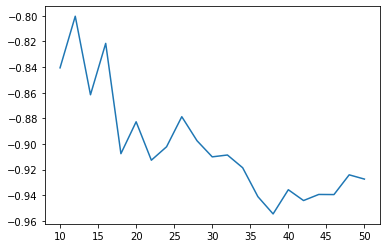

In [255]:
plt.plot(np.arange(10,52,2), [x[1] for x in coherence])
plt.show()

In [45]:
from gensim.models import LdaSeqModel


In [ ]:
ldaseq = LdaSeqModel(corpus=corpus, time_slice=df.groupby('year').count().date.to_list(), 
                     initialize='gensim', id2word=id2word, lda_model = lda, chunksize=100)

2022-01-25 13:03:57,874 : INFO : using symmetric eta at 0.1
2022-01-25 13:03:57,877 : INFO : using serial LDA version on this node
2022-01-25 13:03:57,896 : INFO : running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 7008 documents, updating model once every 2000 documents, evaluating perplexity every 7008 documents, iterating 50x with a convergence threshold of 0.001000
2022-01-25 13:03:57,992 : INFO : PROGRESS: pass 0, at document #2000/7008
2022-01-25 13:04:00,165 : INFO : merging changes from 2000 documents into a model of 7008 documents
2022-01-25 13:04:00,176 : INFO : topic #0 (0.010): 0.016*"song" + 0.009*"music" + 0.007*"man" + 0.007*"book" + 0.006*"country" + 0.006*"money" + 0.005*"place" + 0.005*"world" + 0.005*"guy" + 0.004*"guest"
2022-01-25 13:04:00,178 : INFO : topic #5 (0.010): 0.011*"dog" + 0.009*"book" + 0.007*"film" + 0.005*"story" + 0.005*"animal" + 0.005*"character" + 0.005*"case" + 0.005*"guest" + 0.005*"problem" + 0.005*"music

2022-01-25 13:04:13,263 : INFO : topic diff=0.556925, rho=0.426246
2022-01-25 13:04:13,432 : INFO : PROGRESS: pass 1, at document #6000/7008
2022-01-25 13:04:15,512 : INFO : merging changes from 2000 documents into a model of 7008 documents
2022-01-25 13:04:15,523 : INFO : topic #1 (0.010): 0.014*"case" + 0.010*"story" + 0.010*"book" + 0.008*"law" + 0.008*"prison" + 0.008*"president" + 0.007*"company" + 0.007*"court" + 0.007*"government" + 0.007*"investigation"
2022-01-25 13:04:15,524 : INFO : topic #9 (0.010): 0.024*"school" + 0.017*"kid" + 0.017*"guy" + 0.014*"game" + 0.013*"book" + 0.013*"father" + 0.011*"parent" + 0.010*"child" + 0.008*"college" + 0.008*"player"
2022-01-25 13:04:15,526 : INFO : topic #8 (0.010): 0.019*"company" + 0.018*"money" + 0.010*"business" + 0.009*"tax" + 0.009*"bank" + 0.009*"book" + 0.008*"country" + 0.008*"government" + 0.007*"market" + 0.006*"drug"
2022-01-25 13:04:15,526 : INFO : topic #2 (0.010): 0.014*"book" + 0.011*"brain" + 0.011*"food" + 0.011*"pati

2022-01-25 13:04:30,187 : INFO : PROGRESS: pass 3, at document #2000/7008
2022-01-25 13:04:32,123 : INFO : merging changes from 2000 documents into a model of 7008 documents
2022-01-25 13:04:32,133 : INFO : topic #2 (0.010): 0.014*"book" + 0.013*"food" + 0.012*"brain" + 0.012*"patient" + 0.012*"drug" + 0.011*"doctor" + 0.010*"health" + 0.009*"child" + 0.009*"care" + 0.008*"cancer"
2022-01-25 13:04:32,135 : INFO : topic #7 (0.010): 0.014*"book" + 0.013*"state" + 0.012*"right" + 0.010*"woman" + 0.008*"election" + 0.008*"group" + 0.008*"country" + 0.008*"president" + 0.007*"movement" + 0.007*"campaign"
2022-01-25 13:04:32,136 : INFO : topic #8 (0.010): 0.024*"money" + 0.021*"company" + 0.012*"business" + 0.011*"bank" + 0.010*"government" + 0.009*"system" + 0.009*"country" + 0.009*"market" + 0.008*"tax" + 0.008*"industry"
2022-01-25 13:04:32,137 : INFO : topic #5 (0.010): 0.026*"dog" + 0.019*"water" + 0.018*"animal" + 0.010*"book" + 0.007*"cat" + 0.007*"world" + 0.006*"oil" + 0.006*"proble

2022-01-25 13:04:46,899 : INFO : topic #6 (0.010): 0.016*"character" + 0.013*"movie" + 0.011*"mother" + 0.011*"film" + 0.011*"woman" + 0.010*"book" + 0.010*"series" + 0.010*"scene" + 0.010*"man" + 0.009*"father"
2022-01-25 13:04:46,900 : INFO : topic #5 (0.010): 0.023*"dog" + 0.021*"water" + 0.017*"animal" + 0.012*"cat" + 0.010*"book" + 0.007*"world" + 0.007*"space" + 0.007*"oil" + 0.007*"food" + 0.007*"place"
2022-01-25 13:04:46,902 : INFO : topic #2 (0.010): 0.015*"book" + 0.013*"drug" + 0.013*"brain" + 0.012*"food" + 0.011*"doctor" + 0.011*"patient" + 0.010*"child" + 0.008*"cancer" + 0.008*"body" + 0.008*"health"
2022-01-25 13:04:46,903 : INFO : topic #9 (0.010): 0.031*"school" + 0.023*"kid" + 0.021*"guy" + 0.015*"game" + 0.014*"father" + 0.013*"parent" + 0.012*"child" + 0.011*"college" + 0.011*"book" + 0.009*"player"
2022-01-25 13:04:46,904 : INFO : topic #1 (0.010): 0.018*"case" + 0.013*"story" + 0.010*"prison" + 0.010*"book" + 0.009*"law" + 0.009*"police" + 0.009*"court" + 0.008*

2022-01-25 13:05:03,278 : INFO : topic #8 (0.010): 0.027*"money" + 0.023*"company" + 0.013*"business" + 0.011*"government" + 0.011*"health" + 0.010*"bank" + 0.010*"system" + 0.010*"country" + 0.009*"care" + 0.009*"market"
2022-01-25 13:05:03,281 : INFO : topic #3 (0.010): 0.033*"film" + 0.023*"movie" + 0.015*"story" + 0.014*"book" + 0.011*"man" + 0.009*"novel" + 0.008*"world" + 0.008*"critic" + 0.007*"director" + 0.007*"death"
2022-01-25 13:05:03,285 : INFO : topic #1 (0.010): 0.018*"case" + 0.013*"story" + 0.012*"police" + 0.011*"prison" + 0.010*"law" + 0.009*"book" + 0.009*"information" + 0.008*"court" + 0.008*"president" + 0.008*"investigation"
2022-01-25 13:05:03,288 : INFO : topic #2 (0.010): 0.014*"book" + 0.013*"drug" + 0.013*"food" + 0.013*"brain" + 0.012*"doctor" + 0.012*"patient" + 0.009*"health" + 0.008*"cancer" + 0.008*"hospital" + 0.008*"child"
2022-01-25 13:05:03,290 : INFO : topic diff=0.162017, rho=0.308548
2022-01-25 13:05:03,458 : INFO : PROGRESS: pass 6, at document 

2022-01-25 13:05:17,831 : INFO : topic #4 (0.010): 0.058*"song" + 0.034*"music" + 0.023*"singing" + 0.021*"album" + 0.016*"band" + 0.011*"record" + 0.011*"singer" + 0.009*"jazz" + 0.008*"love" + 0.007*"guitar"
2022-01-25 13:05:17,833 : INFO : topic #0 (0.010): 0.031*"war" + 0.017*"government" + 0.015*"country" + 0.012*"president" + 0.009*"administration" + 0.009*"book" + 0.008*"military" + 0.008*"attack" + 0.008*"group" + 0.007*"weapon"
2022-01-25 13:05:17,834 : INFO : topic #6 (0.010): 0.017*"character" + 0.012*"movie" + 0.012*"woman" + 0.012*"mother" + 0.011*"series" + 0.010*"scene" + 0.010*"film" + 0.010*"father" + 0.010*"man" + 0.009*"book"
2022-01-25 13:05:17,836 : INFO : topic diff=0.114712, rho=0.294833
2022-01-25 13:05:20,742 : INFO : -7.230 per-word bound, 150.1 perplexity estimate based on a held-out corpus of 1008 documents with 541405 words
2022-01-25 13:05:20,743 : INFO : PROGRESS: pass 7, at document #7008/7008
2022-01-25 13:05:21,774 : INFO : merging changes from 1008 do

2022-01-25 13:05:34,209 : INFO : topic #2 (0.010): 0.015*"book" + 0.014*"drug" + 0.013*"brain" + 0.013*"food" + 0.012*"doctor" + 0.012*"patient" + 0.009*"health" + 0.009*"body" + 0.008*"cancer" + 0.008*"hospital"
2022-01-25 13:05:34,210 : INFO : topic #0 (0.010): 0.030*"war" + 0.018*"government" + 0.015*"country" + 0.011*"president" + 0.009*"administration" + 0.009*"book" + 0.008*"military" + 0.008*"attack" + 0.008*"group" + 0.007*"weapon"
2022-01-25 13:05:34,211 : INFO : topic #4 (0.010): 0.063*"song" + 0.036*"music" + 0.023*"singing" + 0.020*"album" + 0.016*"band" + 0.011*"record" + 0.010*"singer" + 0.009*"jazz" + 0.008*"love" + 0.007*"guitar"
2022-01-25 13:05:34,212 : INFO : topic diff=0.120255, rho=0.272125
2022-01-25 13:05:34,378 : INFO : PROGRESS: pass 9, at document #4000/7008
2022-01-25 13:05:36,284 : INFO : merging changes from 2000 documents into a model of 7008 documents
2022-01-25 13:05:36,294 : INFO : topic #8 (0.010): 0.028*"money" + 0.024*"company" + 0.014*"business" + 0

2022-01-25 14:40:37,208 : INFO : Computing bound, all times
2022-01-25 14:40:38,921 : INFO : initial sslm bound is -917957.864181
2022-01-25 14:44:34,955 : INFO : Computing bound, all times
2022-01-25 14:44:36,630 : INFO : iteration 1 iteration lda seq bound is -881012.448685 convergence is 0.040247
2022-01-25 14:46:17,398 : INFO : Computing bound, all times
2022-01-25 14:46:19,090 : INFO : iteration 2 iteration lda seq bound is -869963.940939 convergence is 0.012541
2022-01-25 14:46:19,726 : INFO : Fitting topic number 6
2022-01-25 14:46:21,608 : INFO : Computing bound, all times
2022-01-25 14:46:23,296 : INFO : initial sslm bound is -6161762.418208
2022-01-25 14:55:20,137 : INFO : Computing bound, all times
2022-01-25 14:55:21,820 : INFO : iteration 1 iteration lda seq bound is -5946458.036780 convergence is 0.034942
2022-01-25 14:58:45,846 : INFO : Computing bound, all times
2022-01-25 14:58:47,537 : INFO : iteration 2 iteration lda seq bound is -5921799.734536 convergence is 0.0041

2022-01-25 16:53:25,845 : INFO : Computing bound, all times
2022-01-25 16:53:27,537 : INFO : iteration 1 iteration lda seq bound is -1338496.470793 convergence is 0.006814
2022-01-25 16:54:28,639 : INFO : Computing bound, all times
2022-01-25 16:54:30,328 : INFO : iteration 2 iteration lda seq bound is -1333251.253914 convergence is 0.003919
2022-01-25 16:54:31,961 : INFO : iteration 1 iteration lda seq bound is -45202138.846699 convergence is 0.027289
2022-01-25 16:54:31,964 : INFO :  EM iter 2
2022-01-25 16:54:31,968 : INFO : E Step
2022-01-25 16:54:32,034 : INFO : using symmetric eta at 0.1
2022-01-25 16:54:32,047 : INFO : using serial LDA version on this node
2022-01-25 17:53:59,165 : INFO : M Step
2022-01-25 17:53:59,166 : INFO : Fitting topic number 0
2022-01-25 17:54:01,105 : INFO : Computing bound, all times
2022-01-25 17:54:02,807 : INFO : initial sslm bound is -1581902.050638
2022-01-25 17:55:54,170 : INFO : Computing bound, all times
2022-01-25 17:55:55,863 : INFO : iteratio

2022-01-25 20:05:55,074 : INFO : iteration 1 iteration lda seq bound is -2222098.297595 convergence is 0.001433
2022-01-25 20:07:28,323 : INFO : Computing bound, all times
2022-01-25 20:07:31,785 : INFO : iteration 2 iteration lda seq bound is -2219939.033018 convergence is 0.000972
2022-01-25 20:07:32,977 : INFO : Fitting topic number 4
2022-01-25 20:07:35,356 : INFO : Computing bound, all times
2022-01-25 20:07:38,619 : INFO : initial sslm bound is -2578445.699352
2022-01-25 20:10:55,382 : INFO : Computing bound, all times
2022-01-25 20:10:58,179 : INFO : iteration 1 iteration lda seq bound is -2574312.076299 convergence is 0.001603
2022-01-25 20:13:49,211 : INFO : Computing bound, all times
2022-01-25 20:13:53,336 : INFO : iteration 2 iteration lda seq bound is -2571074.780610 convergence is 0.001258
2022-01-25 20:13:54,601 : INFO : Fitting topic number 5
2022-01-25 20:13:59,195 : INFO : Computing bound, all times
2022-01-25 20:14:04,003 : INFO : initial sslm bound is -983463.038810

2022-01-26 00:15:39,297 : INFO : initial sslm bound is -1094822.095664
2022-01-26 00:17:07,734 : INFO : Computing bound, all times
2022-01-26 00:17:10,286 : INFO : iteration 1 iteration lda seq bound is -1093329.120768 convergence is 0.001364
2022-01-26 00:18:02,687 : INFO : Computing bound, all times
2022-01-26 00:18:05,246 : INFO : iteration 2 iteration lda seq bound is -1092165.554112 convergence is 0.001064
2022-01-26 00:18:06,254 : INFO : Fitting topic number 9
2022-01-26 00:18:08,887 : INFO : Computing bound, all times
2022-01-26 00:18:11,457 : INFO : initial sslm bound is -1770599.498816
2022-01-26 00:20:38,414 : INFO : Computing bound, all times
2022-01-26 00:20:40,941 : INFO : iteration 1 iteration lda seq bound is -1768027.724492 convergence is 0.001452
2022-01-26 00:21:49,864 : INFO : Computing bound, all times
2022-01-26 00:21:52,399 : INFO : iteration 2 iteration lda seq bound is -1766586.156841 convergence is 0.000815
2022-01-26 00:21:53,401 : INFO : iteration 4 iteration